# 8Day subsampling on the OceanColor Dataset 
* LDS-fitting framework:
* after resampling based on frequency, we drop NANs on float dataset for ['id', 'lat', 'lon', 'time'] before carrying out the multilinear interpolation

  -> {e.g. row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical}
  
  -> {for ['id', 'time'], you will get lots of nonsense data, typical life of float is 1~2 years}
  
  -> {after drop nans in ['id', 'lat', 'lon', 'time'], one can assume the float data has a good quality and is continuous during its life time}
  
  -> {therefore, LDS is applid to the chl-a after dropping nans above}
* the data is processed(interpolated) to generate {chl-a} and {distance to coast} only, more later...
* {more features to be added at this step if needed}
* {fill-in preprocessing here, if needed}
* #not# taking any temporal difference to compute chl-rate; before chl_rates.add_chl_rates
* #not# taking any reduction to the November-March period to keep the time index intact
* visualize the chl-a for one float
* output the dataframe for LDS
* fit LDS for one float

In [69]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [70]:
# resampling frequency in number of days
freq=8

## Load data from disk

We already downloaded a subsetted MODIS-Aqua chlorophyll-a dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [71]:
ds_8day = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [72]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[534.295504, 4241.4716]


The 8-day dataset is ~534 MB while the daily dataset is 4.2 GB. These both easily fit in RAM. So let's load them all into memory

In [73]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
 Data variables:
     chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [74]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [75]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [76]:
ds_8day.chlor_a>0

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chlor_a' (time: 667, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., Fal

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


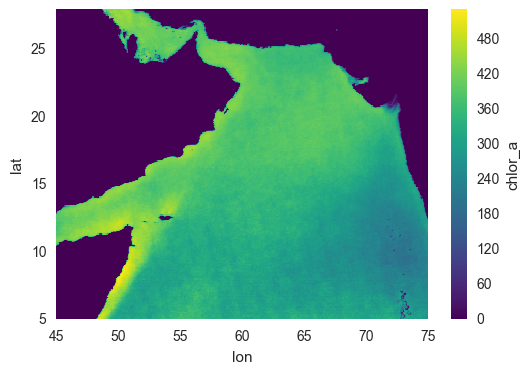

In [77]:
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


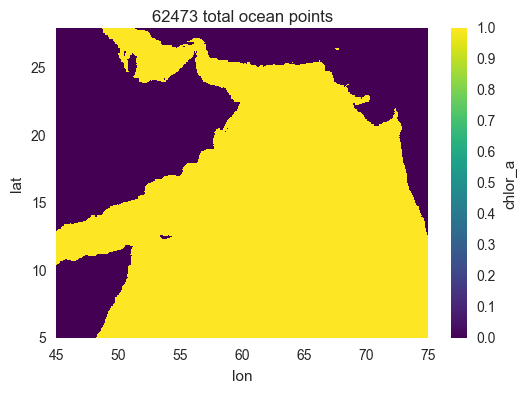

In [78]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [79]:
#ds_8day

In [80]:
#ds_daily

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


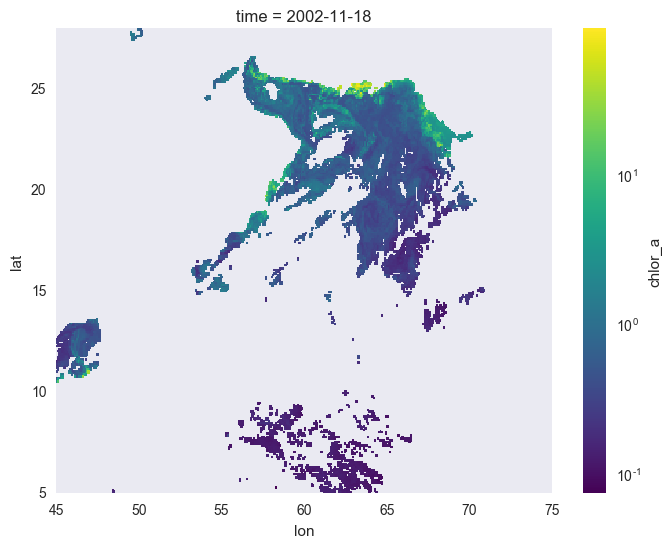

In [81]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())
#ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [82]:
#list(ds_daily.groupby('time')) # take a look at what's inside

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [83]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    chlor_a  (time) int64 658 1170 1532 2798 2632 1100 1321 636 2711 1163 ...
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...

In [84]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5295)>
array([ 0.01053255,  0.01872809,  0.02452259, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

In [85]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

In [86]:
#count_8day = ds_8day.chl_ocx.groupby('time').count()/float(num_ocean_points)
#coundt_daily = ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

#count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in ds_8day, ds_daily] # not work in python 3


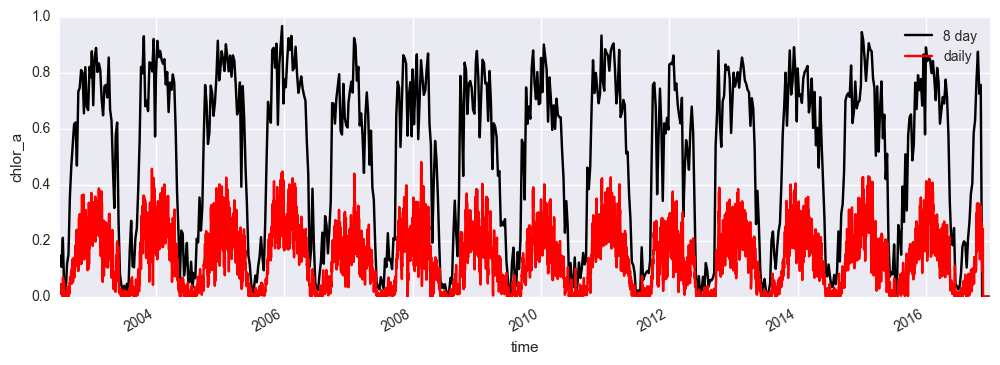

In [87]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

## Seasonal Climatology

In [88]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

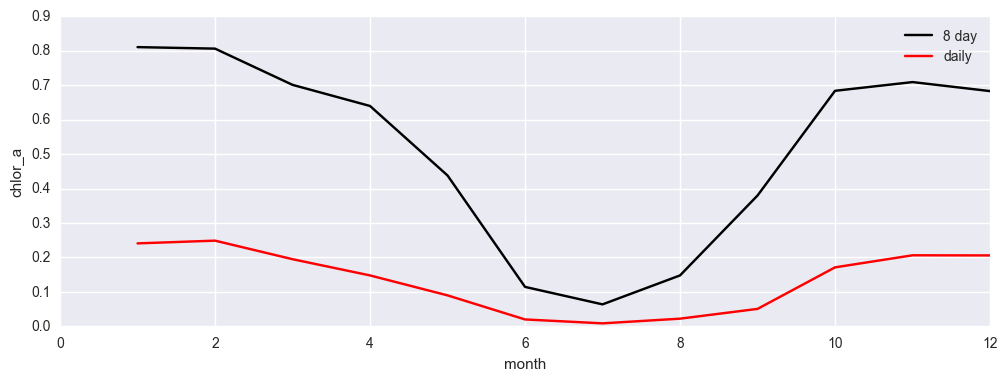

In [89]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


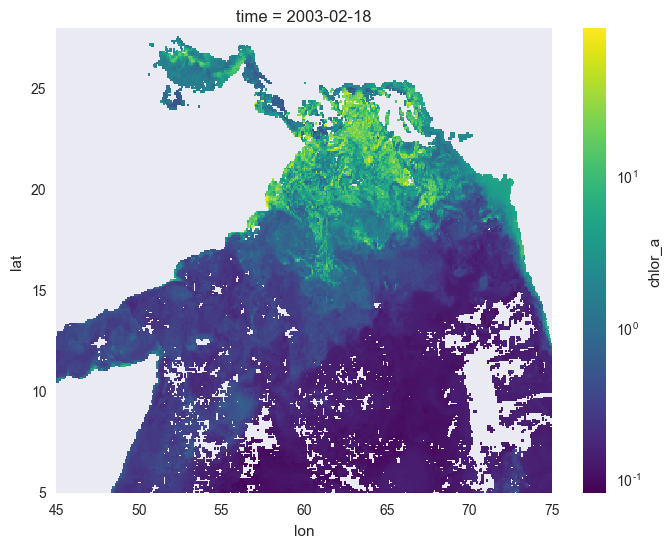

In [90]:
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


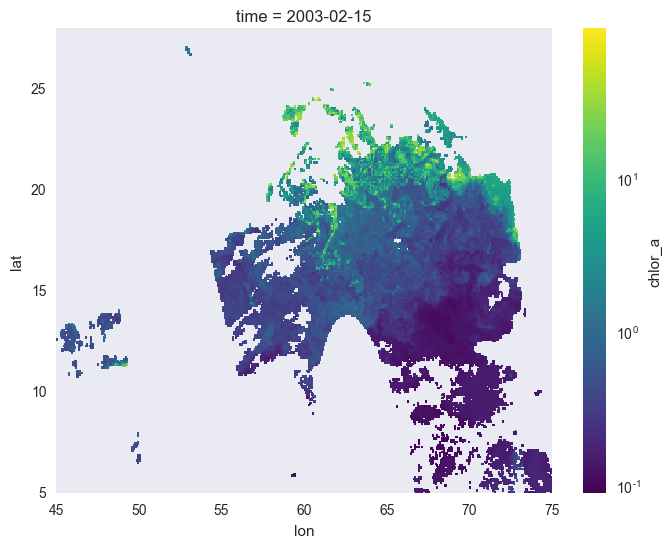

In [91]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [92]:
ds_daily.chlor_a[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chlor_a' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 2002-07-04
    lon      (points) float64 65.04 70.04
    lat      (points) float64 16.04 18.04
  * points   (points) int64 0 1

In [93]:
df = pd.DataFrame([[1.4, np.nan], [7.1, -4.5], [np.nan, np.nan], [0.75, -1.3]], 
               index=['a', 'b', 'c', 'd'], columns=['one', 'two'])
df.mean(axis=1,skipna=None) # try skipna=False, skipna=True(seems to equiv to skipna=None)

a    1.400
b    1.300
c      NaN
d   -0.275
dtype: float64

In [94]:
freq_resample = str(freq) + 'D'
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 662)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
Data variables:
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


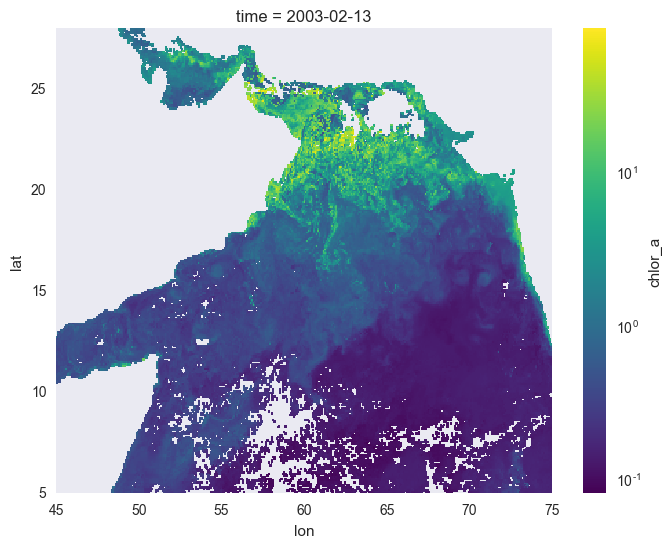

In [95]:
plt.figure(figsize=(8,6))
ds_resample.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [96]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.04166793823242) 
 <xarray.DataArray 'lat' ()>
array(5.041661739349365)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [97]:
# in the following we deal with the data from the gdp float
from buyodata import buoydata
import os

In [98]:
# a list of files
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']

In [99]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for chlor_a
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 

0

In [100]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


id           lat           lon          temp            ve  \
count  2.147732e+07  2.131997e+07  2.131997e+07  1.986179e+07  2.129142e+07   
mean   1.765662e+06 -2.263128e+00  2.124412e+02  1.986121e+01  2.454172e-01   
std    9.452835e+06  3.401115e+01  9.746941e+01  8.339498e+00  2.525050e+01   
min    2.578000e+03 -7.764700e+01  0.000000e+00 -1.685000e+01 -2.916220e+02   
25%    4.897500e+04 -3.186000e+01  1.490720e+02  1.437300e+01 -1.411400e+01   
50%    7.141300e+04 -4.920000e+00  2.153940e+02  2.214400e+01 -5.560000e-01   
75%    1.094330e+05  2.756000e+01  3.064370e+02  2.688900e+01  1.356100e+01   
max    6.399288e+07  8.989900e+01  3.600000e+02  4.595000e+01  4.417070e+02   

                 vn           spd       var_lat       var_lon       var_tmp  
count  2.129142e+07  2.129142e+07  2.147732e+07  2.147732e+07  2.147732e+07  
mean   4.708192e-01  2.613427e+01  7.326258e+00  7.326555e+00  7.522298e+01  
std    2.052160e+01  1.939087e+01  8.527853e+01  8.527851e+01  2.637454e+02  
min   -2.601400e+02  0.000000e+00  5.268300e-07 -3.941600e-02  1.001300e-03  
25%   -1.044700e+01  1.290300e+01  4.366500e-06  7.512600e-06  1.435700e-03  
50%    1.970000e-01  2.176700e+01  8.833600e-06  1.495800e-05  1.691700e-03  
75%    1.109300e+01  3.405900e+01  1.833300e-05  3.627900e-05  2.294200e-03  
max    2.783220e+02  4.421750e+02  1.000000e+03  1.000000e+03  1.000000e+03

In [101]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )

dfvvAll.shape is (21477317, 11), floatsAll.shape is (111894, 11)


In [102]:
''' takes took long
# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvvAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)
'''

'''
# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)
'''

"\n# visualize the float around the arabian sea region\nfig, ax  = plt.subplots(figsize=(12,10))\nfloatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)\n"

In [103]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'
print()

In [104]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 259, time: 17499)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [105]:
floatsDSAll.dims

Frozen(SortedKeysDict({'id': 259, 'time': 17499}))

In [106]:
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_resample =floatsDSAll.resample(freq_resample, dim='time')
print(floatsDSAll_resample.dims)   # downsampling on the 'time' dimension 17499/9/4=  around 486
floatsDSAll_resample

Frozen(SortedKeysDict(OrderedDict([('id', 259), ('time', 639)])))


<xarray.Dataset>
Dimensions:  (id: 259, time: 639)
Coordinates:
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
Data variables:
    lon      (time, id) float64 nan 66.51 69.86 64.99 69.87 nan 69.35 nan ...
    lat      (time, id) float64 nan 16.21 13.62 16.14 13.65 nan 20.09 nan ...
    ve       (time, id) float64 nan 7.335 13.25 12.26 12.13 nan 24.29 nan ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.00364 0.08777 nan 0.001711 ...
    spd      (time, id) float64 nan 8.832 18.7 19.48 17.6 nan 25.74 nan ...
    var_lon  (time, id) float64 nan 0.005415 0.0001179 0.0001259 9.874e-05 ...
    var_lat  (time, id) float64 nan 0.001424 6.2e-05 6.574e-05 5.391e-05 nan ...
    vn       (time, id) float64 nan -0.2949 -9.82 -12.91 -8.593 nan -1.964 ...
    temp     (time, id) float64 nan nan nan 27.81 28.57 nan 28.99 nan 27.65 ...

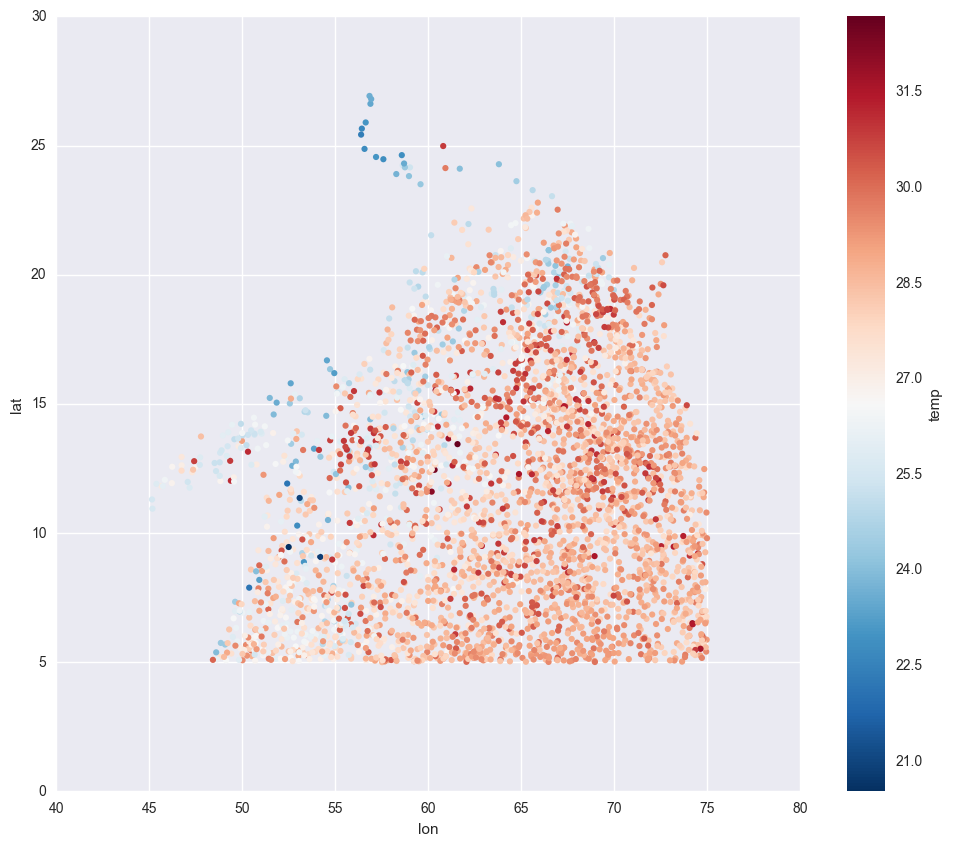

In [107]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_resample = floatsDSAll_resample.to_dataframe()
floatsDFAll_resample
floatsDFAll_resample = floatsDFAll_resample.reset_index()
floatsDFAll_resample
# visualize the subsamping of floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_resample.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [108]:
# get the value for the chlorophyll for each data entry
floatsDFAll_resample_timeorder = floatsDFAll_resample.sort_values(['time','id'],ascending=True)
floatsDFAll_resample_timeorder[:20] # check whether it is time ordered!!
# should we drop nan to speed up??

id       time        lon        lat         ve      var_tmp  \
0       7574 2002-07-04        NaN        NaN        NaN          NaN   
639    10206 2002-07-04  66.510656  16.208687   7.334875  1000.000000   
1278   10208 2002-07-04  69.858594  13.617187  13.248719  1000.000000   
1917   11089 2002-07-04  64.993937  16.140125  12.260094     0.003640   
2556   15703 2002-07-04  69.867031  13.648188  12.131219     0.087771   
3195   15707 2002-07-04        NaN        NaN        NaN          NaN   
3834   27069 2002-07-04  69.350187  20.090281  24.285875     0.001711   
4473   27139 2002-07-04        NaN        NaN        NaN          NaN   
5112   28842 2002-07-04  60.820937  18.663125   3.765094     0.003330   
5751   34159 2002-07-04  59.602656  12.808719  31.401250  1000.000000   
6390   34173 2002-07-04        NaN        NaN        NaN          NaN   
7029   34210 2002-07-04  56.754250   6.092000  -2.609125     0.003695   
7668   34211 2002-07-04  68.470625   8.265656  22.912125     0.003516   
8307   34212 2002-07-04  65.751156   6.659437  41.911531     0.003590   
8946   34223 2002-07-04        NaN        NaN        NaN          NaN   
9585   34310 2002-07-04        NaN        NaN        NaN          NaN   
10224  34311 2002-07-04        NaN        NaN        NaN          NaN   
10863  34312 2002-07-04        NaN        NaN        NaN          NaN   
11502  34314 2002-07-04        NaN        NaN        NaN          NaN   
12141  34315 2002-07-04        NaN        NaN        NaN          NaN   

             spd   var_lon   var_lat         vn       temp  
0            NaN       NaN       NaN        NaN        NaN  
639     8.832125  0.005415  0.001424  -0.294906        NaN  
1278   18.702906  0.000118  0.000062  -9.820156        NaN  
1917   19.484250  0.000126  0.000066 -12.911969  27.807781  
2556   17.604156  0.000099  0.000054  -8.592531  28.569812  
3195         NaN       NaN       NaN        NaN        NaN  
3834   25.743625  0.000099  0.000054  -1.963906  28.985781  
4473         NaN       NaN       NaN        NaN        NaN  
5112   17.876969  0.000218  0.000103  -7.667469  27.649500  
5751   35.638313  0.000116  0.000061  14.802688        NaN  
6390         NaN       NaN       NaN        NaN        NaN  
7029   25.260719  0.000125  0.000064 -15.458906  26.541750  
7668   27.956094  0.000102  0.000055 -13.744125  28.372250  
8307   46.824937  0.000102  0.000055  12.766750  28.576844  
8946         NaN       NaN       NaN        NaN        NaN  
9585         NaN       NaN       NaN        NaN        NaN  
10224        NaN       NaN       NaN        NaN        NaN  
10863        NaN       NaN       NaN        NaN        NaN  
11502        NaN       NaN       NaN        NaN        NaN  
12141        NaN       NaN       NaN        NaN        NaN

In [109]:
'''
<xarray.Dataset>
Dimensions:  (id: 259, time: 639)   # 259*639
'''
floatsDFAll_resample_timeorder.lon.shape

(165501,)

In [110]:
# can we try to fit the missing value at thisstep
floatsDFAll_resample_timeorder.lon.dropna().shape  # the longitude data has lots of values (3855,)

(3855,)

In [111]:
############ interpolation starts from here

          id       time  lon  lat  ve  var_tmp  spd  var_lon  var_lat  vn  \
63900  62558 2002-07-04  NaN  NaN NaN      NaN  NaN      NaN      NaN NaN   
64539  63036 2002-07-04  NaN  NaN NaN      NaN  NaN      NaN      NaN NaN   
65178  63067 2002-07-04  NaN  NaN NaN      NaN  NaN      NaN      NaN NaN   
65817  63068 2002-07-04  NaN  NaN NaN      NaN  NaN      NaN      NaN NaN   
66456  63069 2002-07-04  NaN  NaN NaN      NaN  NaN      NaN      NaN NaN   

       temp  
63900   NaN  
64539   NaN  
65178   NaN  
65817   NaN  
66456   NaN  
          id       time        lon        lat         ve   var_tmp        spd  \
66690  63069 2007-08-19  55.505667  15.953278  73.559118  0.007292  77.525824   
66691  63069 2007-08-27  59.003187  15.608750  43.044219  0.002030  52.624125   
66692  63069 2007-09-04  59.203125  16.505094 -19.361750  0.001878  33.769813   
66693  63069 2007-09-12  59.234000  18.418781  21.895625  0.001943  39.471750   
66694  63069 2007-09-20  60.825938  17.003875  2

array([    7574,    10206,    10208,    11089,    15703,    15707,
          27069,    27139,    28842,    34159,    34173,    34210,
          34211,    34212,    34223,    34310,    34311,    34312,
          34314,    34315,    34374,    34708,    34709,    34710,
          34714,    34716,    34718,    34719,    34720,    34721,
          34722,    34723,    36530,    36537,    37192,    37194,
          37200,    37213,    37214,    37641,    39204,    40084,
          40273,    40552,    41317,    42519,    43598,    43740,
          43743,    43744,    43746,    43748,    43995,    45748,
          46470,    46471,    46472,    53352,    53358,    53363,
          53364,    53365,    53366,    53367,    53404,    54017,
          54038,    54371,    57939,    57940,    59213,    59215,
          59362,    59363,    59365,    59366,    59367,    59368,
          59369,    59371,    59372,    59373,    59394,    60492,
          62193,    62195,    62196,    62197,    62198,    62

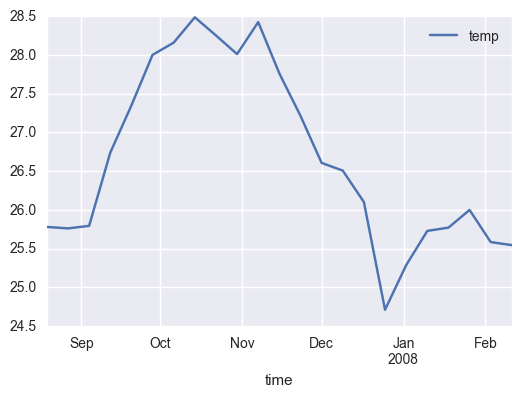

In [161]:
# to understand the float data better
# a: Look into the floatsDFAll_9Dtimeorder data in more details
# check the nan counts in each id
# plot the trajectory of {time, lat, lon, temperature,} for each float id,  
# this steps helps to understand the float dataset and if there is a need, improve it.

# b: take the float data as it is, and do the interpolation, whenever there is a nan value use the nearest neigbhours....
# check whether the quality of interpolataion is improved, if not, then have to fall back to to task 1

# c: vectorization

# DataFrame panel data 
# floatsDFAll_9Dtimeorder.set_index(['id','time']) 
# the inverse operation # floatsDFAll_9Dtimeorder.reset_index()
# look into the data
print(floatsDFAll_resample_timeorder[100:105])
# so far there is no need to convert it into a panel 
# floatsDFAll_9DtimeorderPanel = floatsDFAll_9Dtimeorder.to_panel

# plot the temperature for one float, the temperature do have a trend
#maskid = (floatsDFAll_resample_timeorder.id == 63069) & (floatsDFAll_resample_timeorder.time > '2007-01-01') & (floatsDFAll_resample_timeorder.time < '2009-01-01')
maskid = (floatsDFAll_resample_timeorder.id == 63069)
print(floatsDFAll_resample_timeorder[maskid].dropna(subset=['id', 'lat', 'lon', 'time']) )
floatsDFAll_resample_timeorder[maskid].dropna(subset=['id', 'lat', 'lon', 'time']).plot(x='time', y ='temp')

# set of all float ids
floatsDFAll_resample_timeorder.id.unique()



In [162]:
# this is a float that explains the need for temperature data
maskid2 = floatsDFAll_resample_timeorder.id == 10208
floatsDFAll_resample_timeorder[maskid2].head()

id       time        lon        lat         ve  var_tmp        spd  \
1278  10208 2002-07-04  69.858594  13.617187  13.248719   1000.0  18.702906   
1279  10208 2002-07-12  70.617062  13.462812   9.182406   1000.0  11.365188   
1280  10208 2002-07-20  71.048719  12.983063   0.343281   1000.0  18.037813   
1281  10208 2002-07-28  70.941656  11.313719  -0.895813   1000.0  38.499656   
1282  10208 2002-08-05  71.055500   9.491062   8.504469   1000.0  20.730219   

       var_lon   var_lat         vn  temp  
1278  0.000118  0.000062  -9.820156   NaN  
1279  0.000116  0.000062  -1.621906   NaN  
1280  0.000121  0.000064 -12.715406   NaN  
1281  0.000143  0.000073 -38.062812   NaN  
1282  0.000126  0.000066 -15.927313   NaN

In [163]:
################
# test case 1: take a single entry (southeast corner for valid values)
row_case1 =  pd.DataFrame(data = {'time':'2002-07-13 00:00:00', 'id': 10206, 'lon':74.7083358765, 'lat':5.20833349228},index=[1])
print(row_case1)

################
# test case 2
# take a {time-list, id-list, lon-list, lat-list}, index-list 
# carry out the interpolation
#row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00','2002-07-22 00:00:00'] , 'id': [10206, 10206], 'lon':[74.7083358765, 74.6250076294], 'lat':[5.20833349228, 5.29166173935]},index=[2,3])
#print(row_case2)
################
# test case 3
row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00'] , 'id': [10206, 10206, 10206], 'lon':[74.7083358765, 74.6250076294,74.7083358765], 'lat':[5.20833349228, 5.29166173935, 5.20833349228]},index=[1,2,3])
print(row_case2)



####
## get the indices of time, lat, lon
idx_time = ds_resample.indexes['time']
idx_lat = ds_resample.indexes['lat']
idx_lon = ds_resample.indexes['lon']

#### 
#interpolation on the time dimension
time_len = len(row_case2.time.values)
xtime_test = list([ np.datetime64(row_case2.time.values[i]) for i in range(0,time_len)  ] )  # for delta 
print('\n xtime_test \n', xtime_test)

'''caution: cannot do this inside the function get_loc,
see https://github.com/pandas-dev/pandas/issues/3488
'''
itime_nearest = [idx_time.get_loc(xtime_test[i], method='nearest') for i in range(0, time_len)]
print('\n itime_nearest \n', itime_nearest)  # [1,2]

xtime_nearest =  ds_resample.time[itime_nearest].values  #  ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('\n xtime_nearest\n', xtime_nearest)  # ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('xtime_nearest', type(xtime_nearest)) # xtime_nearest <class 'numpy.ndarray'> # time_nearest <class 'numpy.datetime64'>

# the time distance in days
delta_xtime = (xtime_test - xtime_nearest) / np.timedelta64(1, 'D')
print('\n delta_xtime in days \n', delta_xtime)
print(type(delta_xtime))

itime_next = [itime_nearest[i]+1 if  delta_xtime[i] >=0  else itime_nearest[i]-1  for i in range(0, time_len) ]
print('\n itime_next \n',itime_next)  # [2, 3]

# find the next coordinate values
xtime_next = ds_resample.time[itime_next].values
print('\n xtime_next \n', xtime_next) # ['2002-07-22T00:00:00.000000000' '2002-07-31T00:00:00.000000000']

# prepare for the Tri-linear interpolation
base_time = (xtime_next - xtime_nearest) / np.timedelta64(1, 'D')  # [ 9.  9.]
print('\n base_time \n', base_time)
w_time = delta_xtime / base_time  
print('\n w_time \n', w_time) # [ 0.  0.]


#### 
#interpolation on the lat dimension
xlat_test = row_case2.lat.values + 0.06   # base [ 5.20833349  5.29166174] # cell distance around .8, use .2 & .6 as two tests
print('\n xlat_test \n', xlat_test)       # xlat_test [ 5.26833349  5.35166174]

ilat_nearest = [idx_lat.get_loc(xlat_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilat_nearest \n', ilat_nearest) # [272, 271]

xlat_nearest = ds_resample.lat[ilat_nearest].values  
print('\n xlat_nearest \n', xlat_nearest) # [ 5.29166174  5.37499762]

delta_xlat = xlat_test - xlat_nearest
print("\n delta_xlat \n",delta_xlat)      #  [-0.02332825 -0.02333588]


# the nearest index is on the right; but order of the latitude is different, it is descending
ilat_next = [ilat_nearest[i]-1 if  delta_xlat[i] >=0  else ilat_nearest[i]+1  for i in range(0, time_len) ]
print('\n ilat_next \n', ilat_next)  # [273, 272]

# find the next coordinates value
xlat_next = ds_resample.lat[ilat_next].values
print('\n xlat_next \n', xlat_next)  # [ 5.20833349  5.29166174]

# prepare for the Tri-linear interpolation
w_lat = delta_xlat / (xlat_next - xlat_nearest)
print('\n w_lat \n', w_lat) # [ 0.27995605  0.28002197]

#### 
#interpolation on the lon dimension
xlon_test = row_case2.lon.values +0.06 # base [74.7083358765, 74.6250076294] # cell distance around .8, use .2 & .6 as two tests
print('\n xlon_test \n', xlon_test)  # [ 74.76833588  74.68500763]

ilon_nearest = [idx_lon.get_loc(xlon_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilon_nearest \n', ilon_nearest) # [357, 356]

xlon_nearest = ds_resample.lon[ilon_nearest].values  
print('\n xlon_nearest \n', xlon_nearest) # [ 74.79166412  74.70833588]

delta_xlon = xlon_test - xlon_nearest     
print("\n delta_xlon \n", delta_xlon)     #  [-0.02332825 -0.02332825]

ilon_next = [ilon_nearest[i]+1 if  delta_xlon[i] >=0  else ilon_nearest[i]-1  for i in range(0, time_len) ]
print('\n ilon_next \n',ilon_next)  # [356, 355]

# find the next coordinate values
xlon_next = ds_resample.lon[ilon_next].values
print("\n xlon_next \n", xlon_next) # [ 74.70833588  74.62500763]

# prepare for the Tri-linear interpolation
w_lon = delta_xlon / (xlon_next - xlon_nearest)
print("\n w_lon \n", w_lon) # [ 0.27995605  0.27995605]

####
# local Tensor product for Trilinear interpolation
# caution: nan values, store as "list_of_array to 2d_array" first, then sum

# no casting to list needed here, inputs are already lists
tmp = np.array([
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_next).values ])

weights =  np.array([(1-w_time)*(1-w_lat)*(1-w_lon), 
                     (1-w_time)*(1-w_lat)*w_lon,
                     (1-w_time)*w_lat*(1-w_lon), 
                     (1-w_time)*w_lat*w_lon,
                        w_time*(1-w_lat)*(1-w_lon),
                        w_time*(1-w_lat)*w_lon,
                        w_time*w_lat*(1-w_lon),
                        w_time*w_lat*w_lon ])


# how to deal with "nan" values, fill in missing values for the np.array tmpAll 
# or fill the mean values to the unweighted array
# http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns

print('\n neighbouring tensor used \n', tmp)
'''
 neighbouring tensor used 
 [[        nan  0.181841  ]
 [ 0.245878           nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.19680101         nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.18532801         nan]]
'''

# column min: (nan+0.245878 + nan + nan + 0.19680101 + nan +  nan + 0.18532801)/8 = 0.20933567333
col_mean = np.nanmean(tmp, axis=0)
print('\n its mean along axis 0(column) \n', col_mean)  #  [ 0.20933567  0.181841  ]


# filling the missing values.
inds = np.where(np.isnan(tmp))
print('\n nan index\n', inds)
tmp[inds]=np.take(col_mean, inds[1])
print('\n values after the fill \n', tmp)

print('\n weighting tensor used \n', weights)

print("weights.shape", weights.shape) # (8, 3)
print("tmp.shape", tmp.shape)  # (8, 3)

nrow_w, ncol_w = weights.shape
nrow_t, ncol_t = tmp.shape
assert nrow_w == nrow_t, "the row count of weights and values are not the same!"
assert ncol_w == ncol_t, "the row count of weights and values are not the same!"
print('\n tensor product\n', np.dot(weights[:,0], tmp[:,0]) ) # 0.216701896135 should be [ 0.2167019]

# new interpolation process of the Chl_a
chl_new = np.empty(ncol_w)
for i in range(0, ncol_w, 1):
    chl_new[i] =  np.dot(weights[:,i], tmp[:,i])

print('chl_newInt',  chl_new) #  [ 0.2167019  0.181841   0.2167019]
# validate by 1D array
# val = np.array([0.20933567, 0.245878,  0.20933567,
#                0.20933567, 0.19680101, 0.20933567,
#               0.20933567,0.18532801]) 
# np.dot(val, weights) # 0.21670189702309739


## output xarray.dataarray of points, see examples below
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['points'], np.random.randn(3))},
                        coords={
                                'time':(['points'],['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00']) , 
                                'id': (['points'], [10206, 10206, 10206]), 
                                'lon': (['points'], [74.7083358765, 74.6250076294,74.7083358765]),
                                'lat':(['points'], [5.20833349228, 5.29166173935, 5.20833349228]), 
                                'points': (['points'], [0,1,2])}) # this way the dims is set to point

print('\n',chl_newInt.chl)
'''
### Task: output xarray.dataarray as points
## example 1
arr = xr.DataArray(np.random.rand(4,3), [('time', pd.date_range('2000-01-01', periods=4)), ('space', ['IA', 'IL', 'IN'])] )
print("first example",arr)
print("\n \n")

## example2 -- concrete xr.DataArray
data = np.random.rand(4, 3)
locs = ['IA', 'IL', 'IN']
times = pd.date_range('2000-01-01', periods=4)
brr = xr.DataArray(data, coords={'time': times, 'space': locs, 'const': 42, \
                          'ranking': ('space', [1, 2, 3])}, \
             dims=['time', 'space'])
print("second example",brr)
'''

'''
### the target output
#the output generated by the xarray.DataSet => xarray.DataArray
<xarray.DataArray 'chlor_a' (points: 147112)>
array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    lon      (points) float64 74.96 66.54 69.88 65.04 69.88 74.96 69.46 ...
    lat      (points) float64 27.96 16.21 13.62 16.04 13.62 27.96 20.04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  
### the solution approach we tried to is: first,  generate a xarray.DataSet
                                          second, generte a xarray.DataArray from the xarray DataSet if needed.
 
# 1. looking at this example, DataArray seems to be working.

# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

##########
# but not works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  np.array([10206, 10206, 10206])} )
print('\n da_test1', da_test1)

# err's
##########

##########
# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

# da_test1 <xarray.DataArray (x: 3)>
# array([ 0.90386212,  0.21516239,  0.44707272])
# Coordinates:
#   * x        (x) int64 10206 10206 10206
#     y        int64 2
##########

##########
# so we do this
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['id'], np.random.randn(3))},
                        coords={ 
                           'id':  (['id'], np.array([10206, 10206, 10206])), 
                           'lon': (['id'], np.array([74.7083358765, 74.6250076294,74.7083358765])), 
                           'lat': (['id'], np.array([5.20833349228, 5.29166173935, 5.20833349228]))})
print('chl_newInt', chl_newInt) # generate the xarray.DataSet
print('\n \n')
print('chl_newInt.chl', chl_newInt.chl) # xarray.DataSet contains many xarray.DataArray


#chl_newInt <xarray.Dataset>
#Dimensions:  (id: 3)
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208
#Data variables:
#    chl      (id) float64 0.783 -0.9714 -0.3206



#chl_newInt.chl <xarray.DataArray 'chl' (id: 3)>
#array([ 0.78301614, -0.97144208, -0.3206447 ])
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208

'''
print()

      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
2  10206  5.291662  74.625008  2002-07-22 00:00:00
3  10206  5.208333  74.708336  2002-07-13 00:00:00

 xtime_test 
 [numpy.datetime64('2002-07-13T00:00:00'), numpy.datetime64('2002-07-22T00:00:00'), numpy.datetime64('2002-07-13T00:00:00')]

 itime_nearest 
 [1, 2, 1]

 xtime_nearest
 ['2002-07-12T00:00:00.000000000' '2002-07-20T00:00:00.000000000'
 '2002-07-12T00:00:00.000000000']
xtime_nearest <class 'numpy.ndarray'>

 delta_xtime in days 
 [ 1.  2.  1.]
<class 'numpy.ndarray'>

 itime_next 
 [2, 3, 2]

 xtime_next 
 ['2002-07-20T00:00:00.000000000' '2002-07-28T00:00:00.000000000'
 '2002-07-20T00:00:00.000000000']

 base_time 
 [ 8.  8.  8.]

 w_time 
 [ 0.125  0.25   0.125]

 xlat_test 
 [ 5.26833349  5.35166174  5.26833349]

 ilat_nearest 
 [272, 271, 272]

 xlat_nearest 
 [ 5.2916

In [164]:
### output benchmark
### output the dataset ds_9day and output the dataframe  
#ds_9day.to_netcdf("ds_9day.nc")

#row_case4 = pd.DataFrame(data={'time':list(floatsDFAll_9Dtimeorder.time), 'lon':list(floatsDFAll_9Dtimeorder.lon), 'lat':list(floatsDFAll_9Dtimeorder.lat), 'id':list(floatsDFAll_9Dtimeorder.id) } )
##print('\n before dropping nan \n', row_case4)
## process to drop nan in any of the columns [id], [lat], [lon], [time]
#row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
#row_case4.to_csv("row_case4.csv")

In [170]:
#### the approach using Linear Interpolations with 3D tensors
# Keyword Arguments
# approach 1 
# each of the indexers component might be ordered differently
#############
# def sel_points_multilinear(dset, dims='points', out = 'str', **indexers):
## test case
# def sel_points_multilinear(ds_9day, dims = 'points', out ='chlor_a', 
#                            time = list(['2002-07-13 00:00:00']),
#                            lat = list([5]),  lon = list([70]) ):
############
# e.g. time-ascending, lat-descending, need to tell 'time' from 'lat'
# use different parameters for inputs
## approach 2 
## from dataframe to dataset
## input:
##     dframe: list of {time}, {lan}, {lon}, {id}. bounds-aware
##     dset:   carry out the interpolation use dset data structure and its component 
## output:
##     a list or dataframe with chl_newInt.chl

# remember to take log_e instead of log_10

# clean up this notebook, seperate, clean, and take notes

# test case 4: use the full real data
#del(interpolate)
#del(sel_points_multilinear)
# froms dir import src  # to call src.functions
from tools.time_lat_lon_interpolate import interpolate
import importlib
importlib.reload(interpolate)

floatsDF_tmp = floatsDFAll_resample_timeorder

row_case4 = pd.DataFrame(data={'time':list(floatsDF_tmp.time), 'lon':list(floatsDF_tmp.lon), 'lat':list(floatsDF_tmp.lat), 'id':list(floatsDF_tmp.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case4)
result_out4 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, row_case4, dims = 'points', col_name ='chlor_a')
print('\n *** after the interpolation *** \n', result_out4)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(row_case4.index), len(result_out4.points) ) )  


 *** after the interpolation *** 
 <xarray.Dataset>
Dimensions:  (points: 3836)
Coordinates:
    id       (points) int64 10206 10208 11089 15703 27069 28842 34159 34210 ...
    lat      (points) float64 16.21 13.62 16.14 13.65 20.09 18.66 12.81 ...
    lon      (points) float64 66.51 69.86 64.99 69.87 69.35 60.82 59.6 56.75 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
Data variables:
    chlor_a  (points) float64 nan nan nan nan nan nan nan 0.3892 0.1098 ...

 *** this two length should be equal *** 3855 >= 3836?


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [171]:
plt.close("all")

In [194]:
id_set = result_out4.to_dataframe().id.unique()
id_set

array([   10206,    10208,    11089,    15703,    27069,    28842,
          34159,    34210,    34211,    34212,    34708,    34710,
          34714,    34716,    34718,    34719,    34720,    34721,
          34722,    34723,  2134712,    34311,    34312,    34314,
          34315,    34709,    15707,    27139,    36530,    34223,
          36537,    34374,    43743,    43740,  2343739,     7574,
          43746,    43744,    43995,    43748,    53363,    53364,
          53365,    53366,    46472,    53367,    46470,    46471,
          53358,    54371,    53352,    57939,    57940,    59371,
          59372,    59373,    59362,    43598,    62200,    62201,
          62202,    62556,    62557,    62558,    62552,    62196,
          62555,    62198,    63036,    62195,    62193,    62553,
          59365,    59367,    70697,    70699,    59363,    70695,
          59366,    70696,    62199,    62554,    62197,    40552,
          63068,    63069,    63070,    63072,    63074,    63


 ****** chl-a concentration plots for each float ****** 



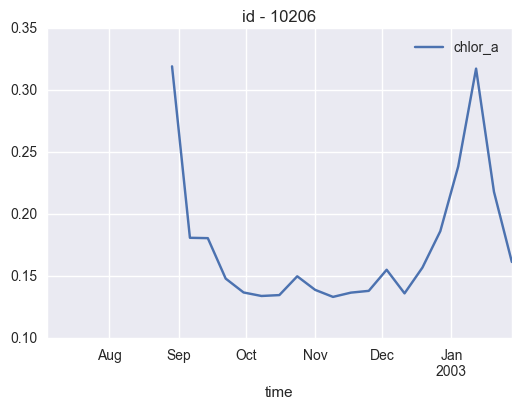

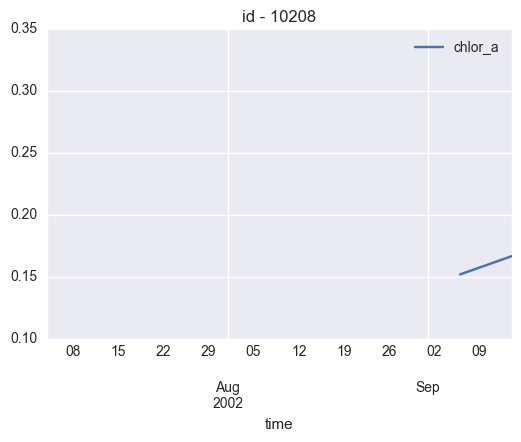

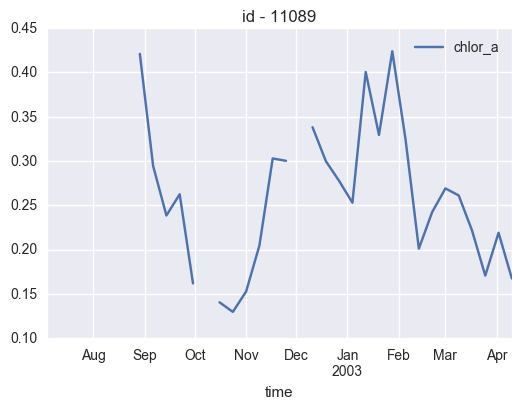

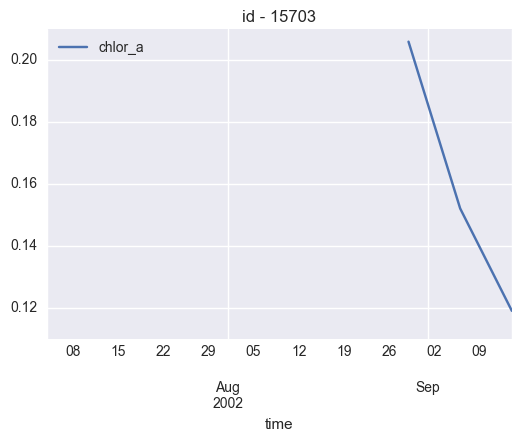

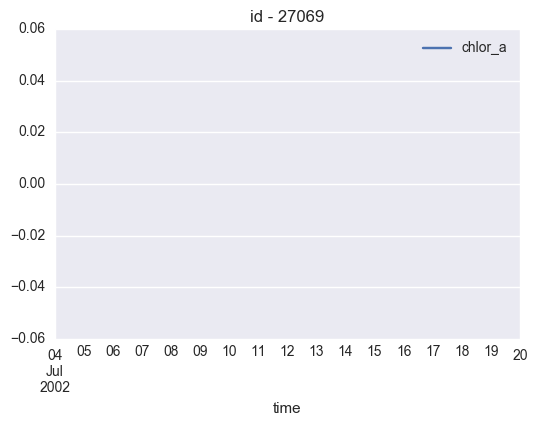

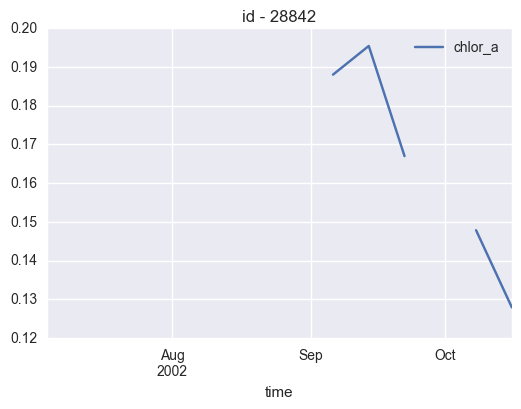

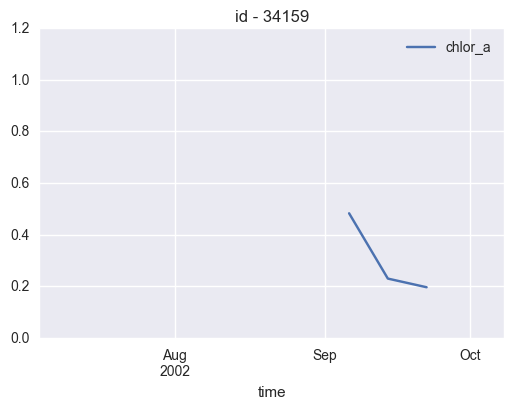

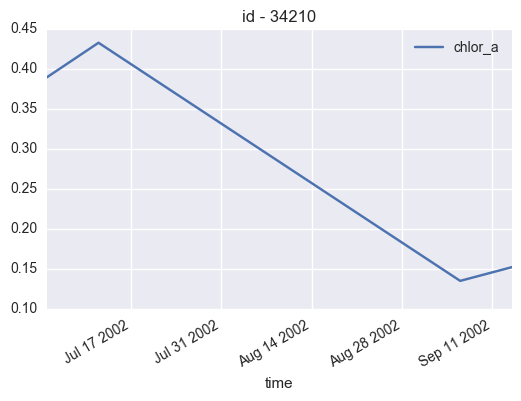

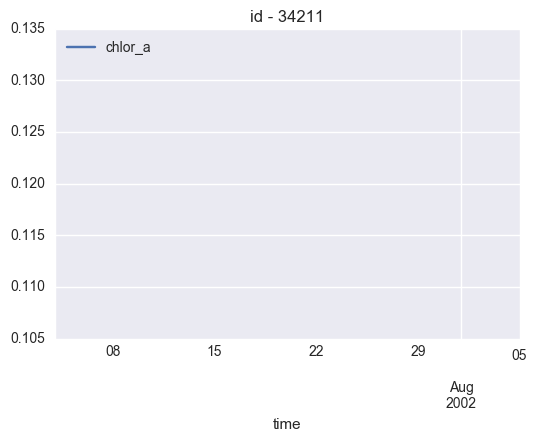

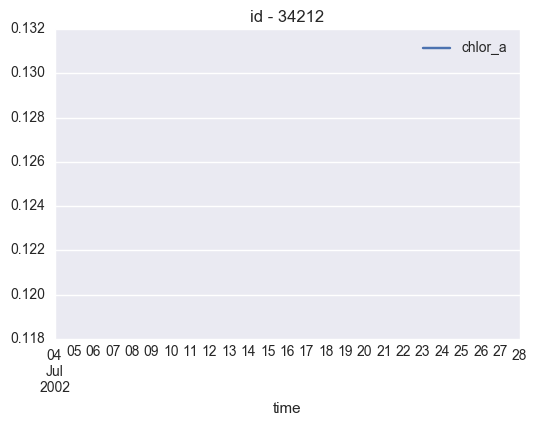

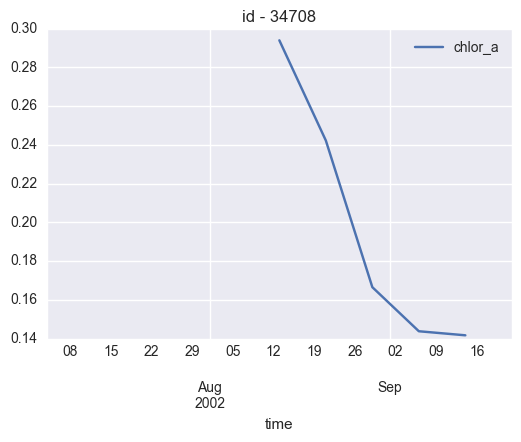

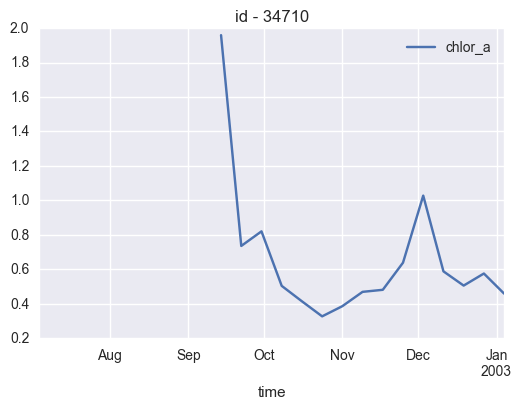

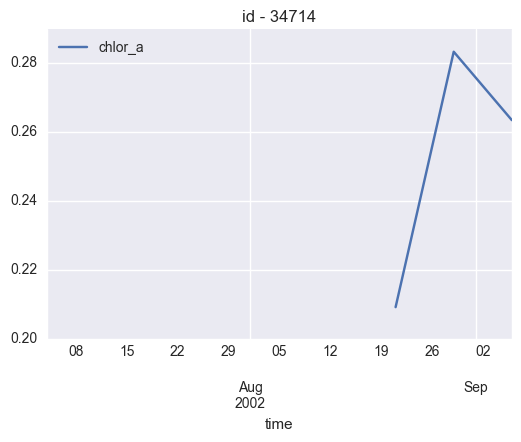

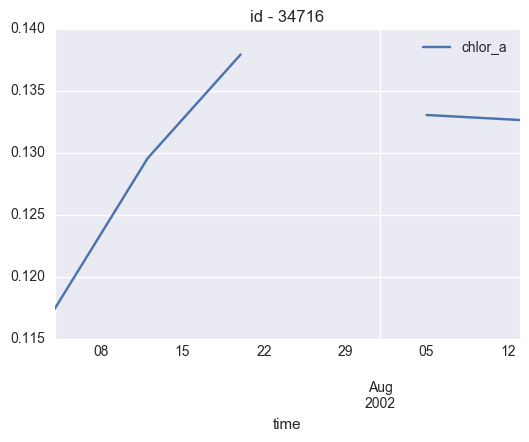

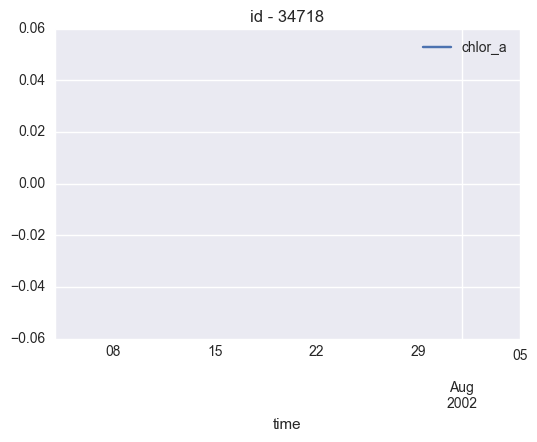

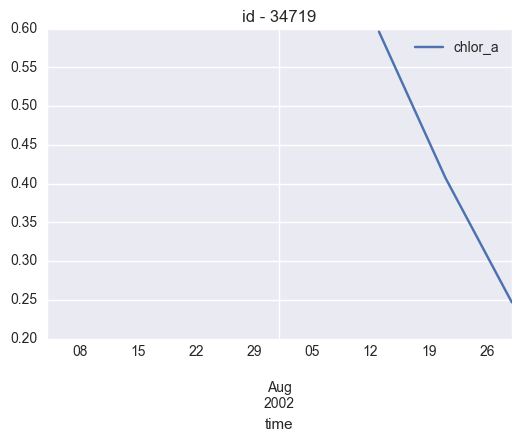

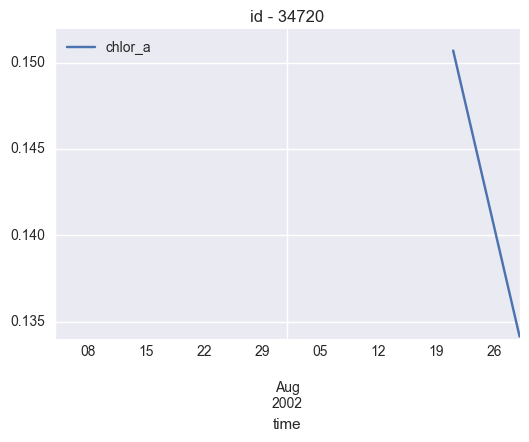

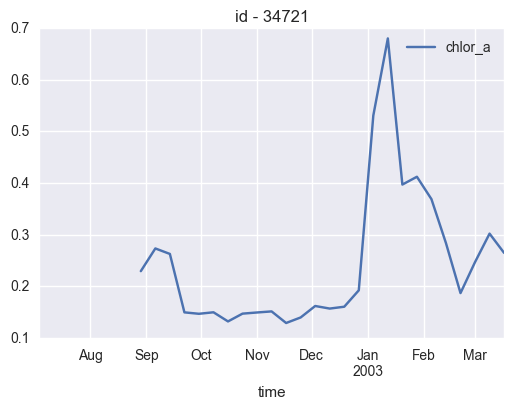

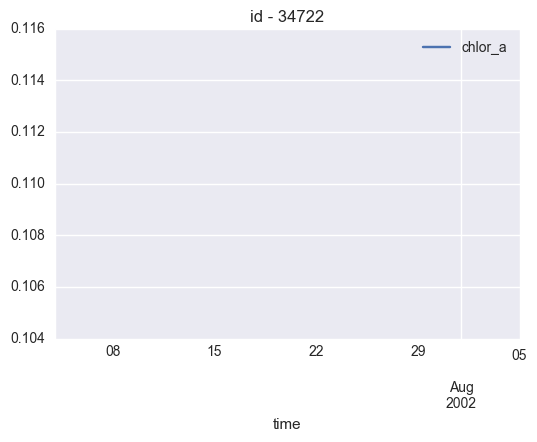

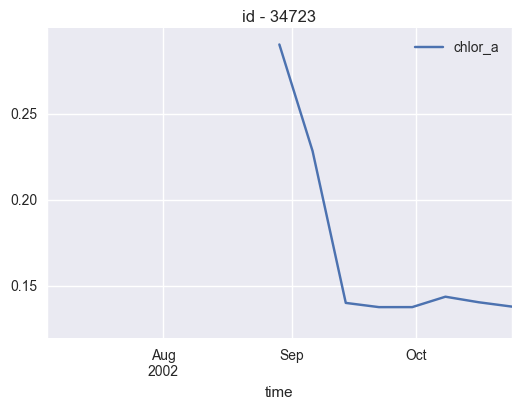

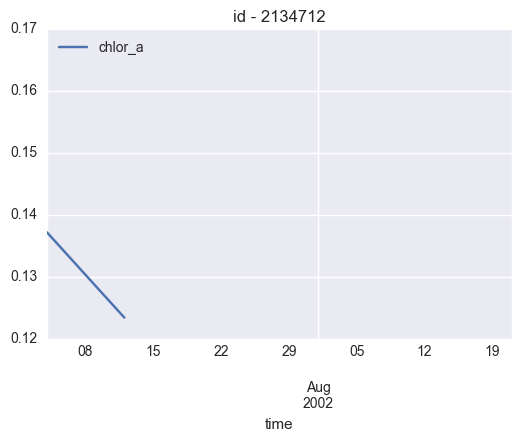

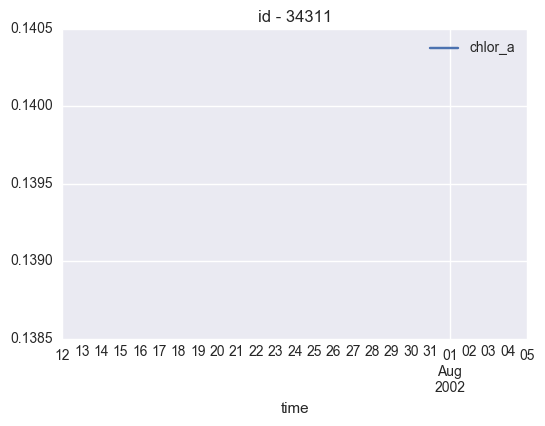

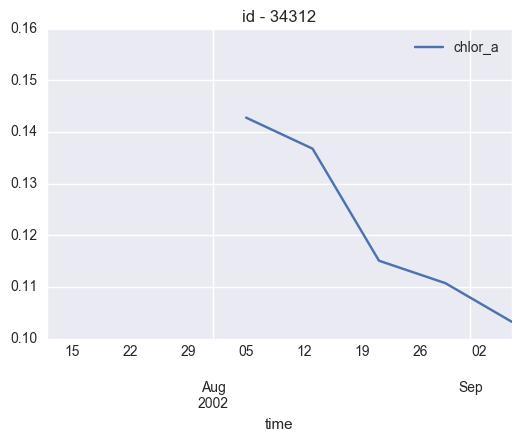

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=731043.0, right=731043.0
  'left=%s, right=%s') % (left, right))


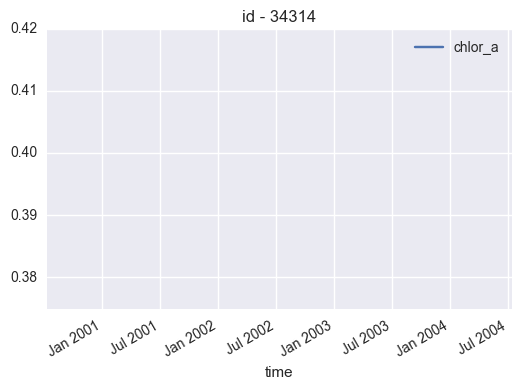

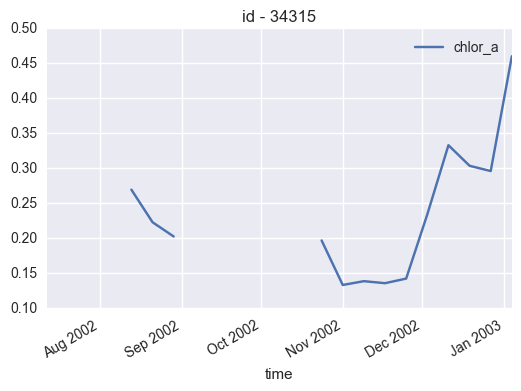

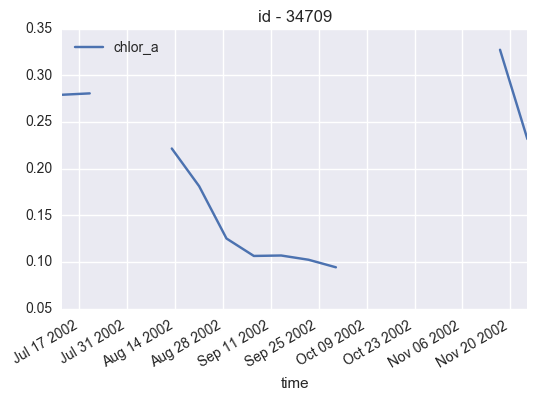

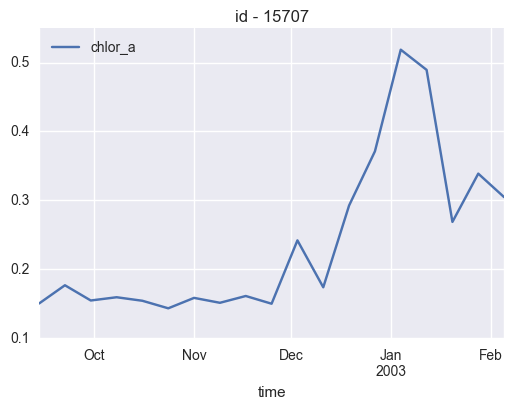

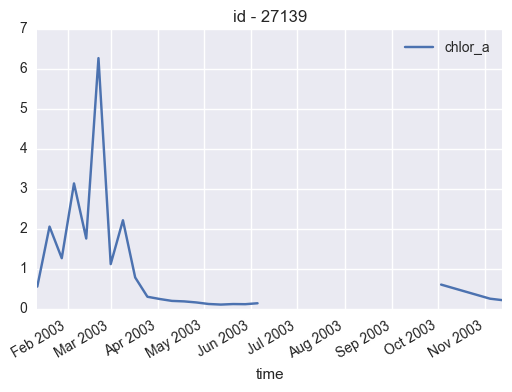

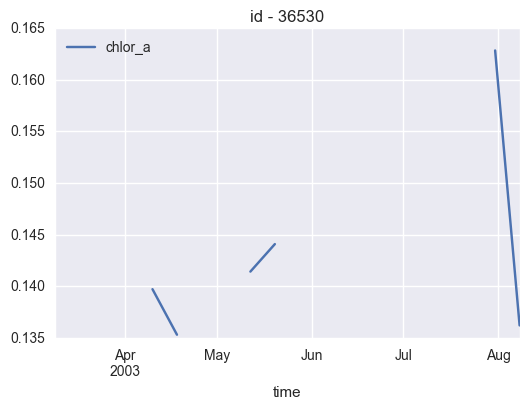

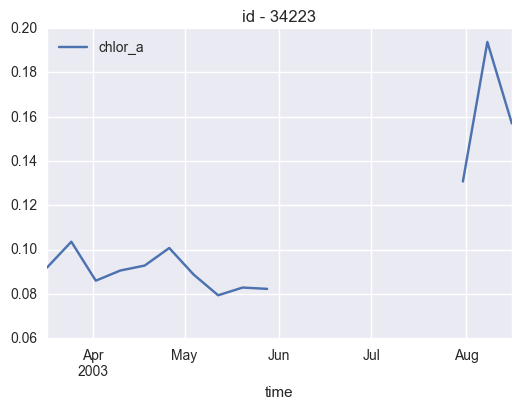

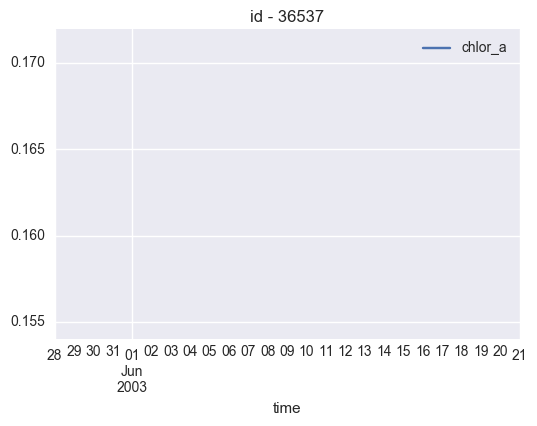

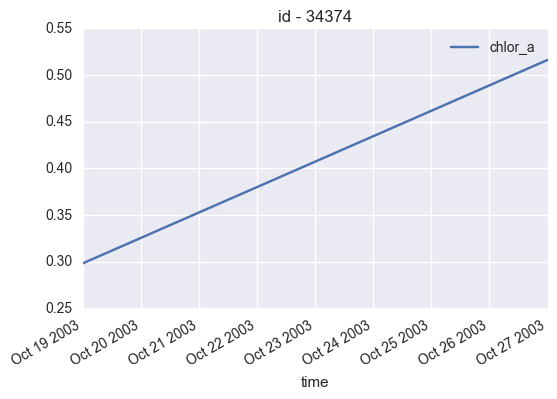

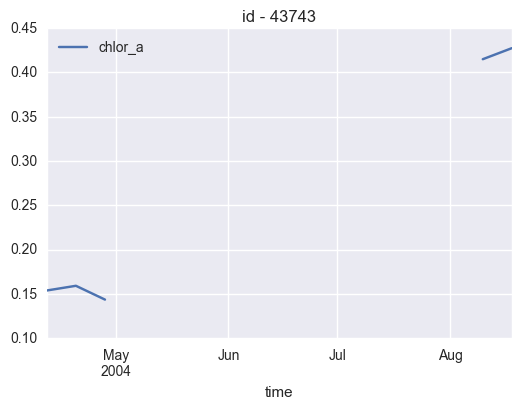

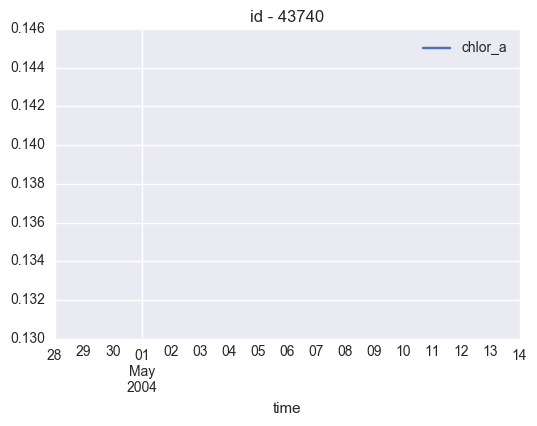

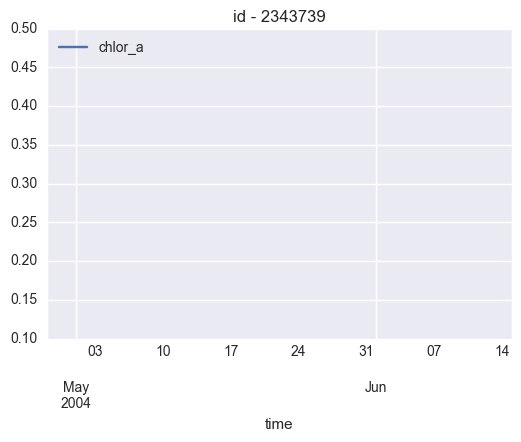

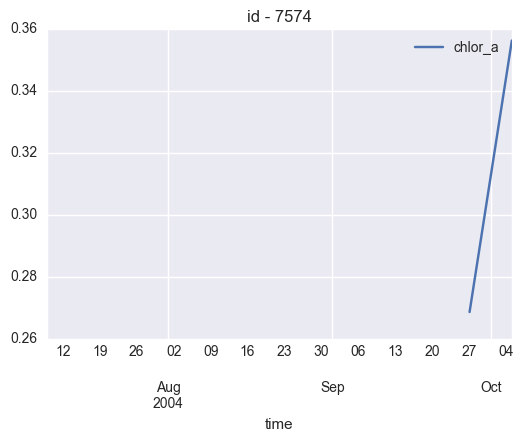

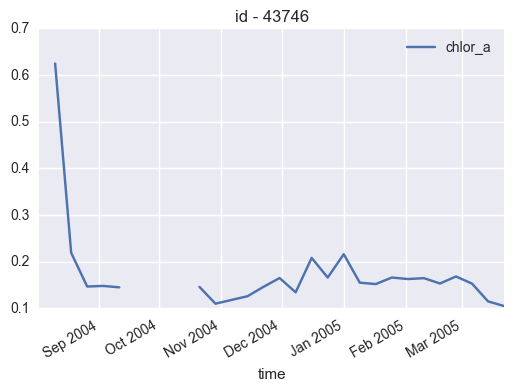

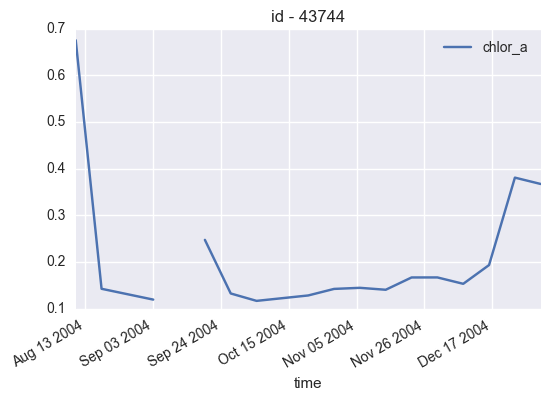

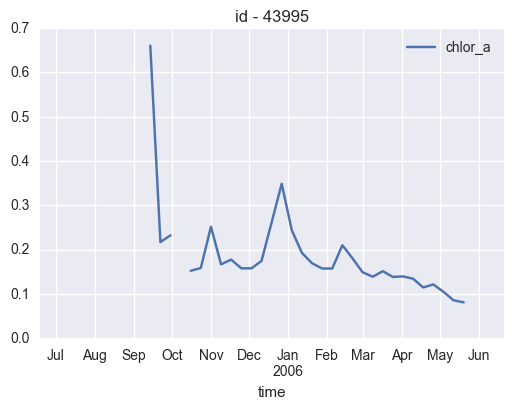

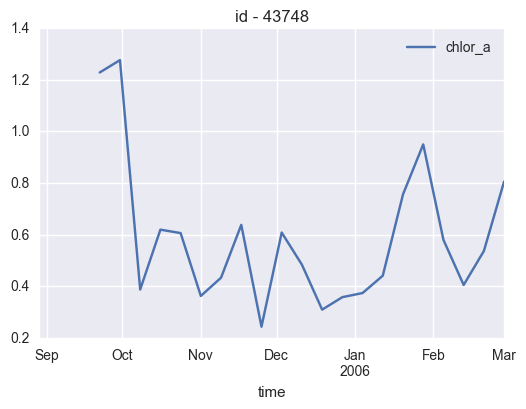

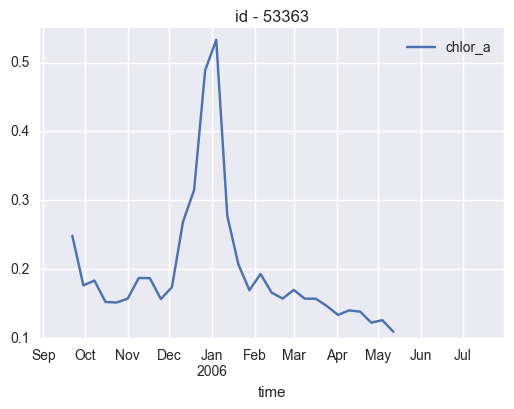

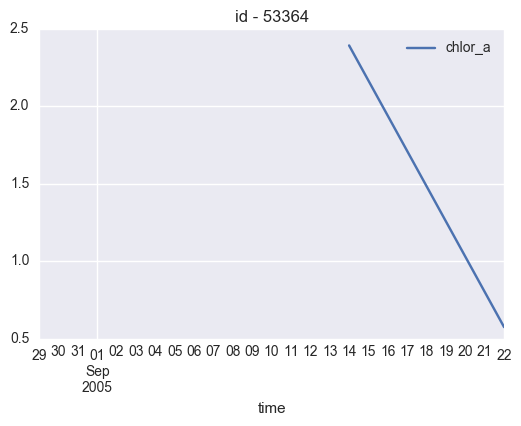

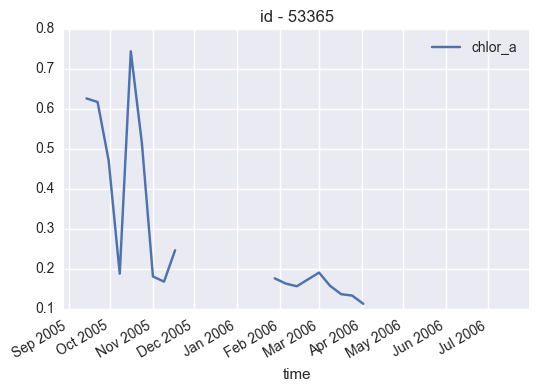

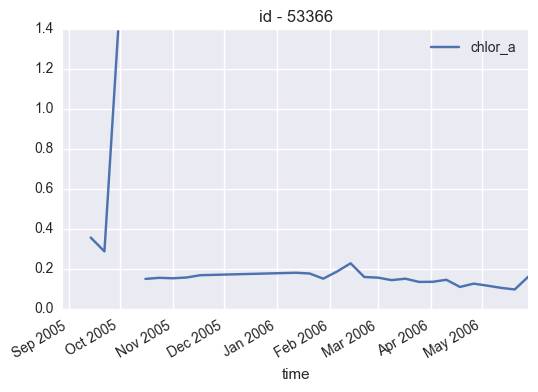

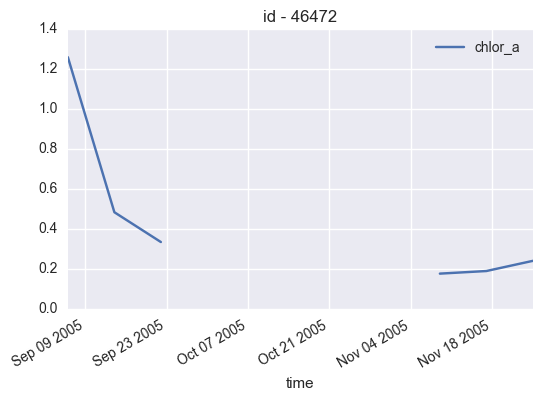

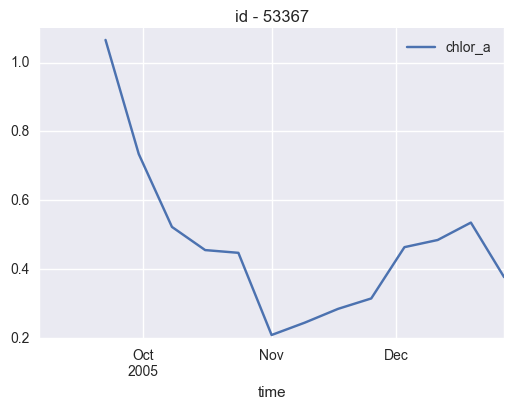

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=732211.0, right=732211.0
  'left=%s, right=%s') % (left, right))


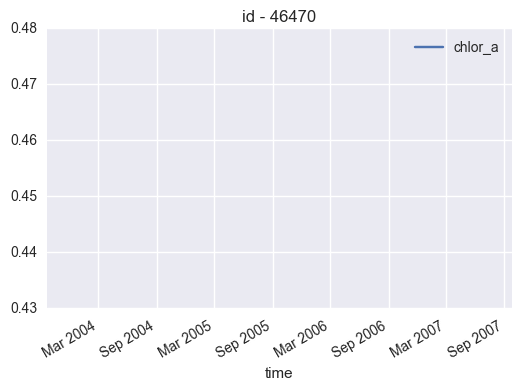

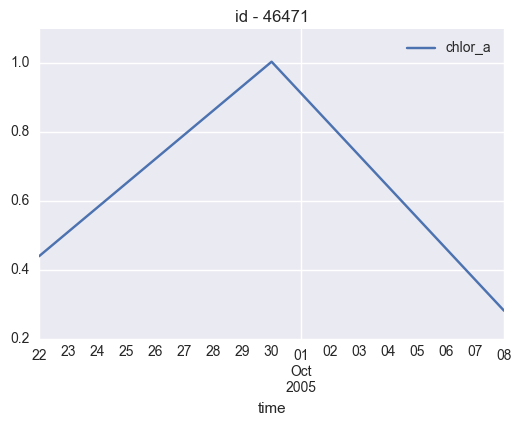

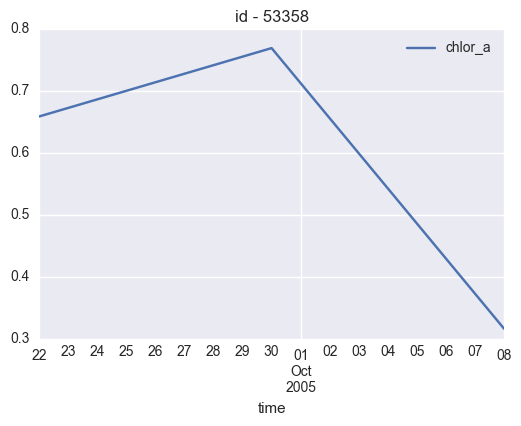

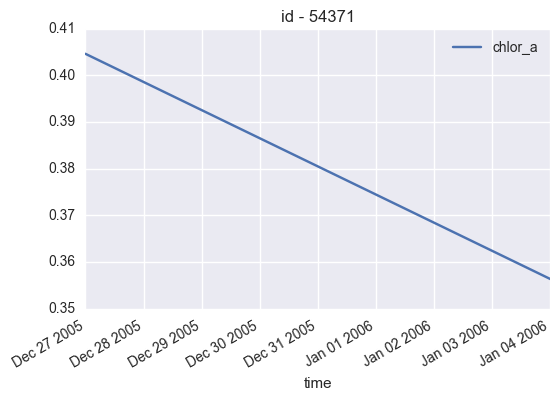

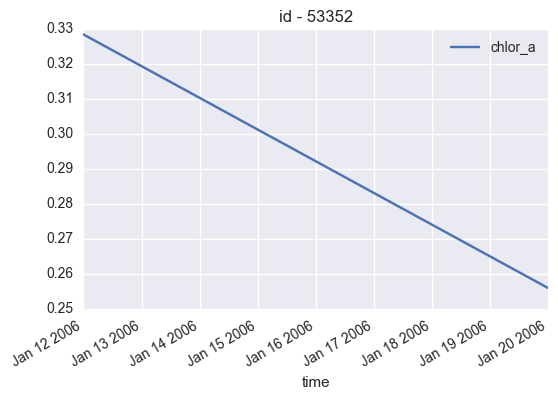

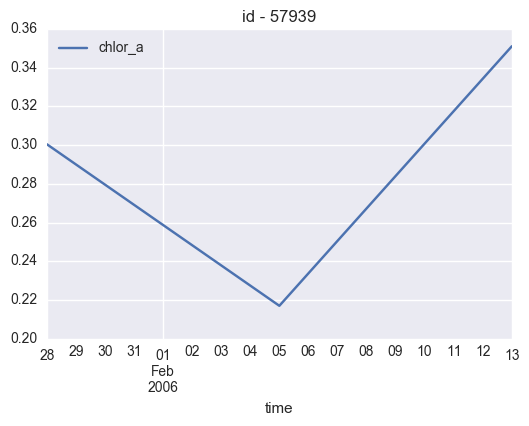

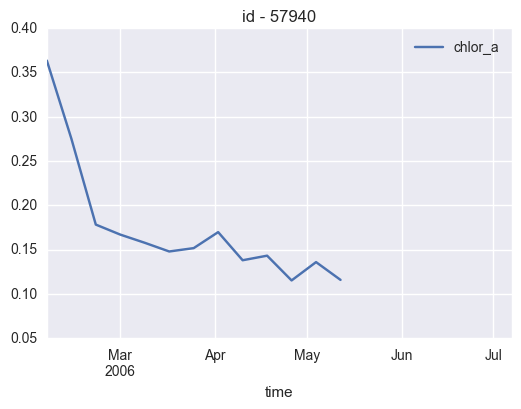

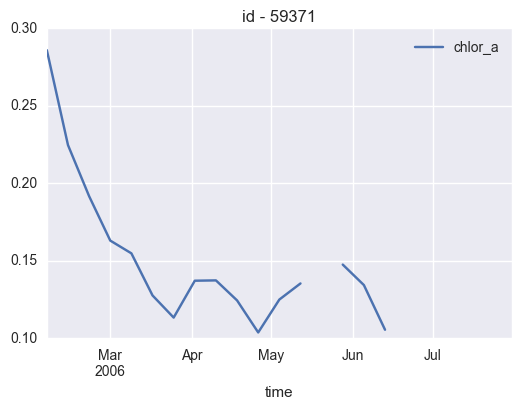

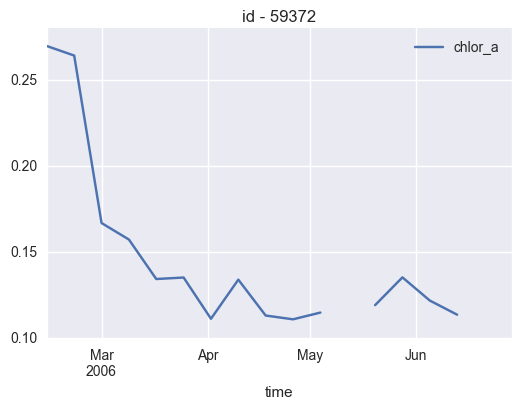

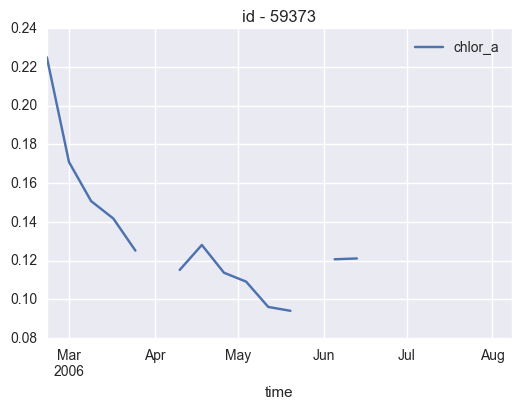

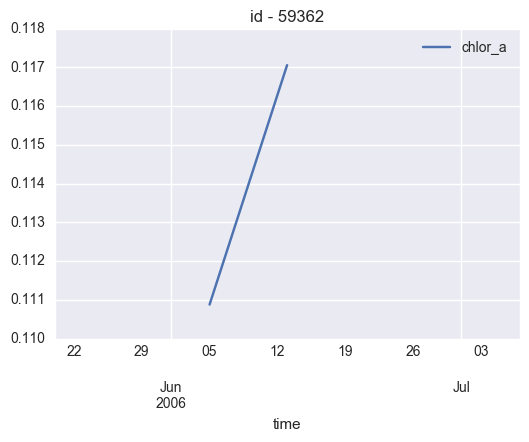

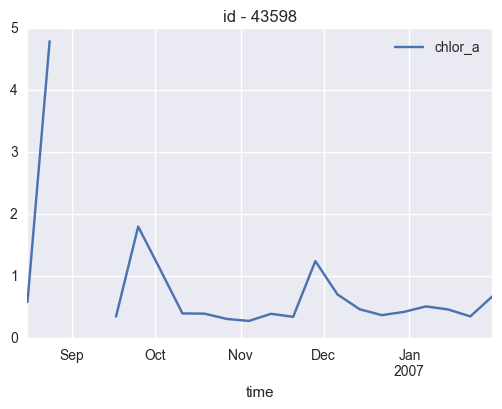

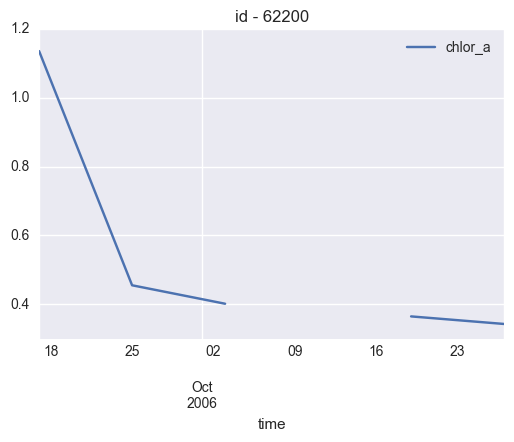

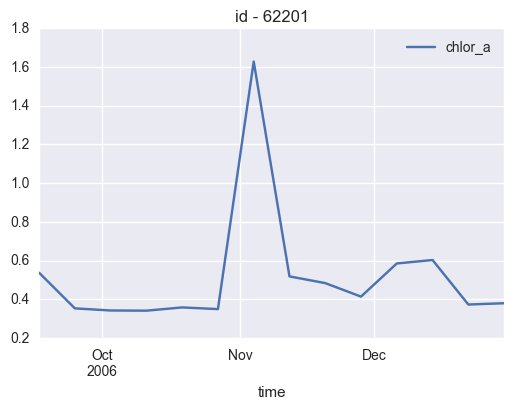

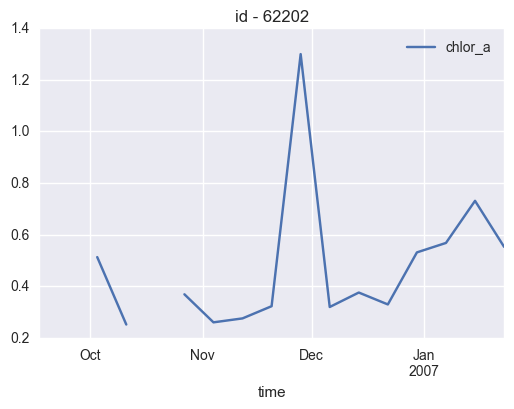

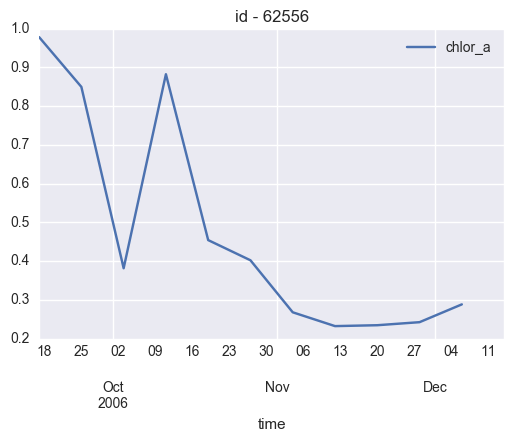

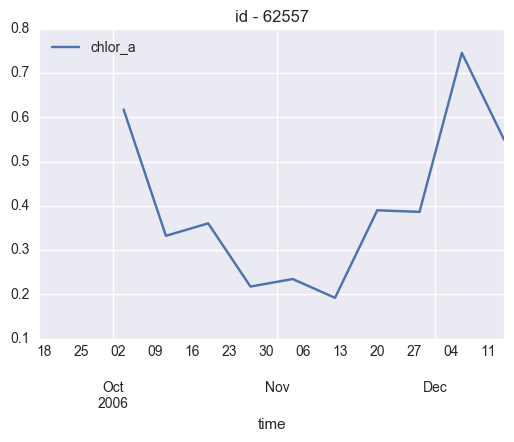

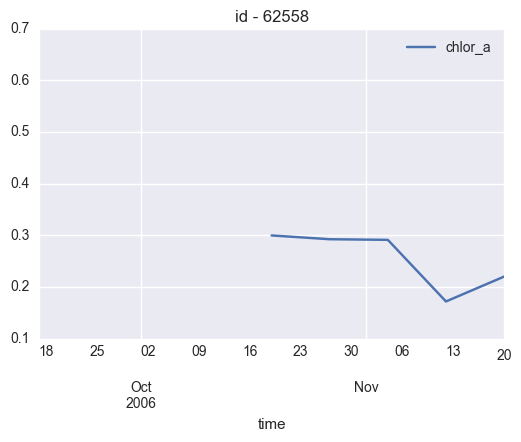

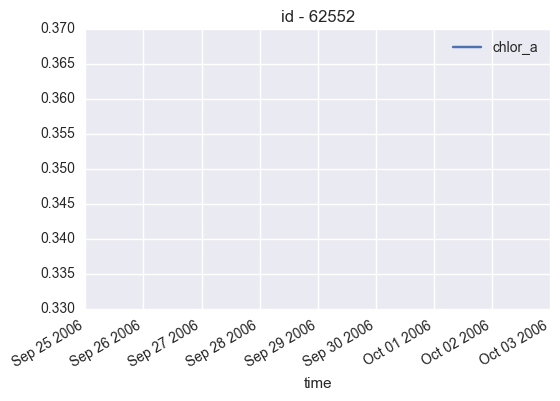

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=732587.0, right=732587.0
  'left=%s, right=%s') % (left, right))


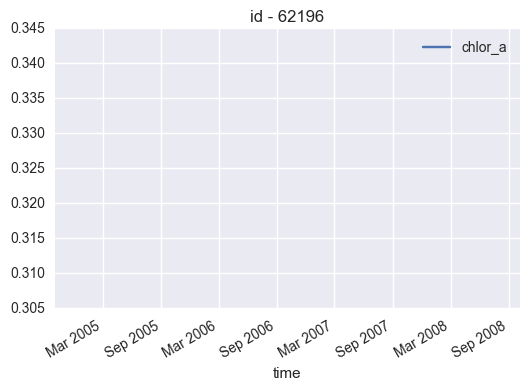

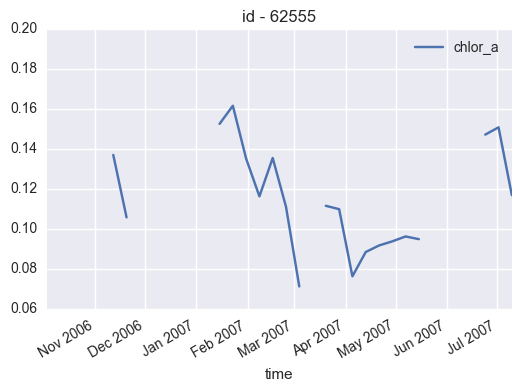

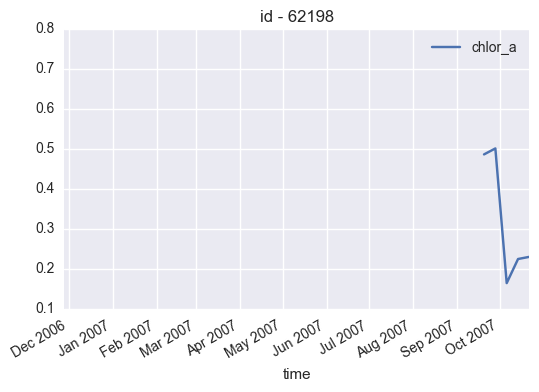

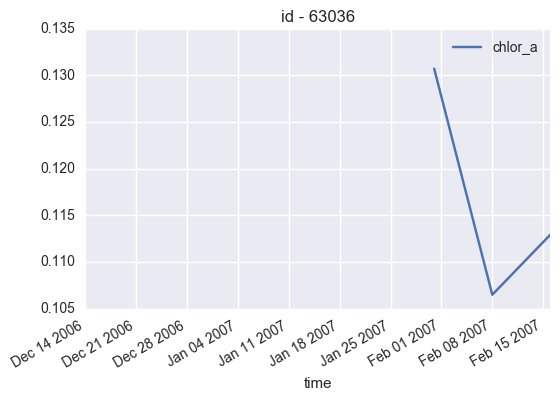

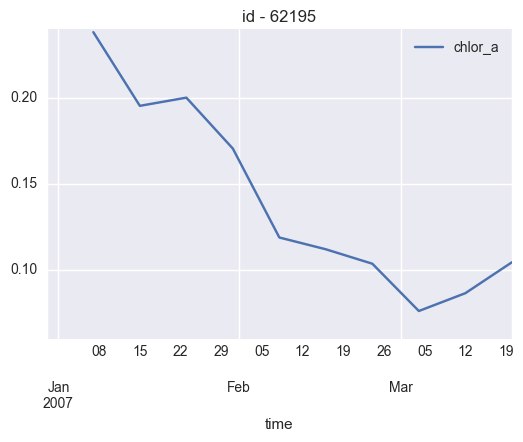

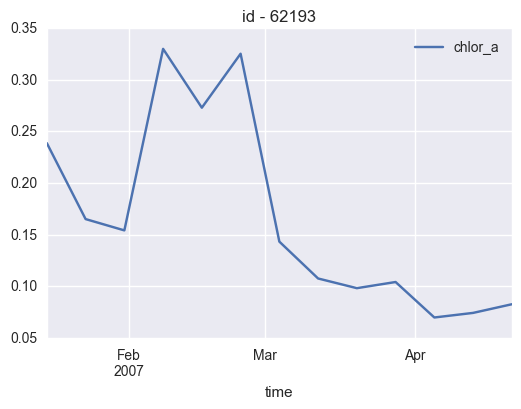

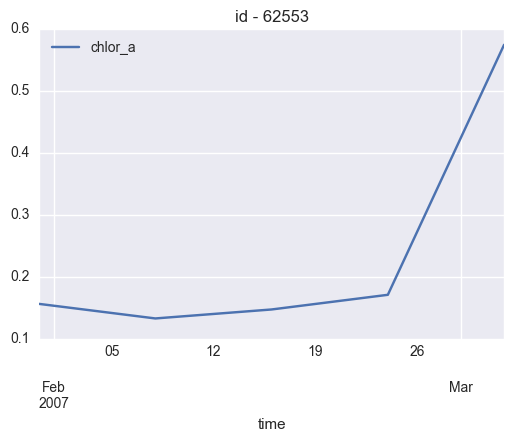

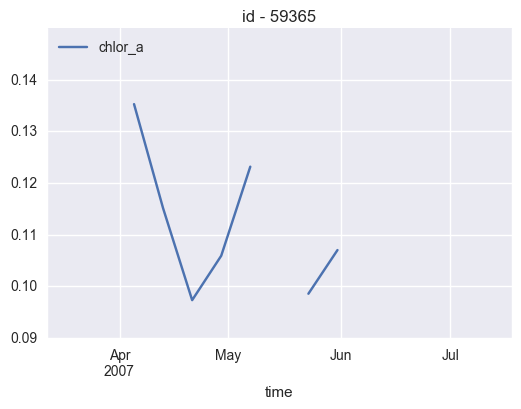

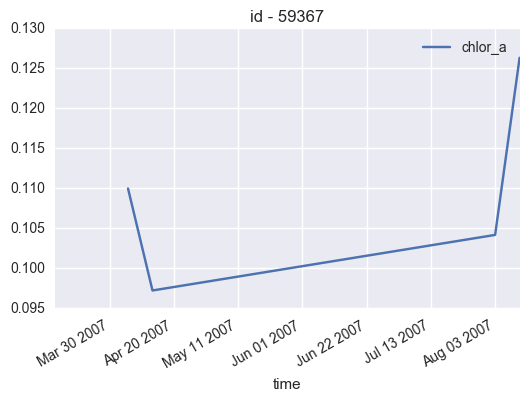

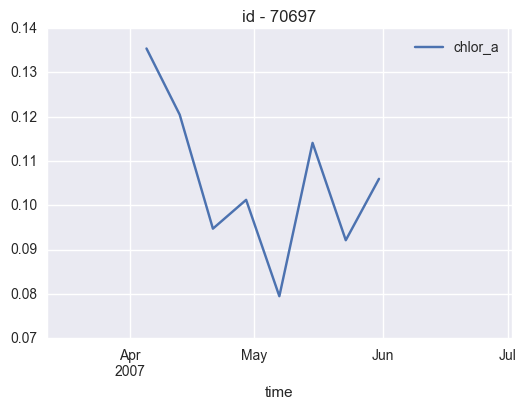

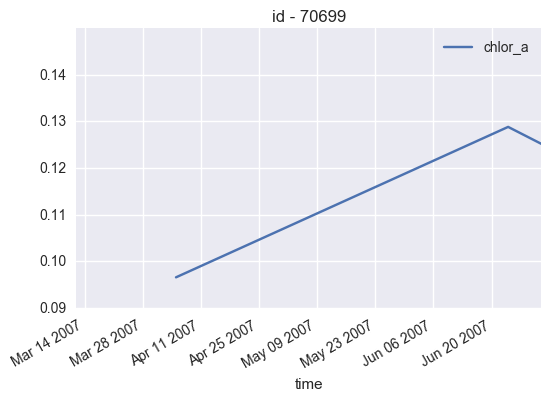

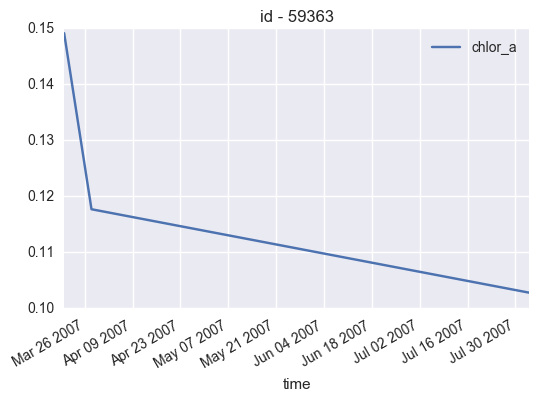

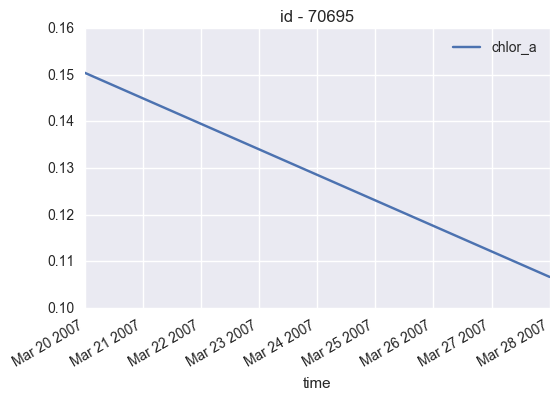

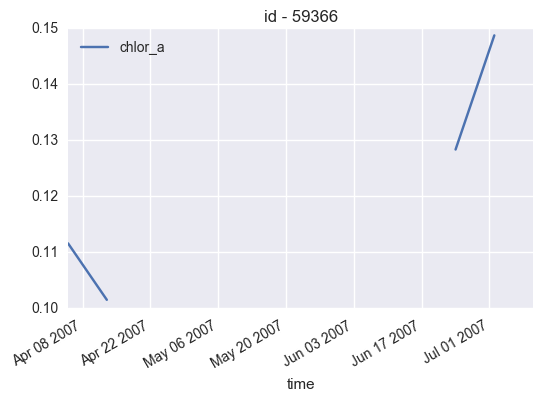

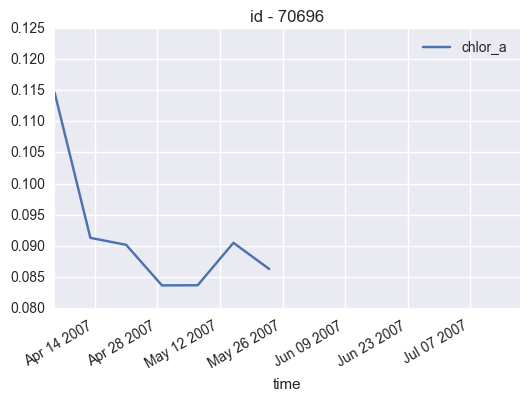

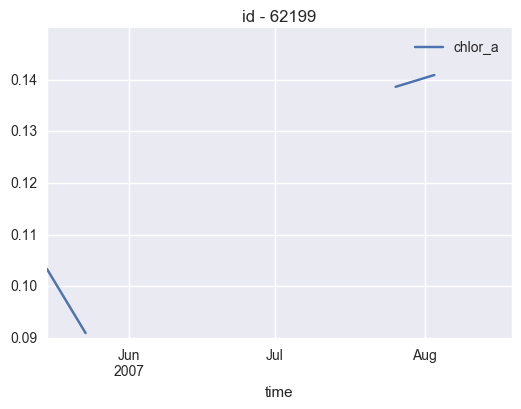

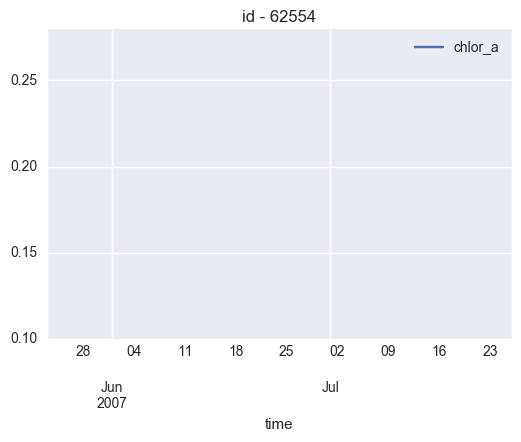

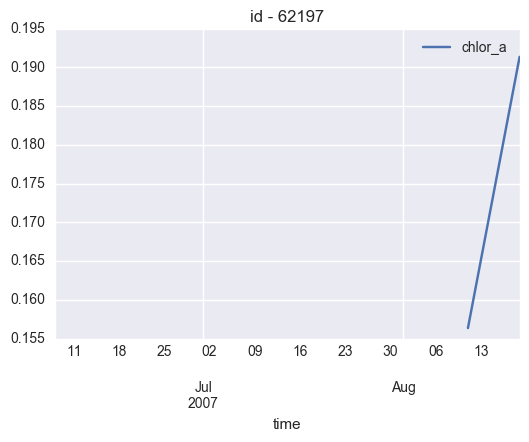

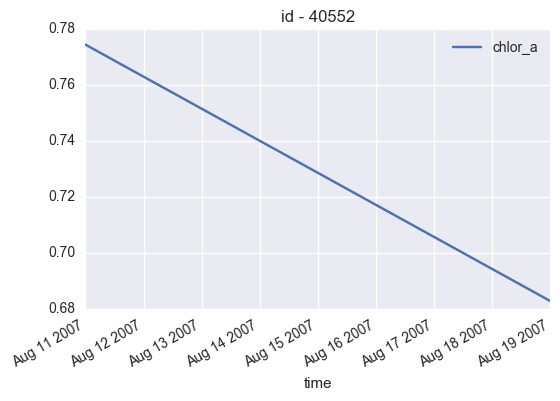

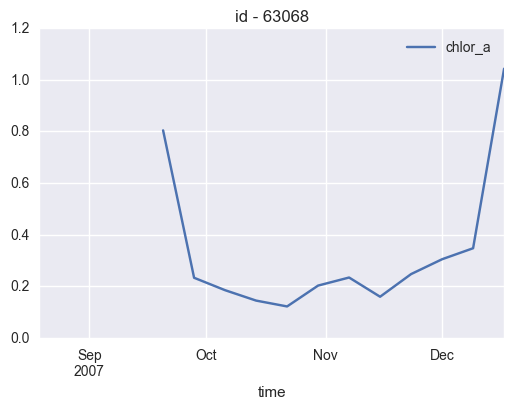

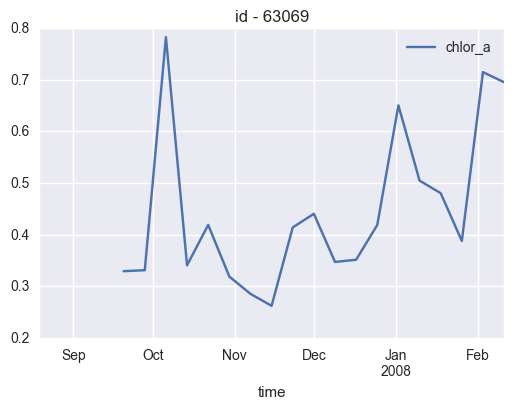

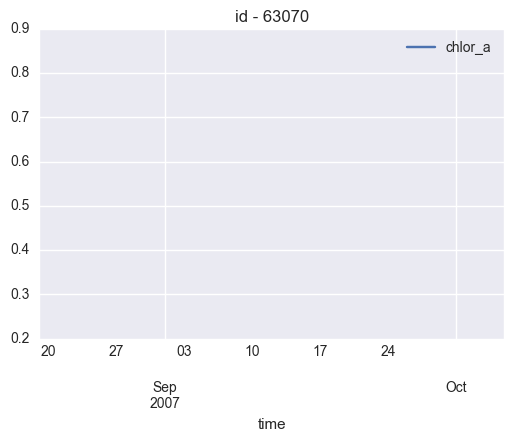

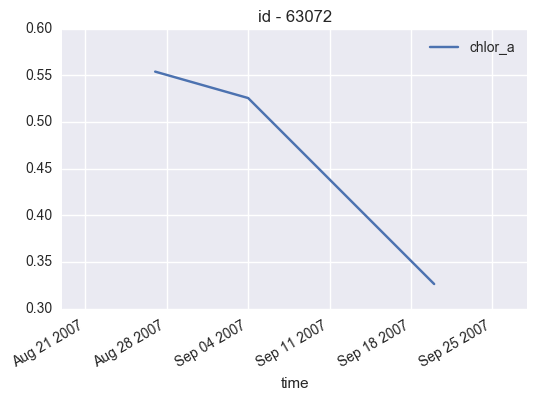

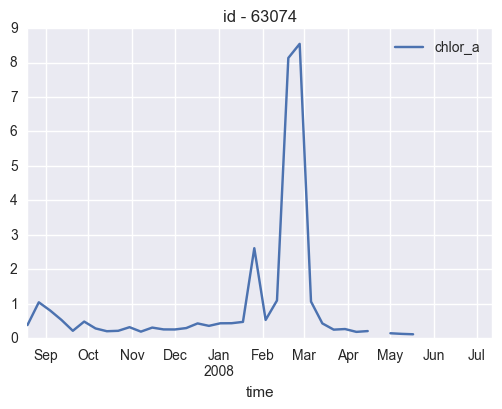

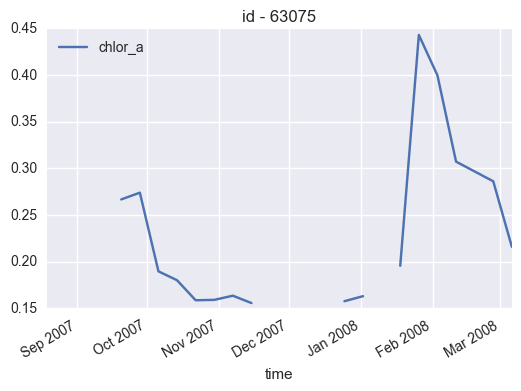

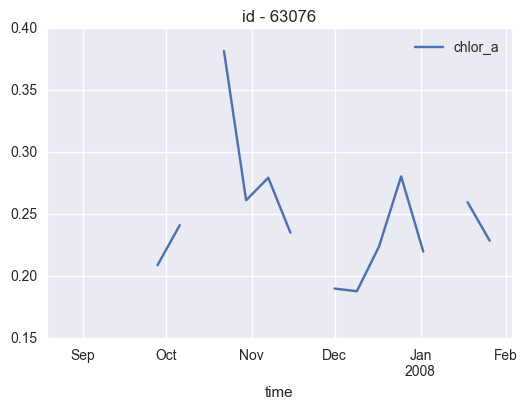

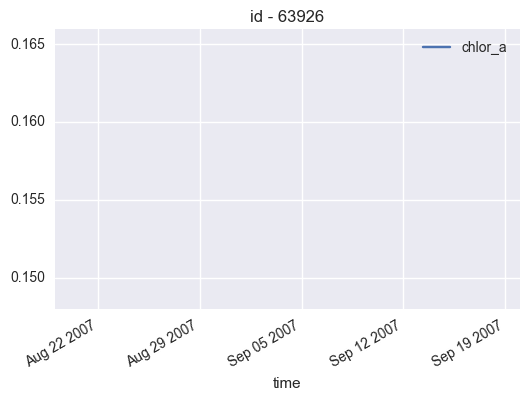

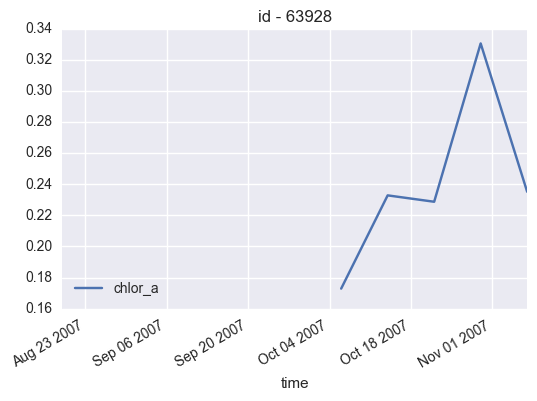

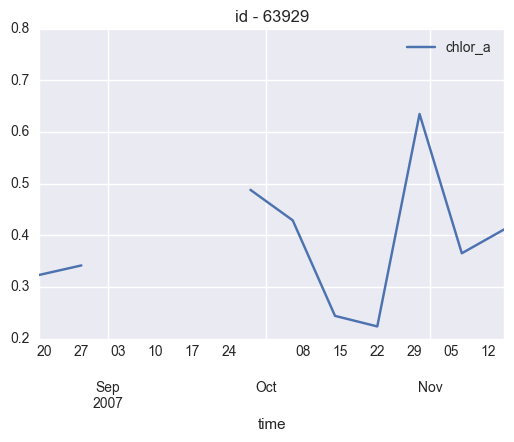

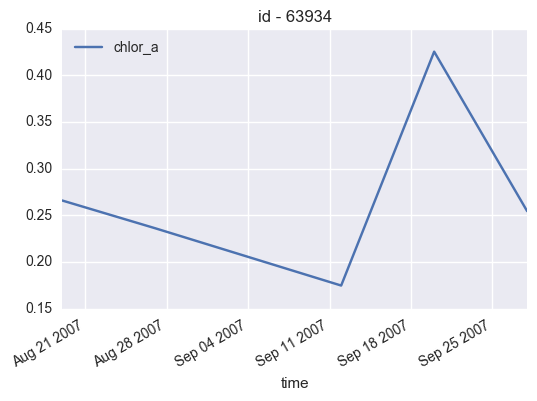

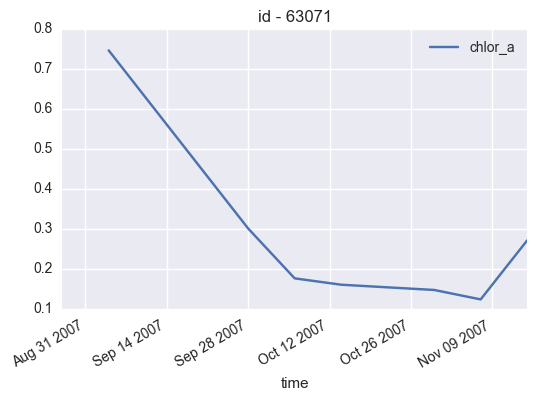

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=732915.0, right=732915.0
  'left=%s, right=%s') % (left, right))


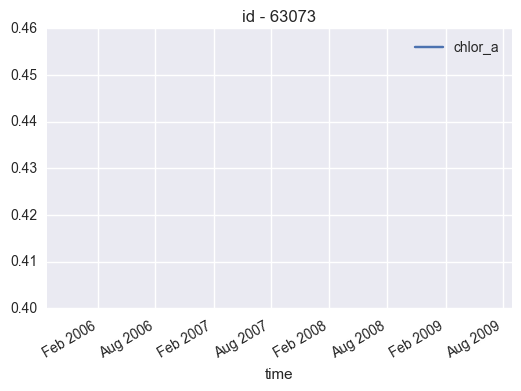

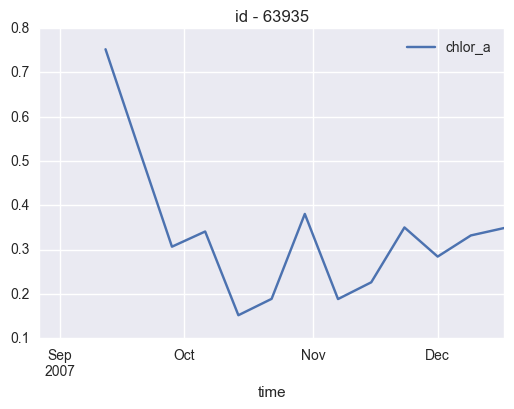

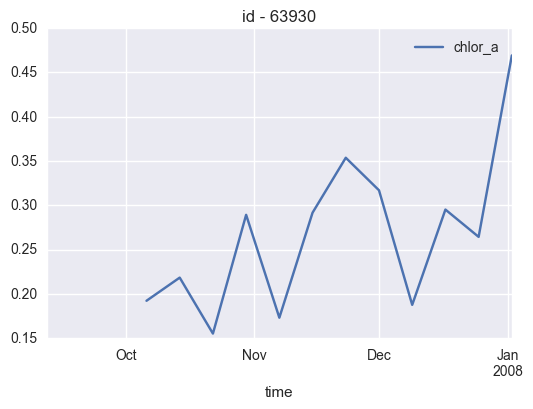

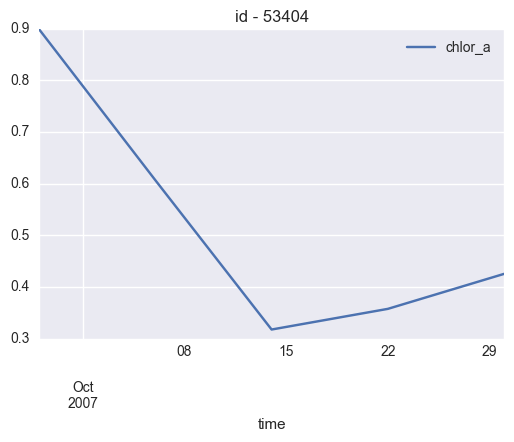

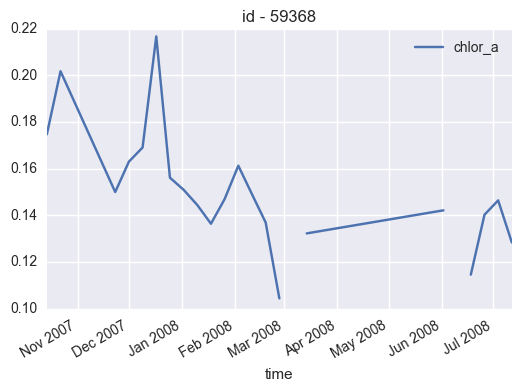

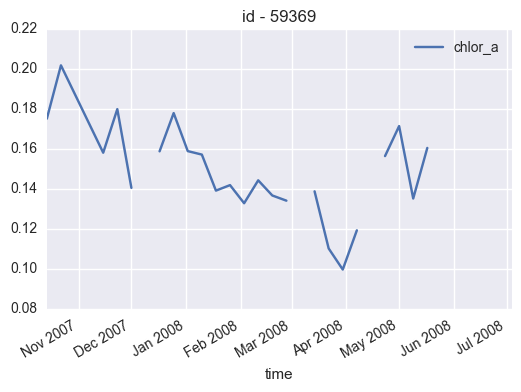

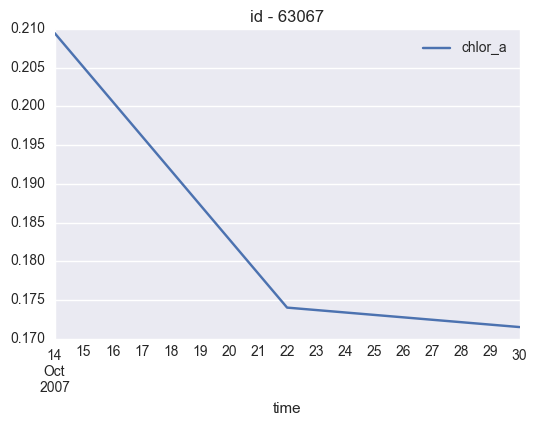

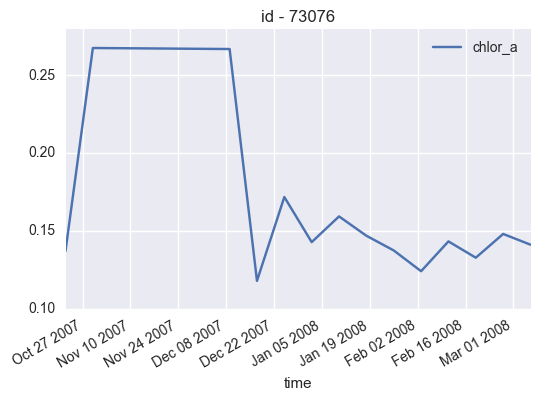

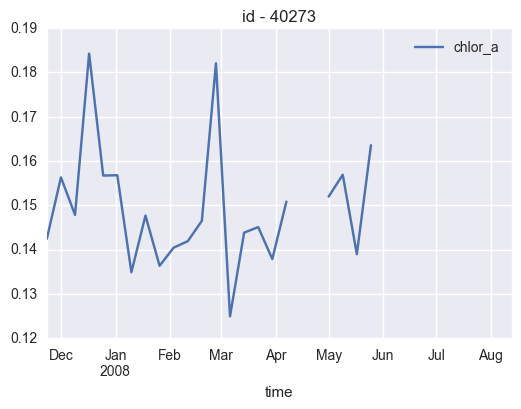

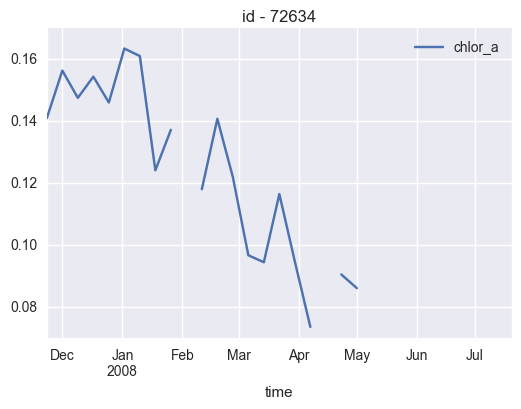

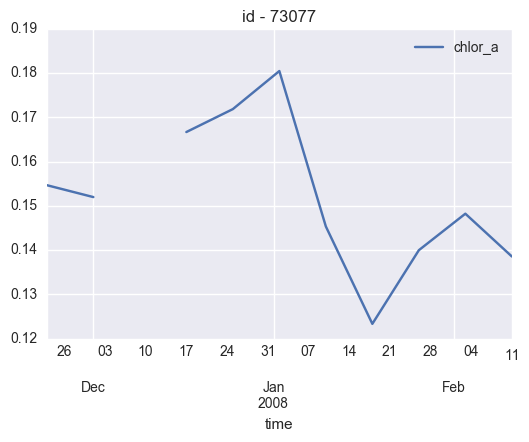

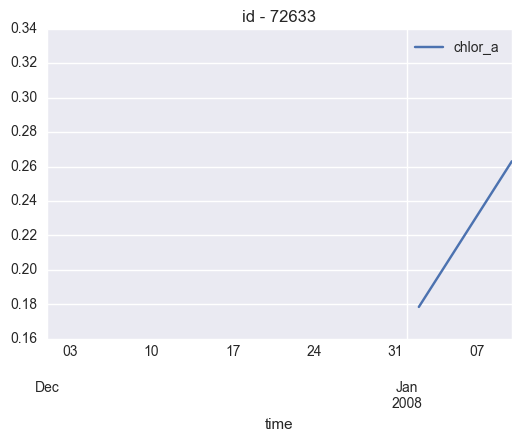

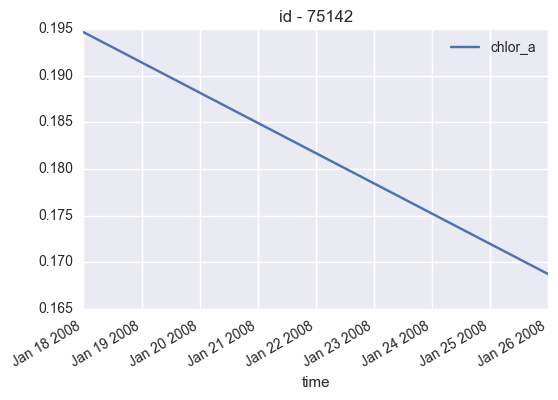

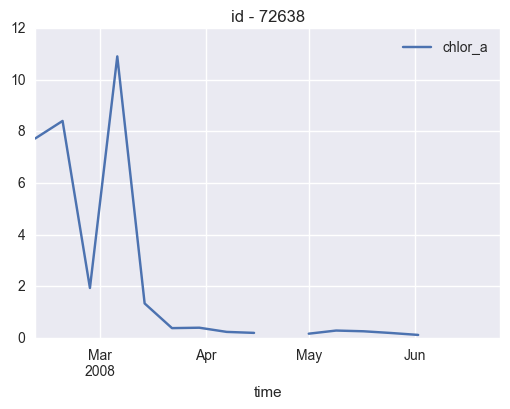

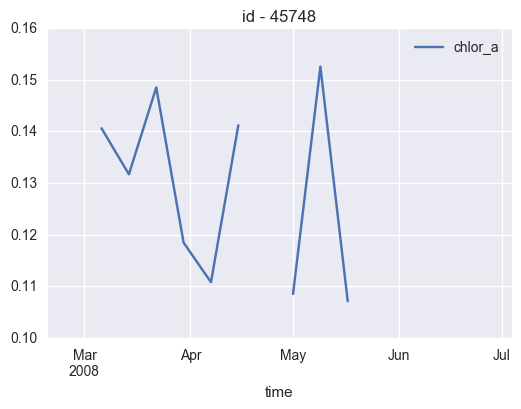

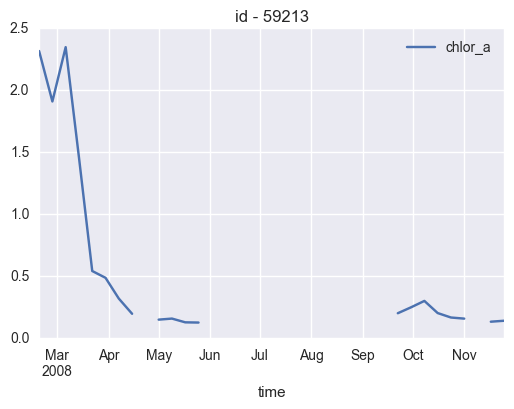

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=733091.0, right=733091.0
  'left=%s, right=%s') % (left, right))


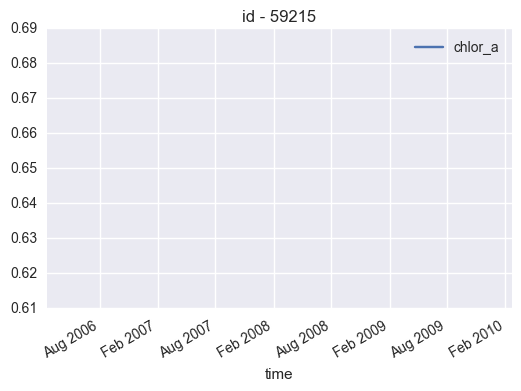

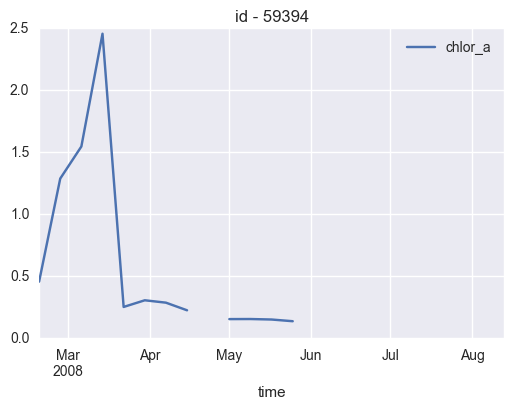

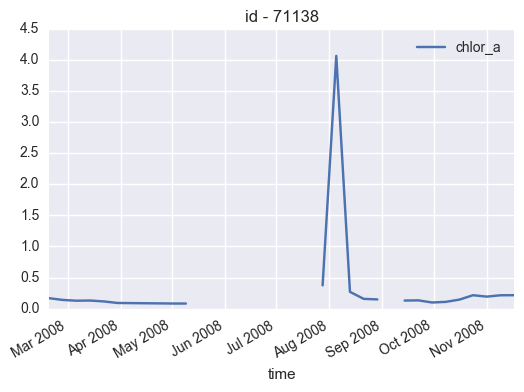

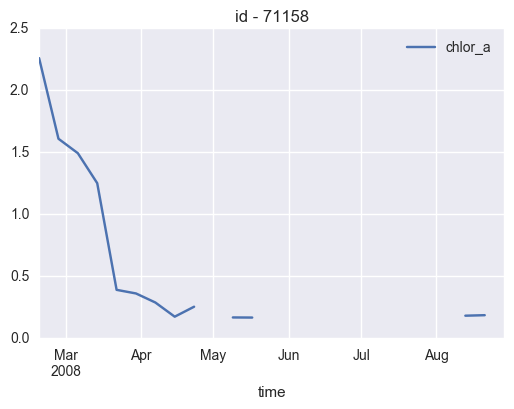

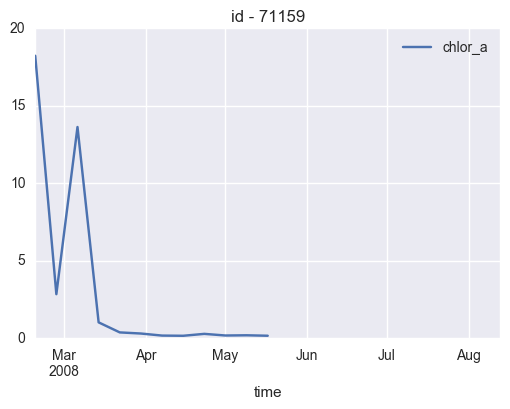

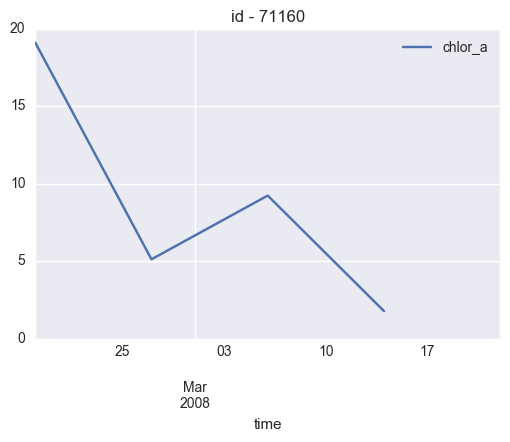

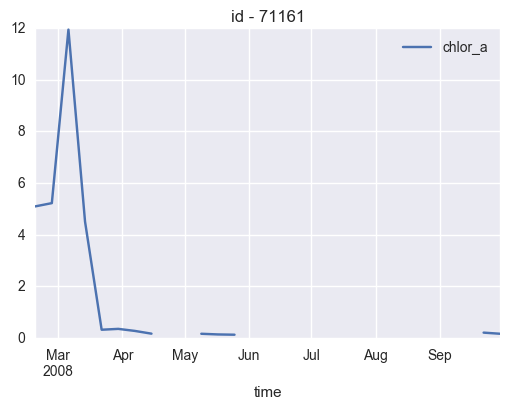

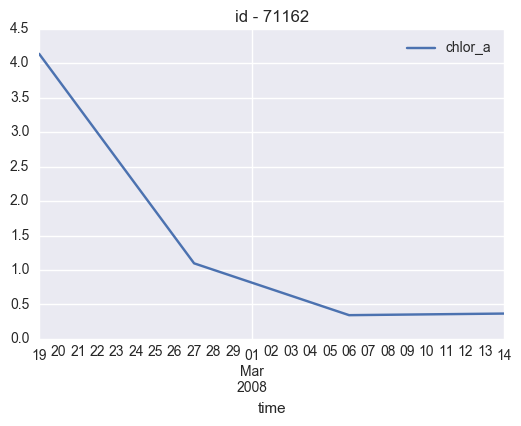

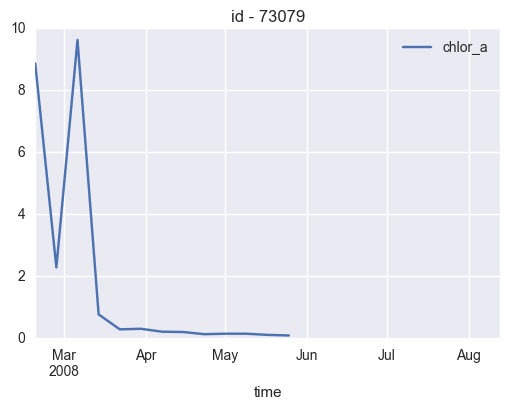

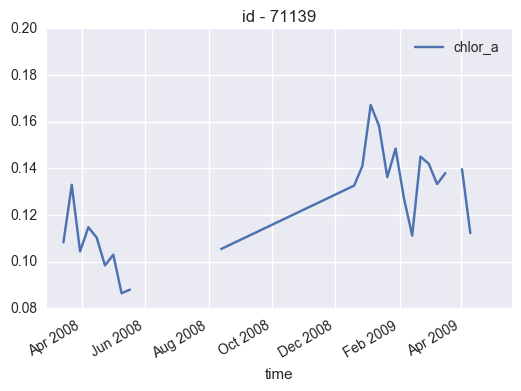

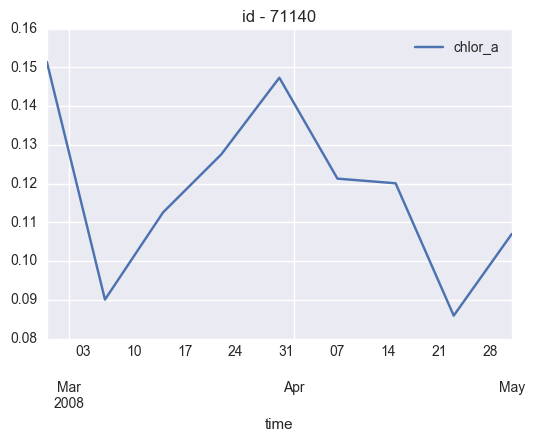

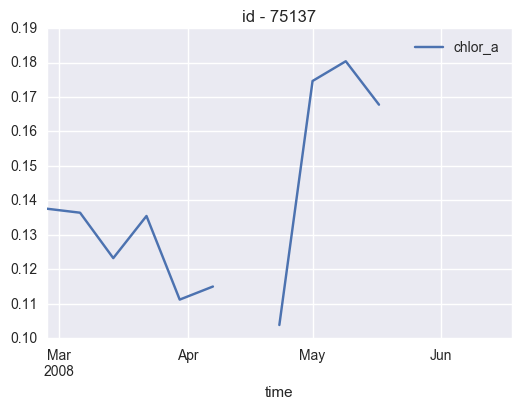

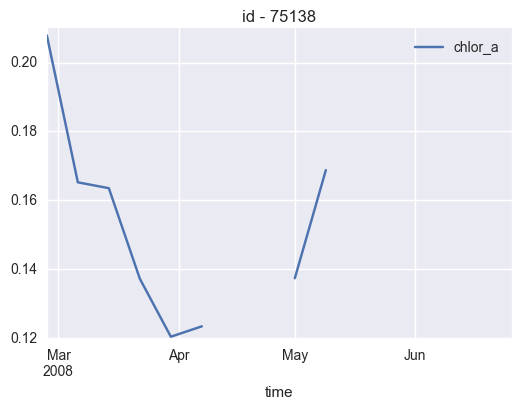

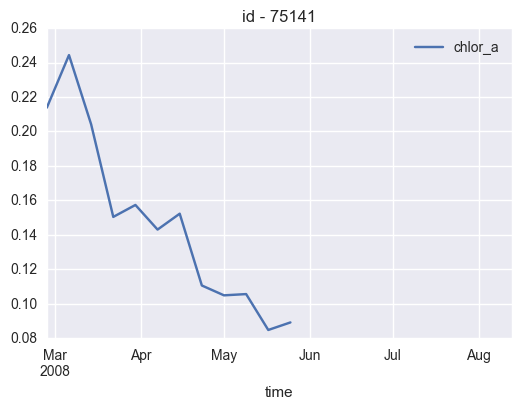

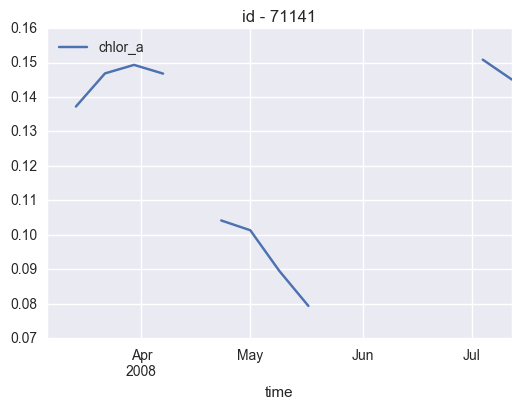

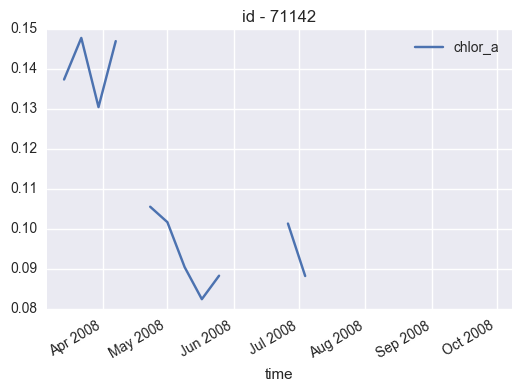

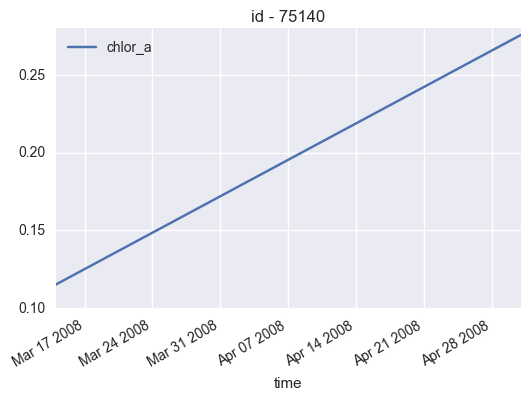

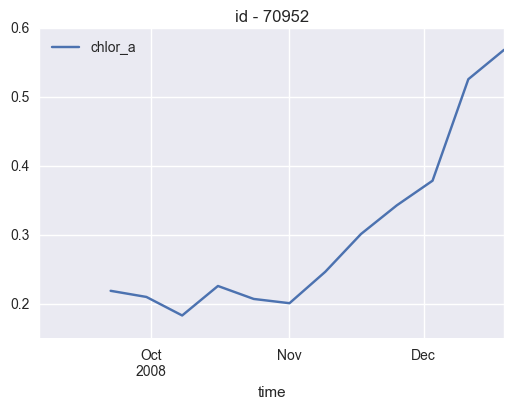

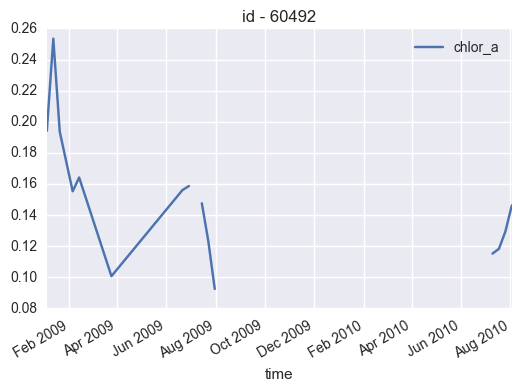

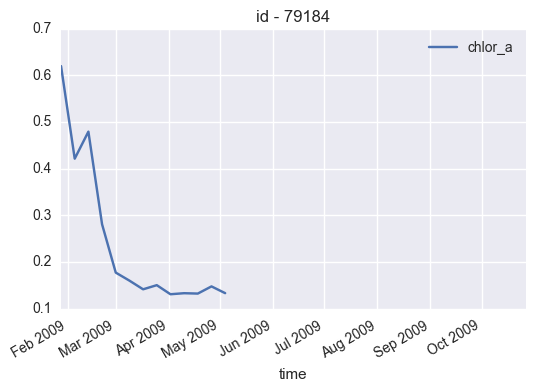

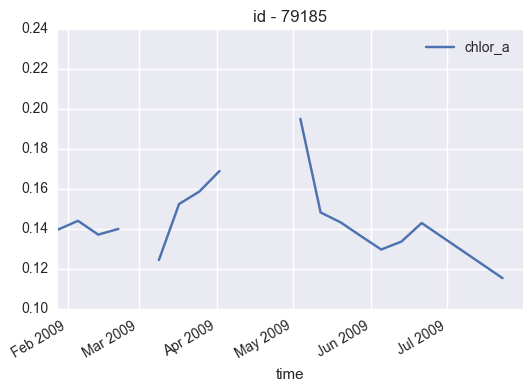

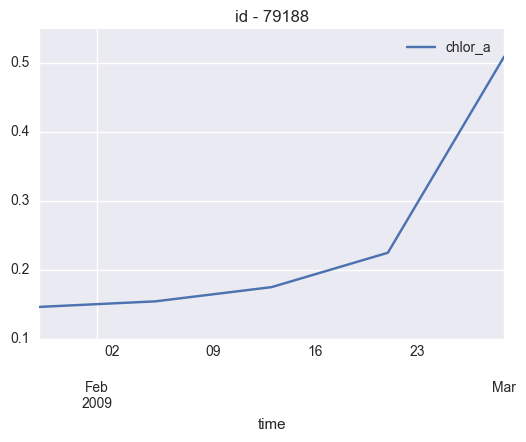

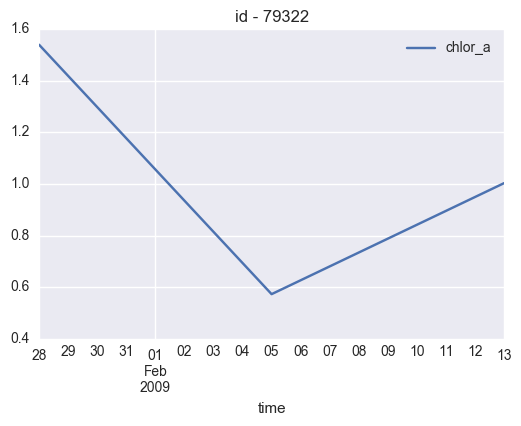

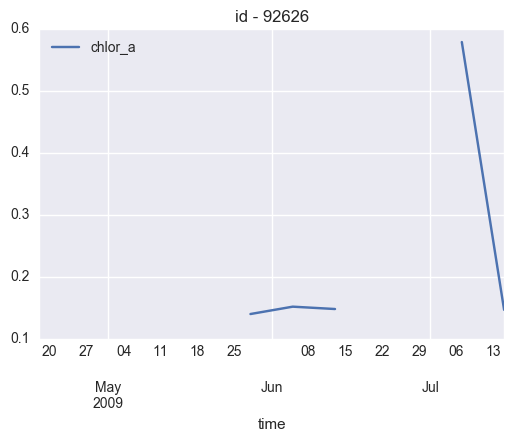

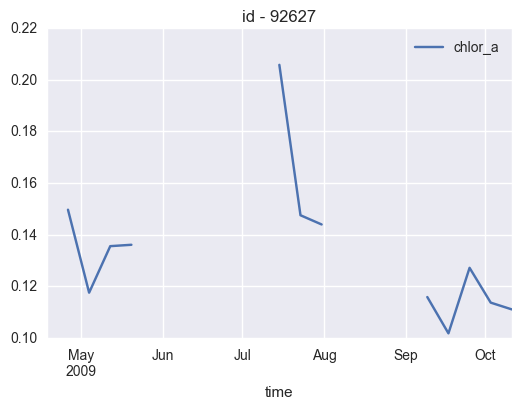

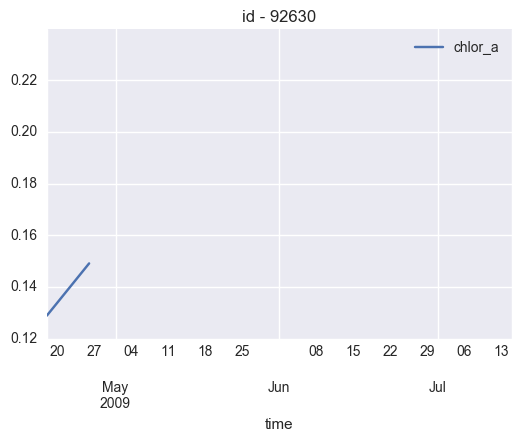

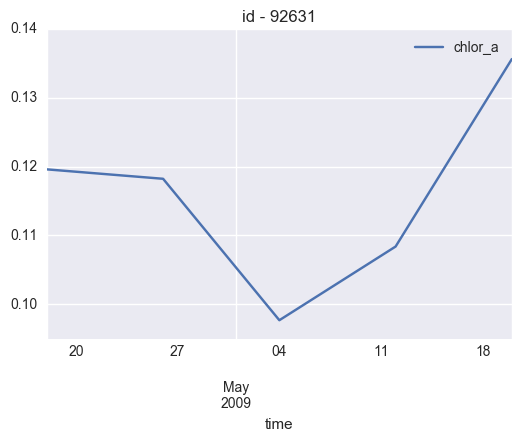

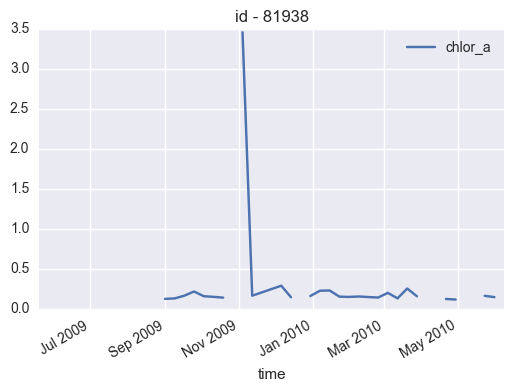

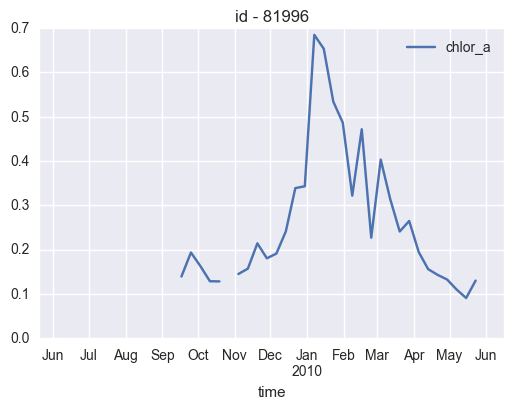

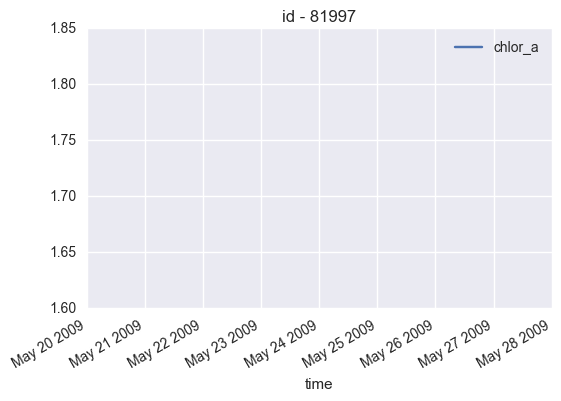

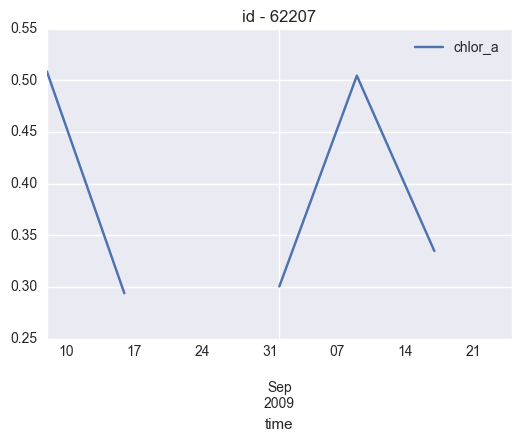

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=733691.0, right=733691.0
  'left=%s, right=%s') % (left, right))


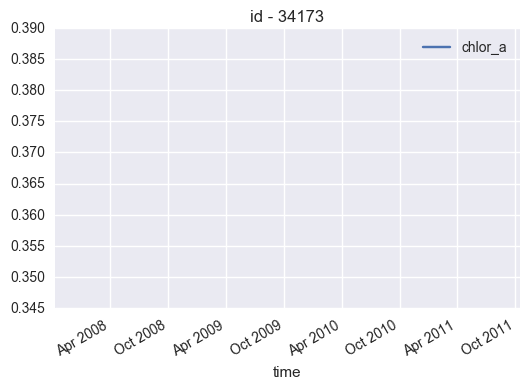

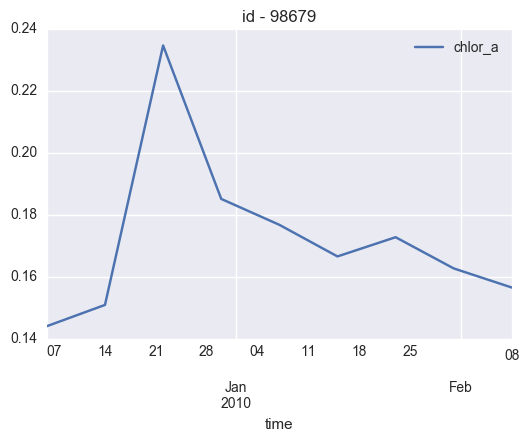

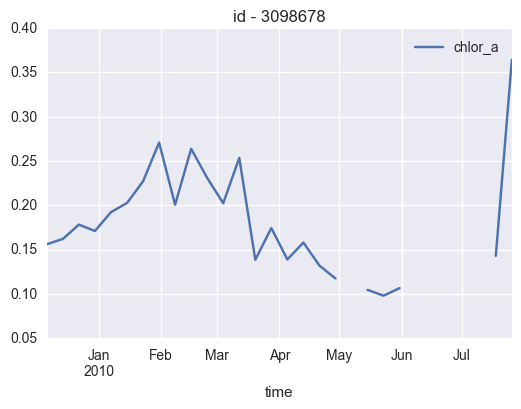

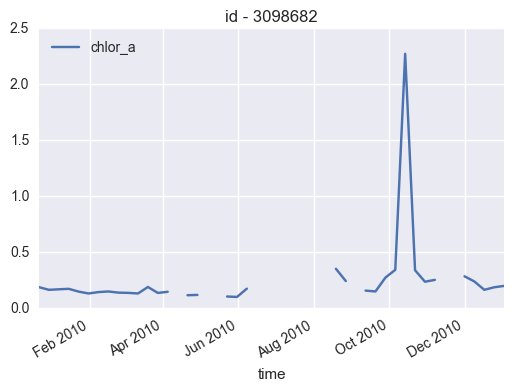

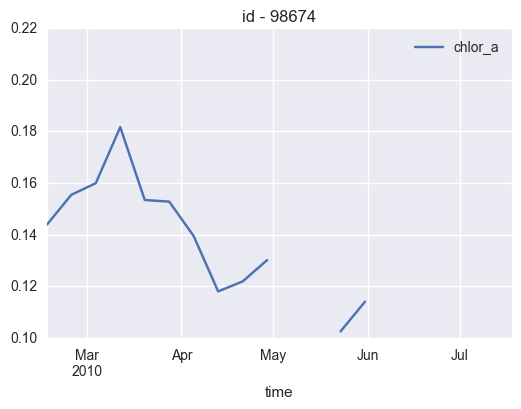

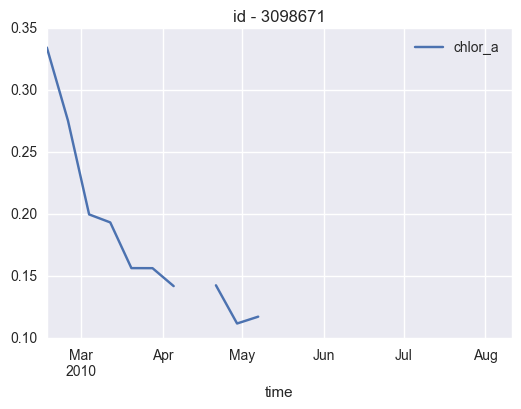

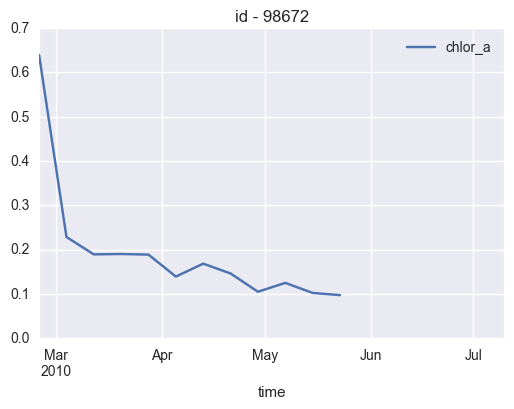

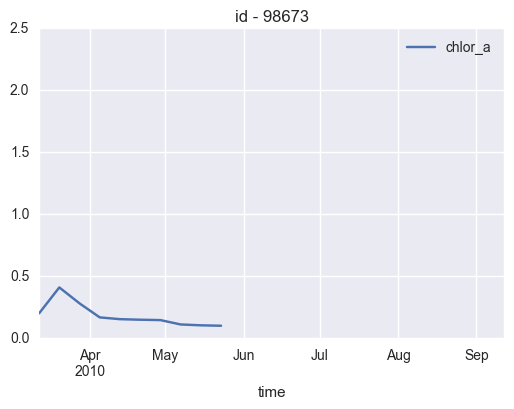

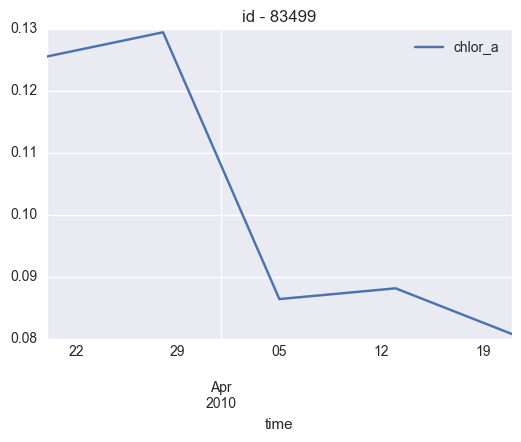

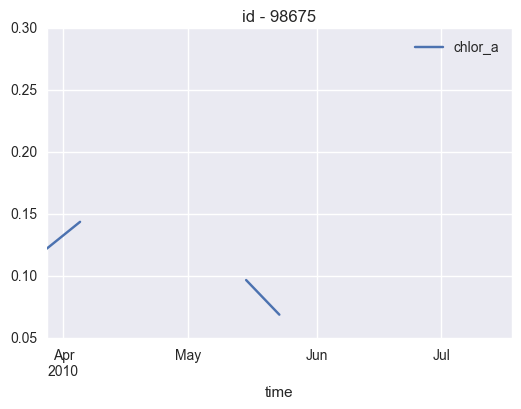

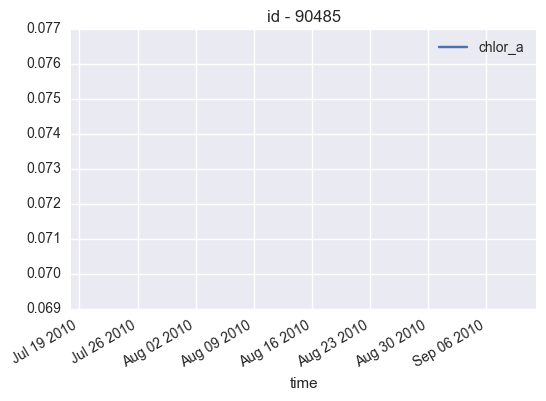

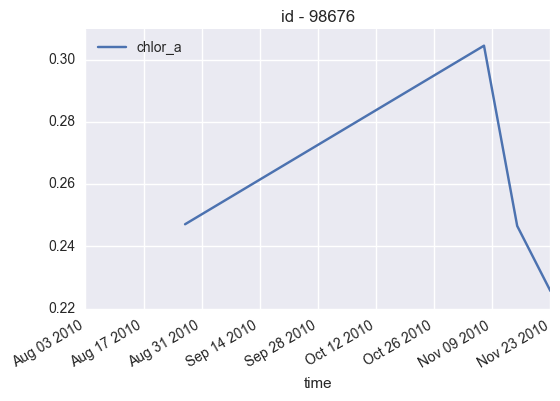

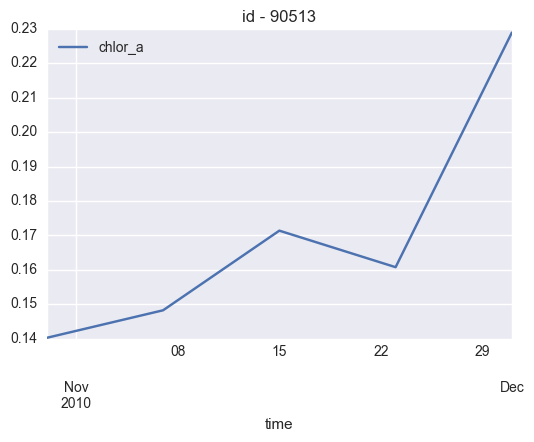

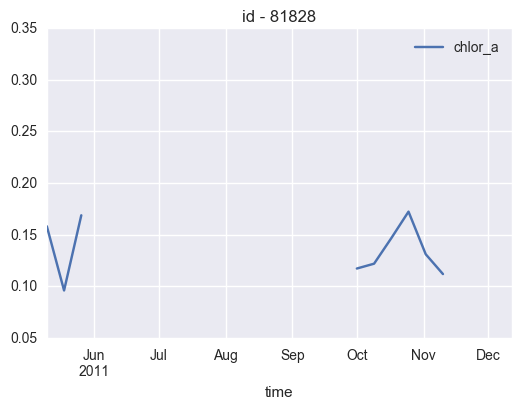

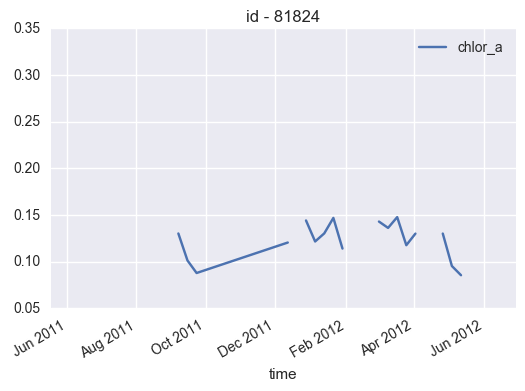

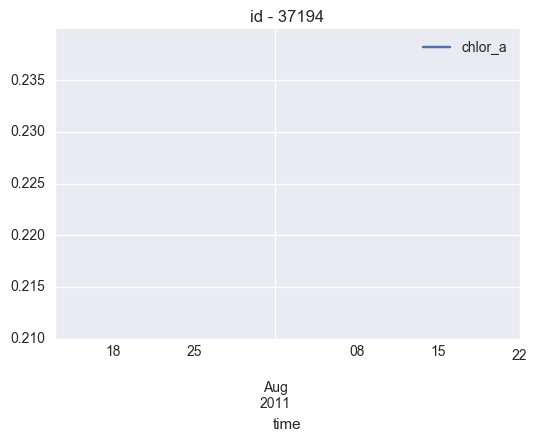

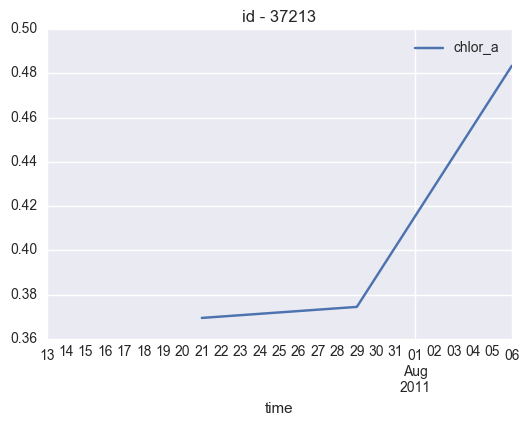

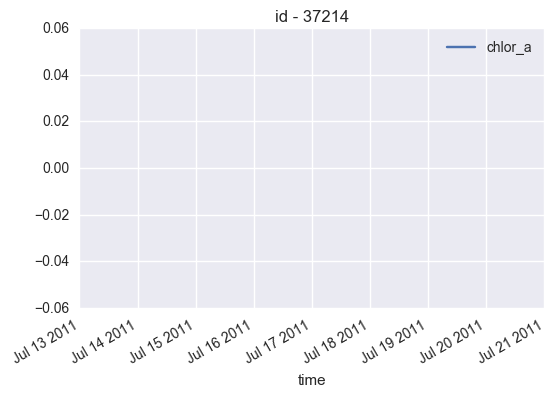

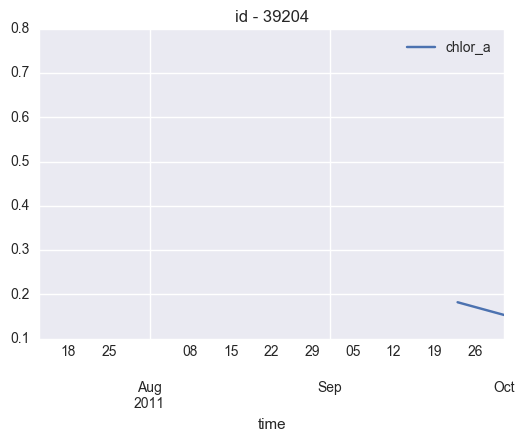

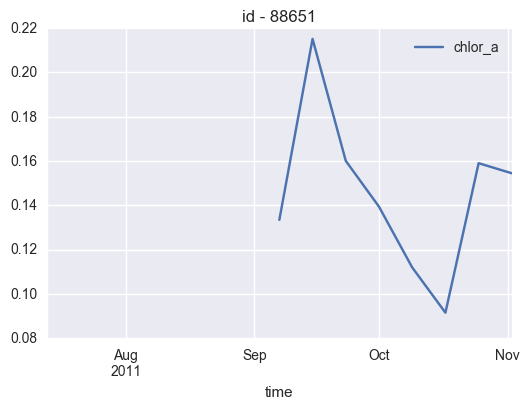

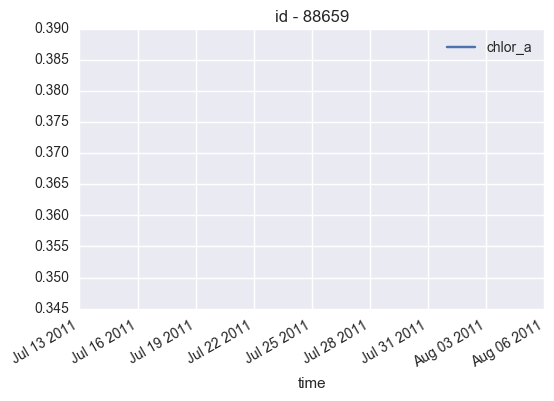

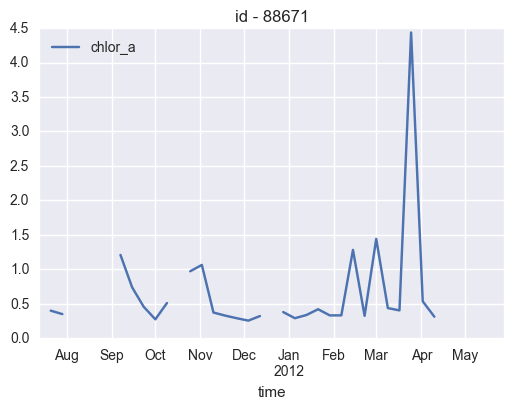

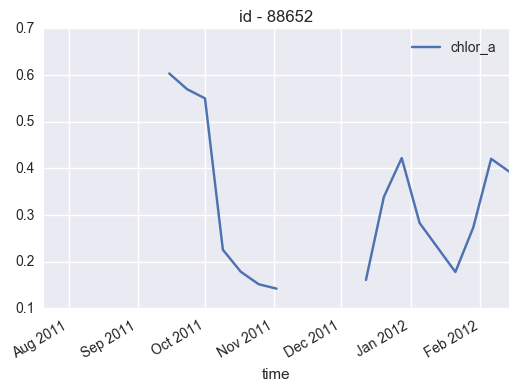

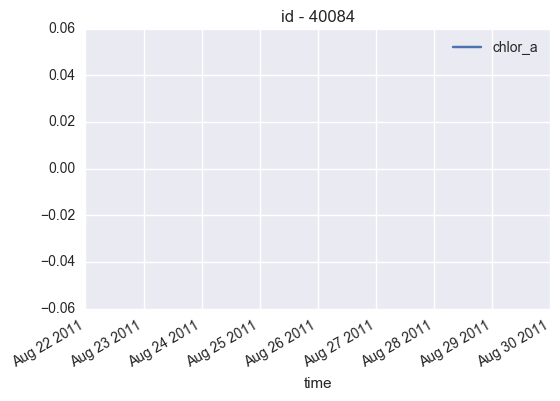

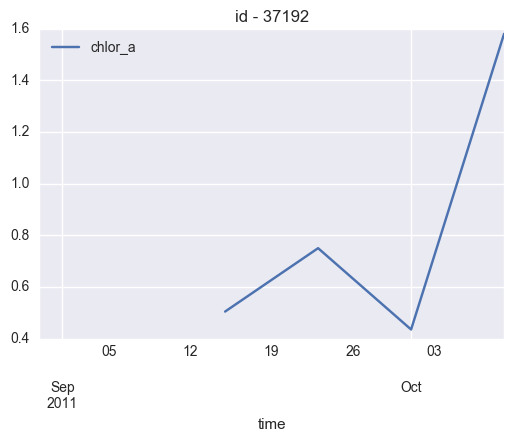

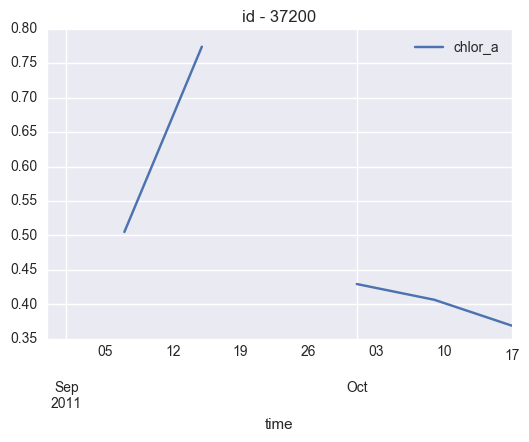

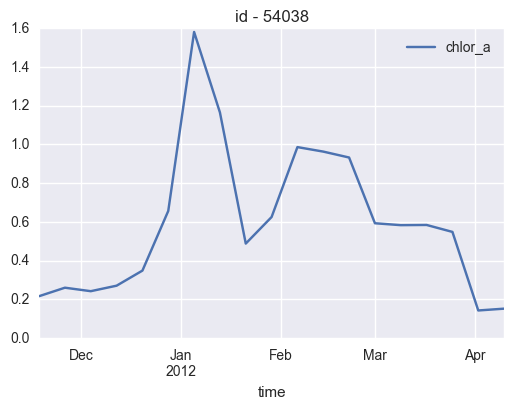

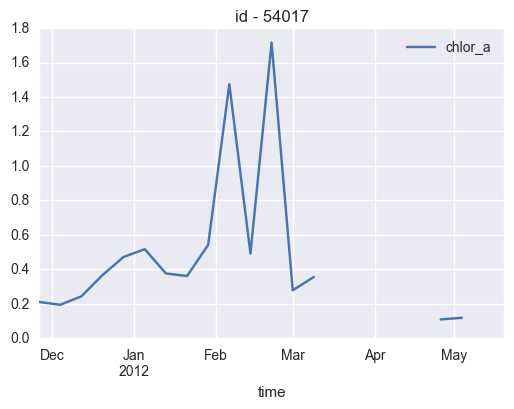

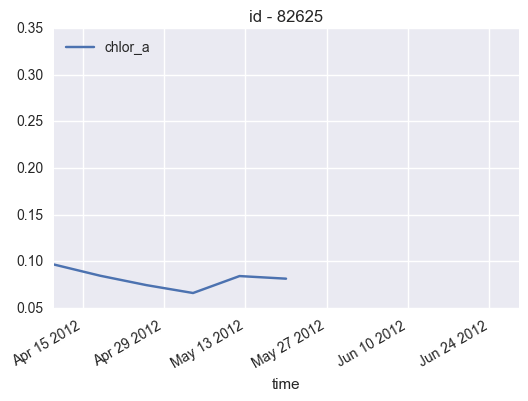

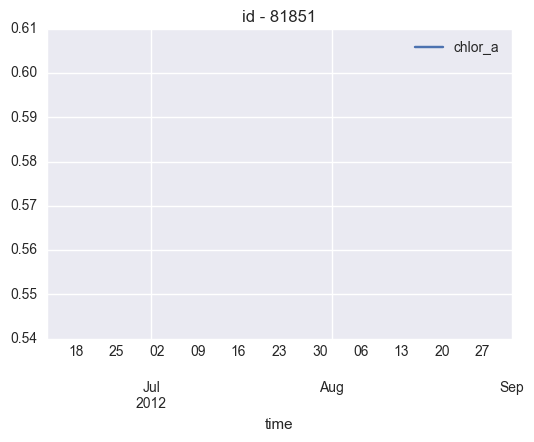

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735043.0, right=735043.0
  'left=%s, right=%s') % (left, right))


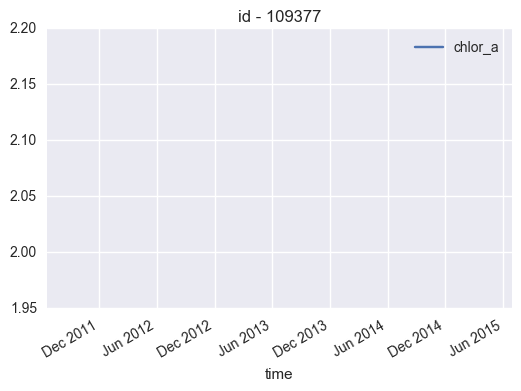

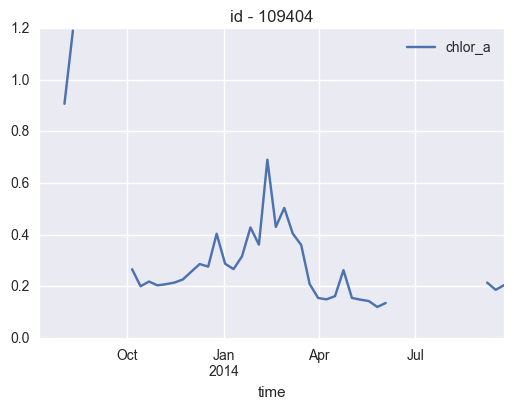

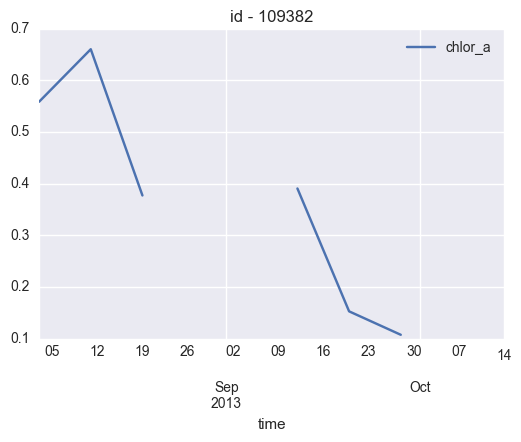

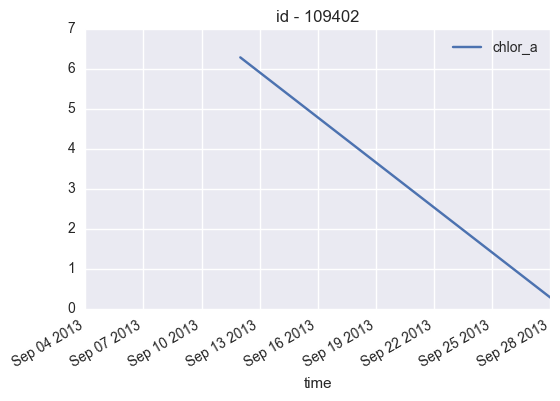

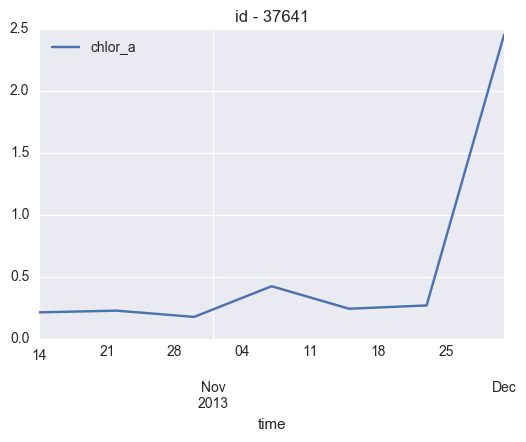

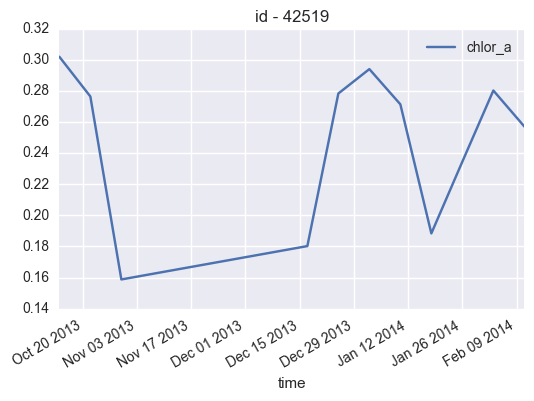

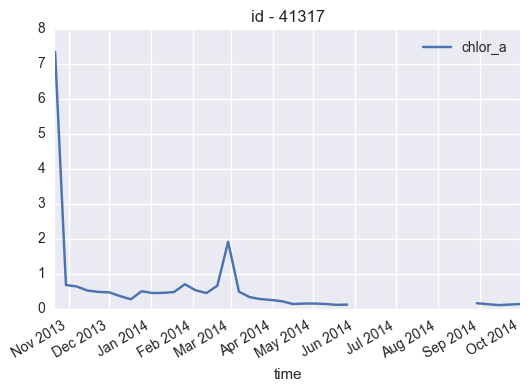

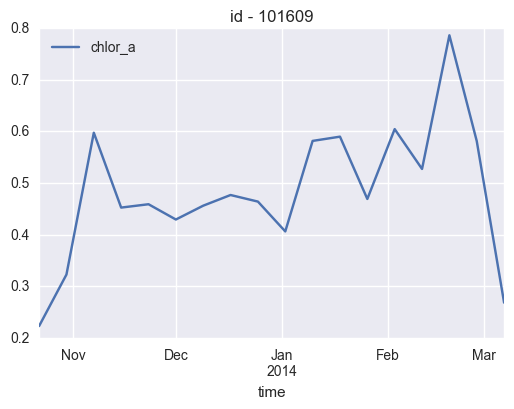

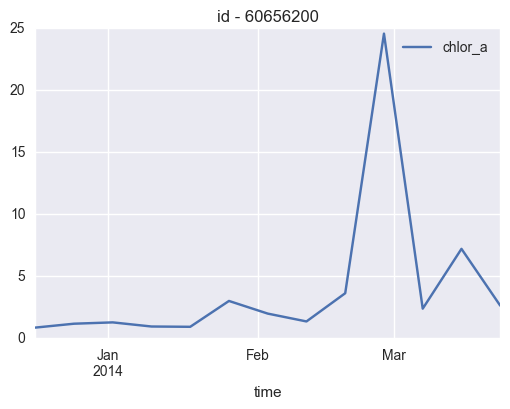

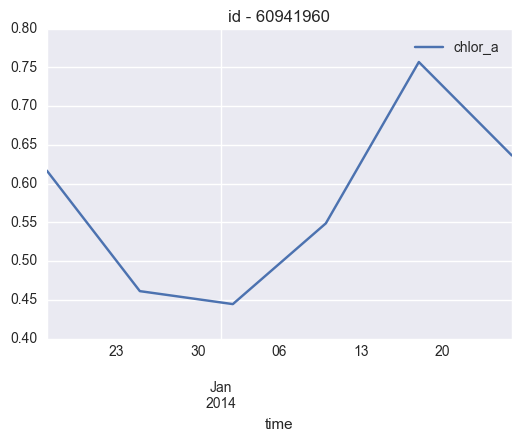

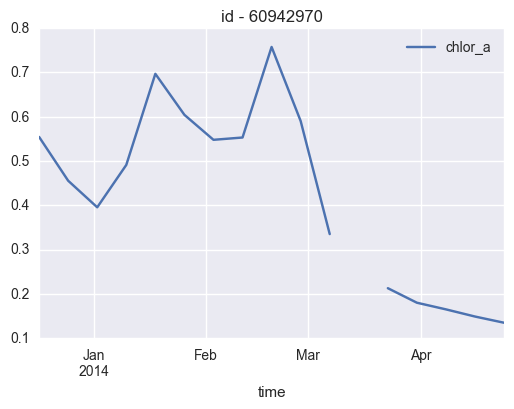

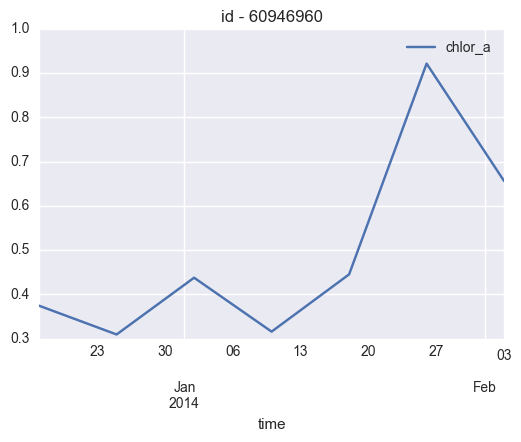

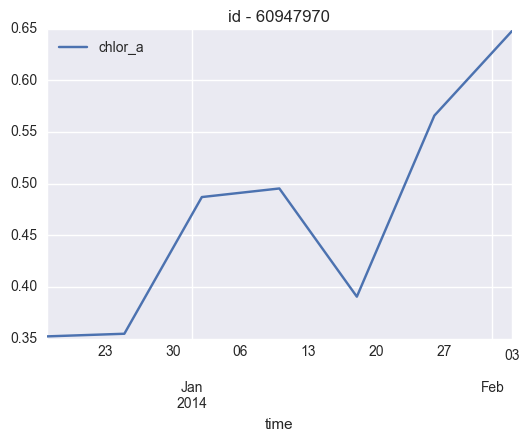

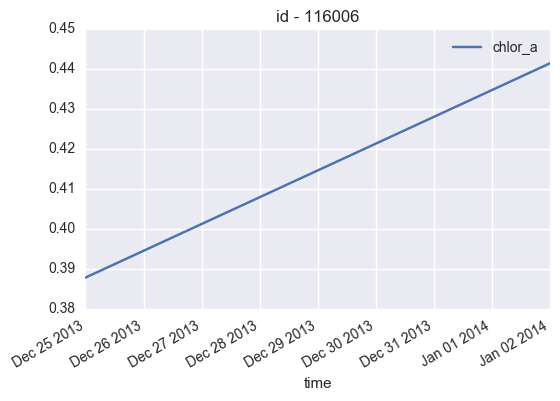

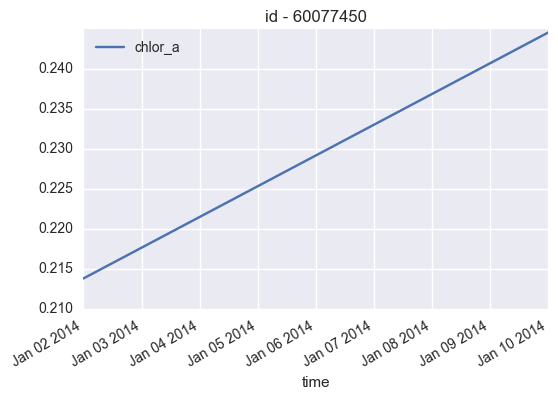

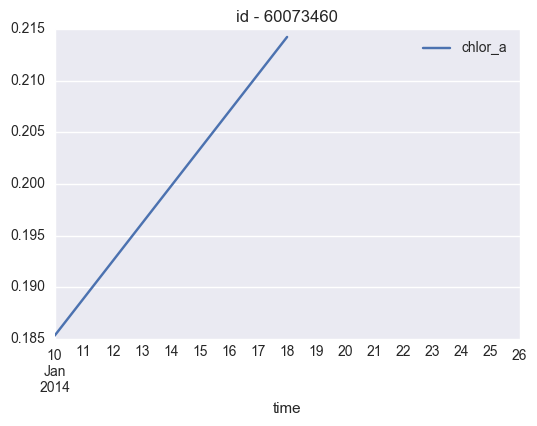

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735243.0, right=735243.0
  'left=%s, right=%s') % (left, right))


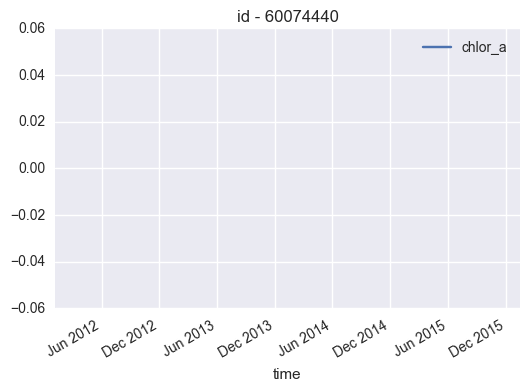

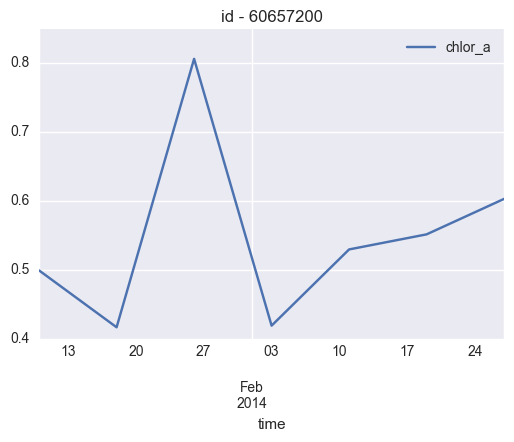

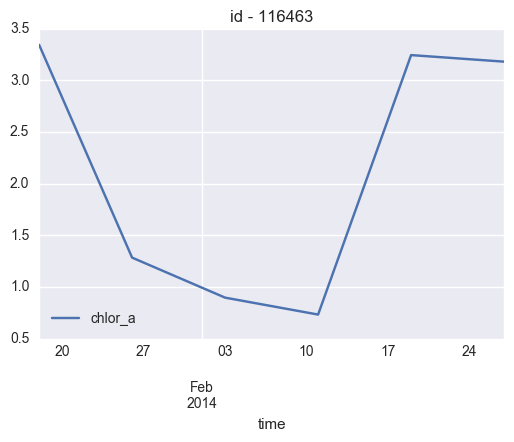

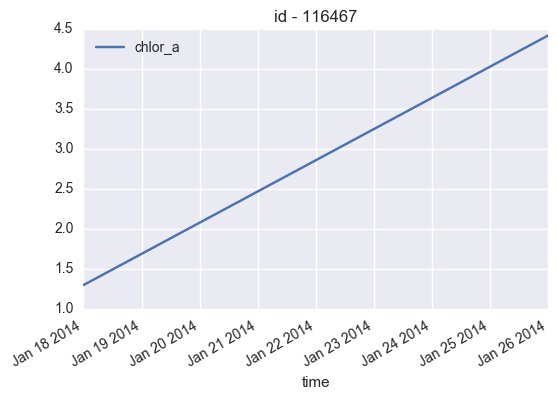

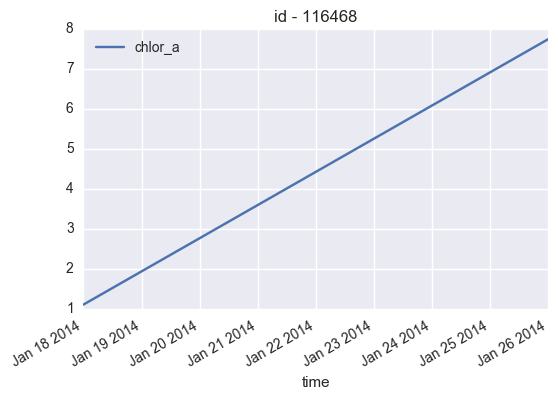

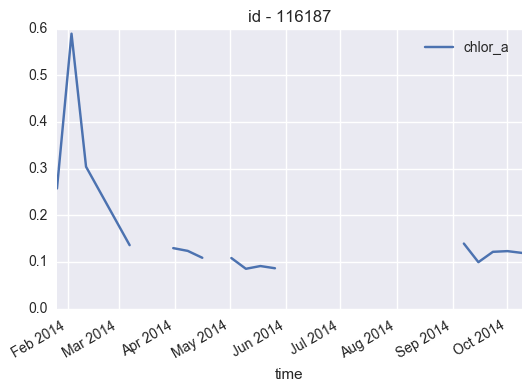

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735259.0, right=735259.0
  'left=%s, right=%s') % (left, right))


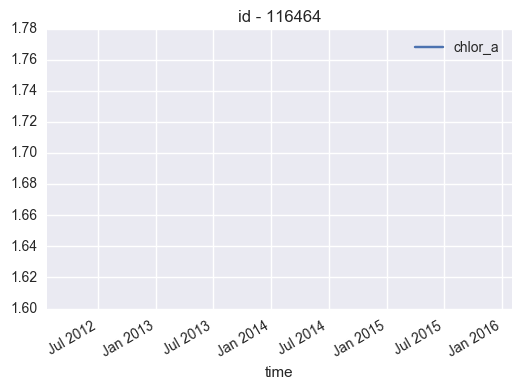

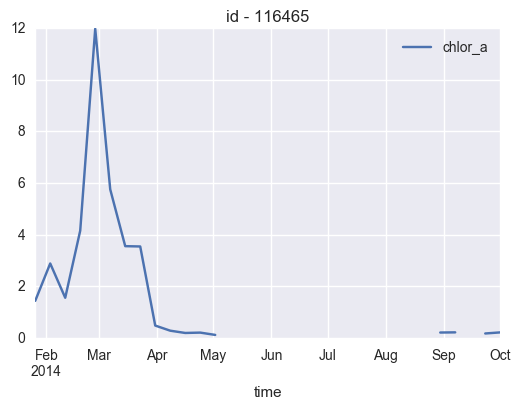

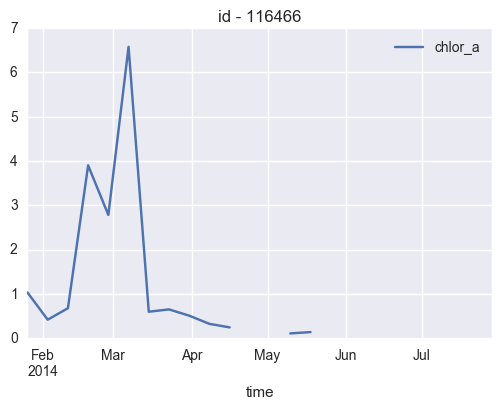

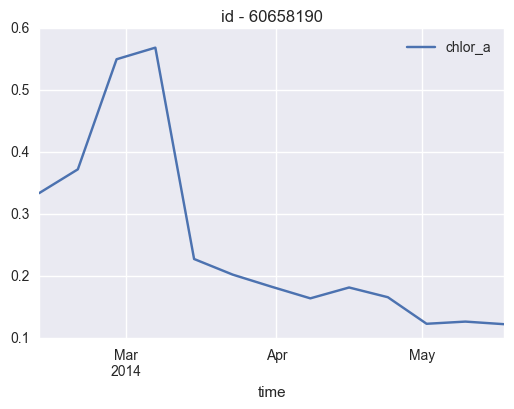

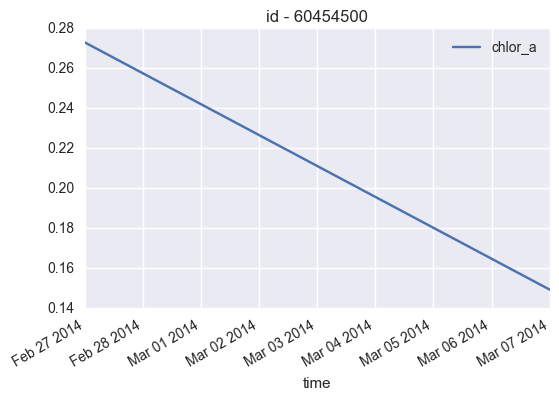

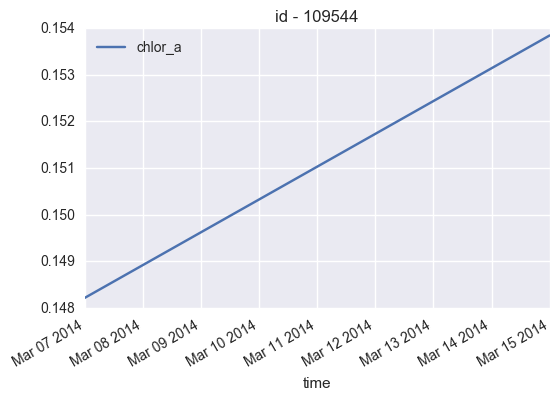

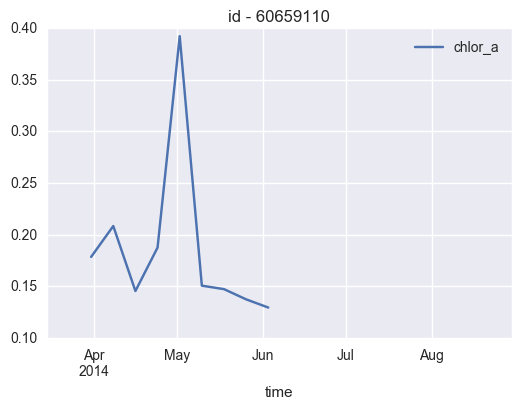

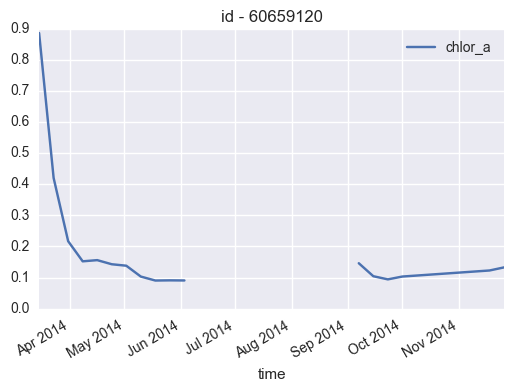

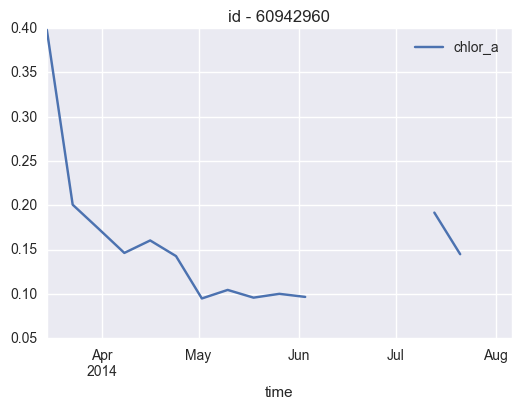

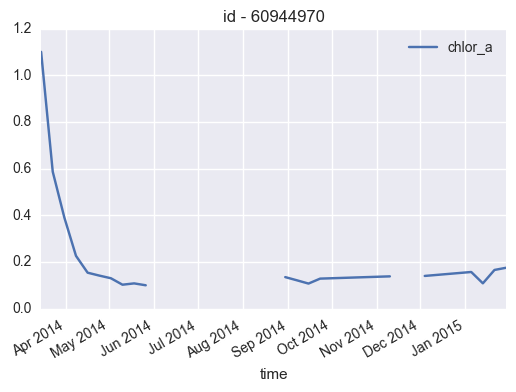

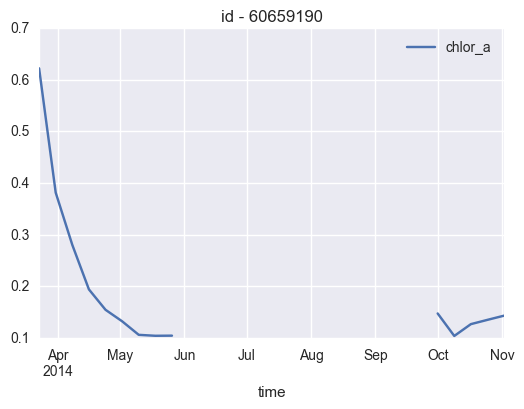

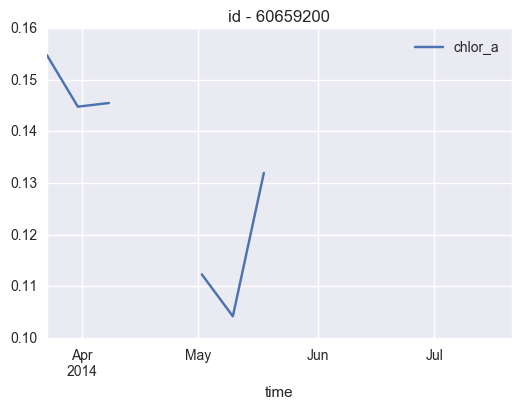

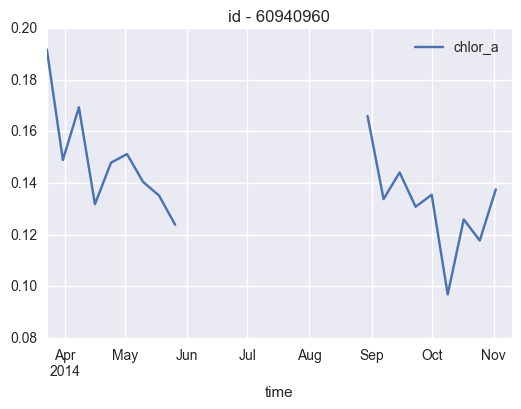

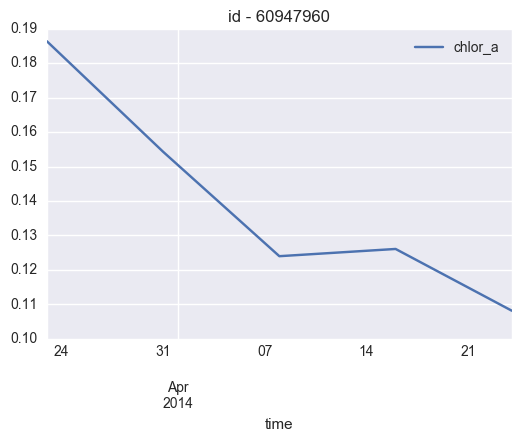

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735347.0, right=735347.0
  'left=%s, right=%s') % (left, right))


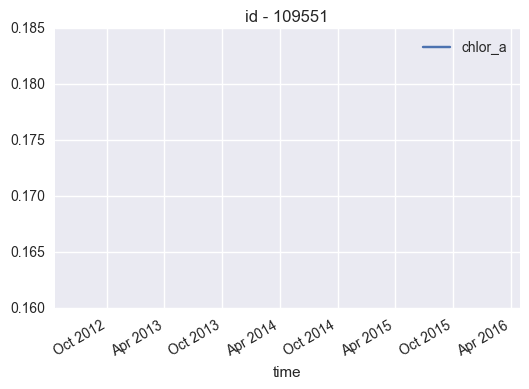

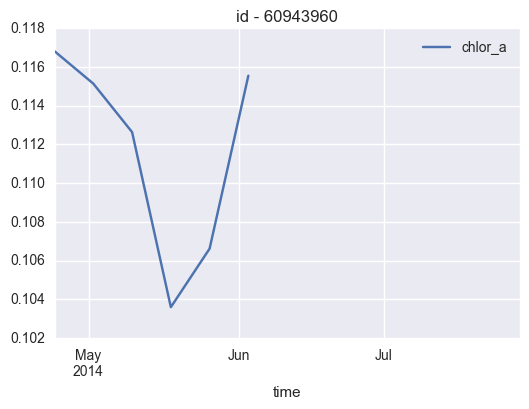

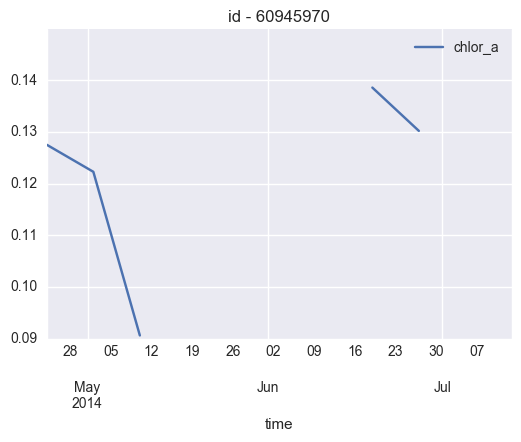

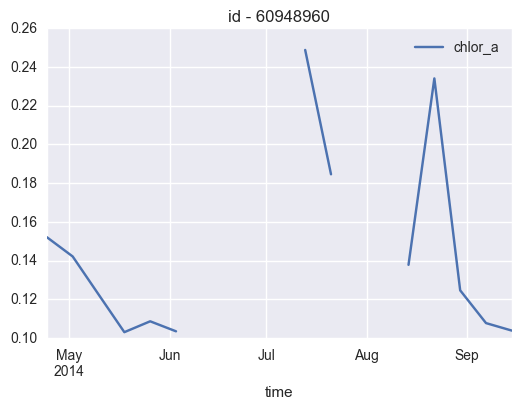

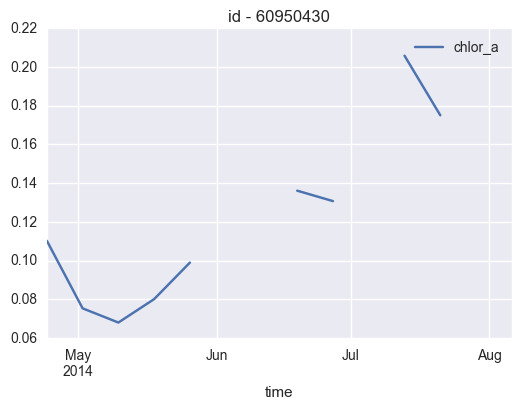

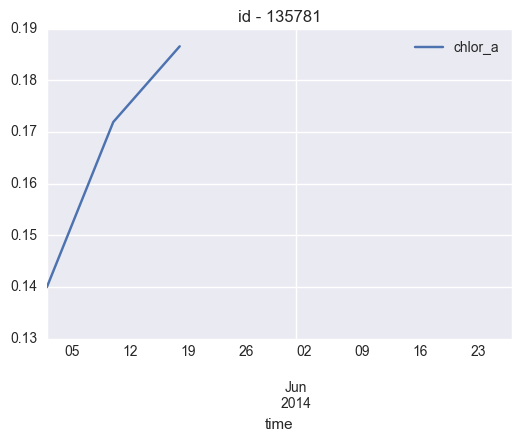

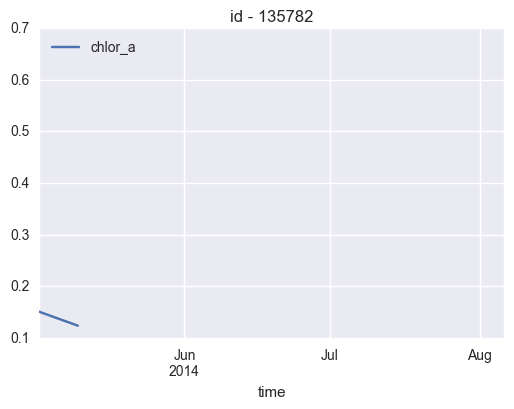

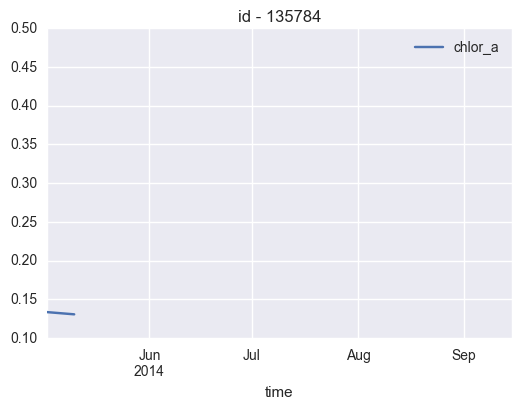

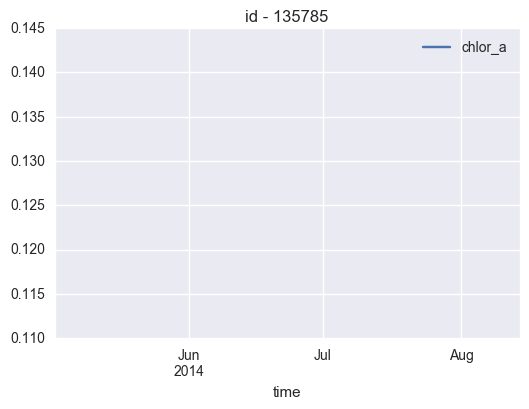

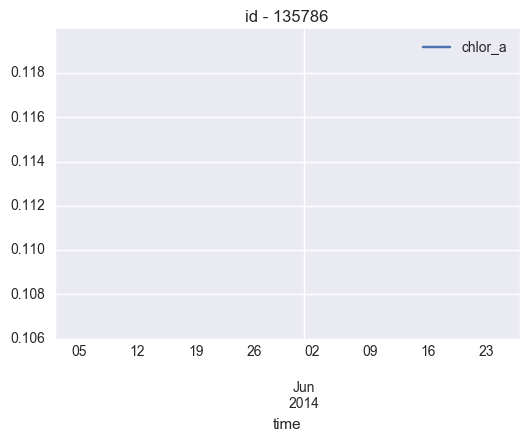

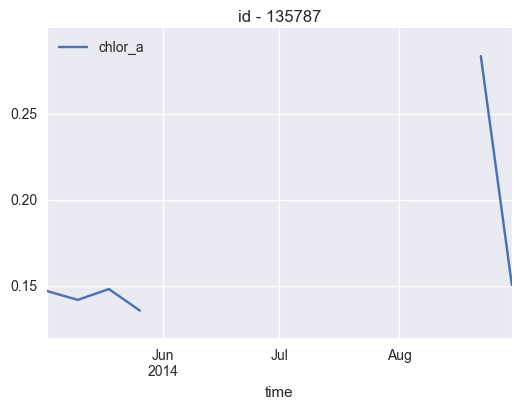

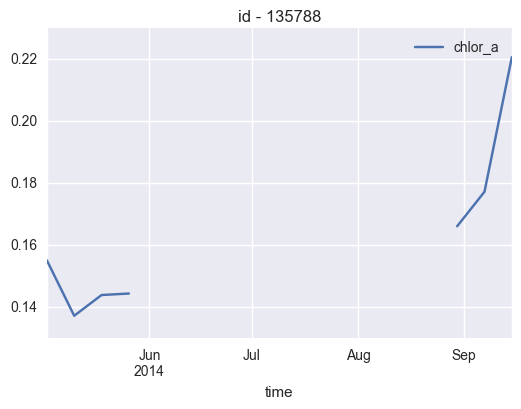

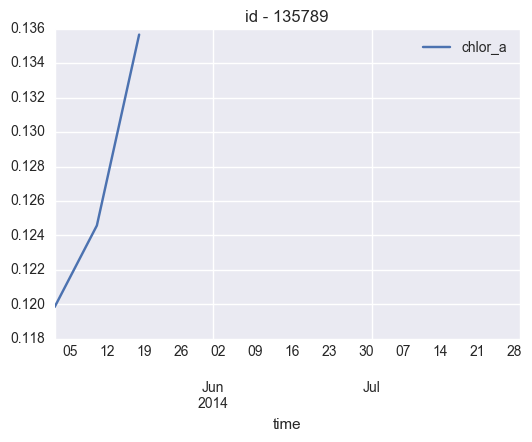

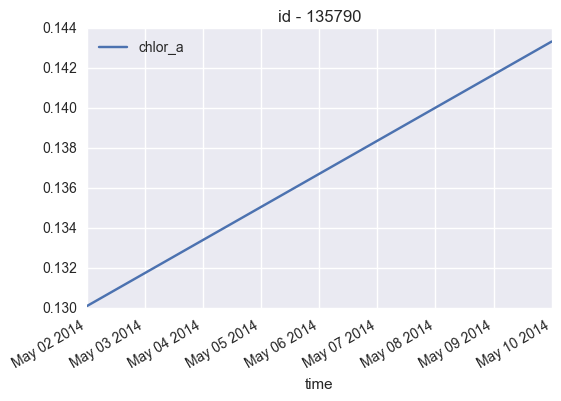

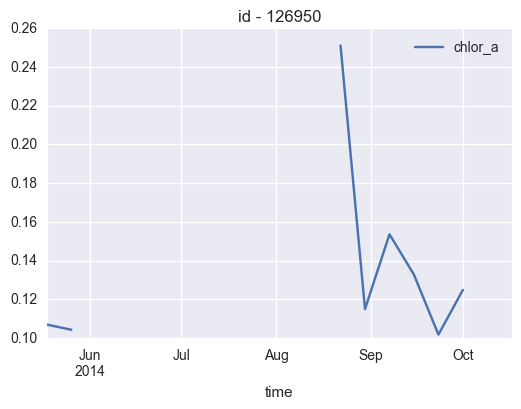

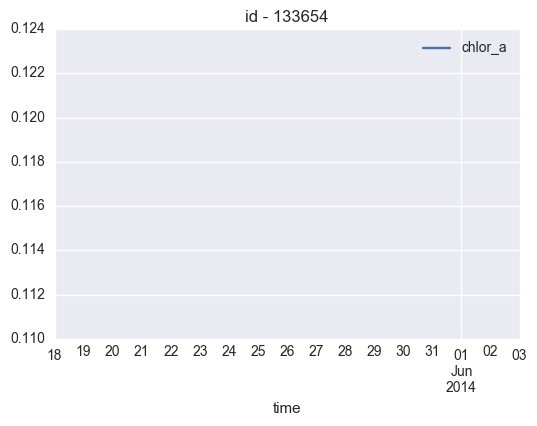

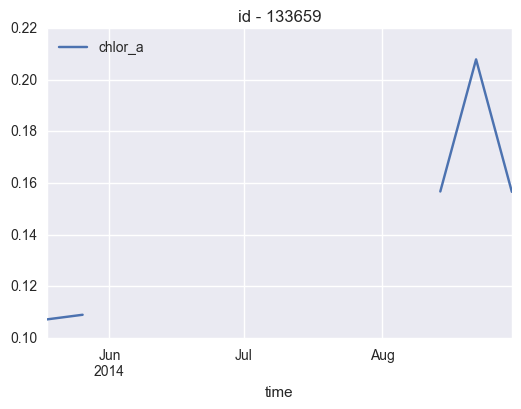

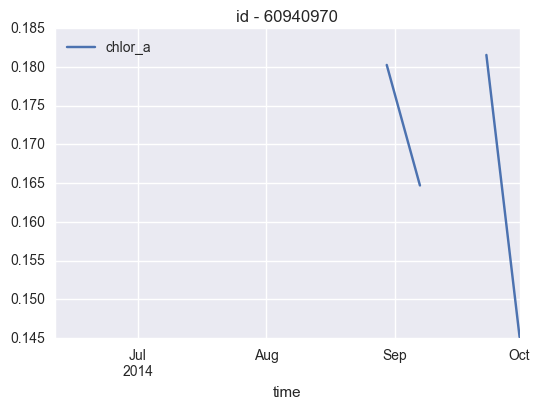

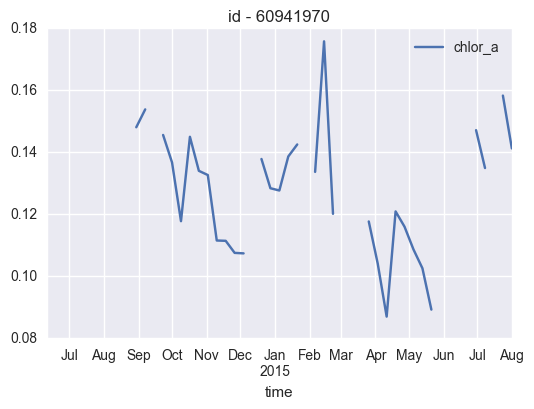

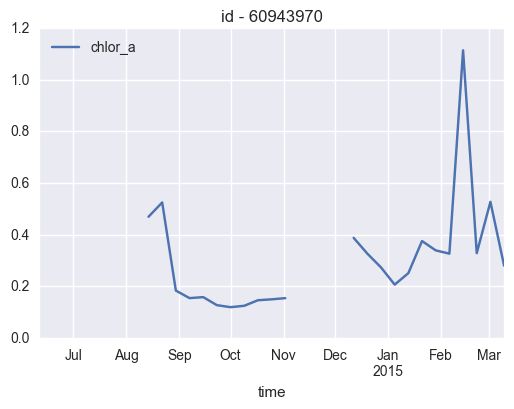

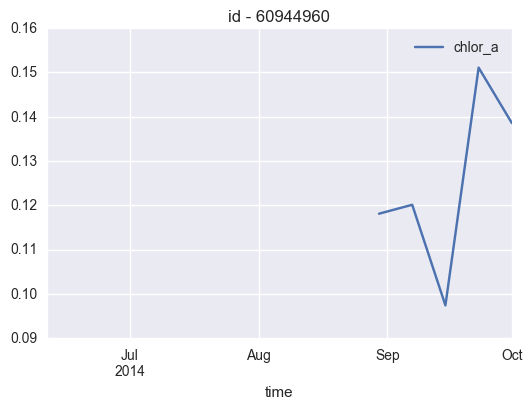

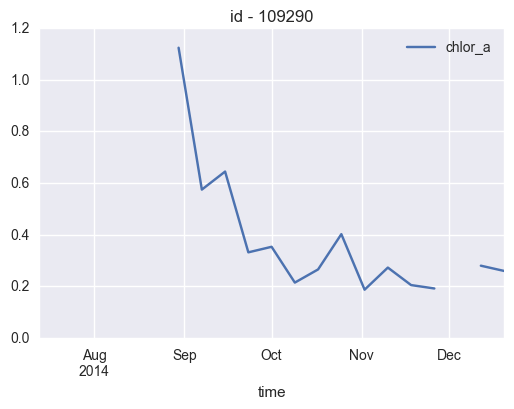

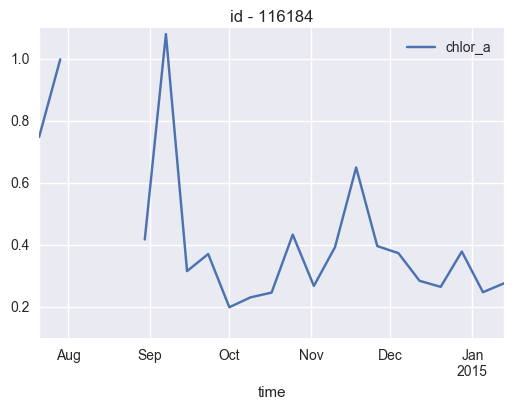

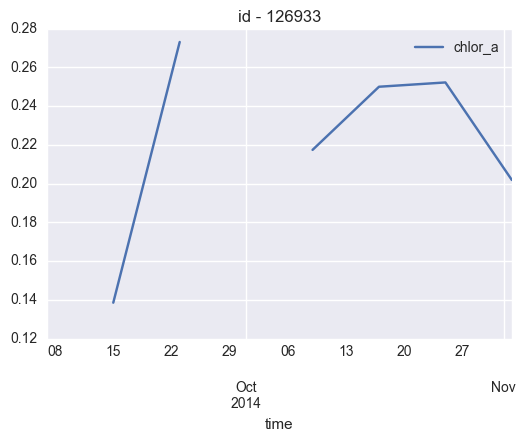

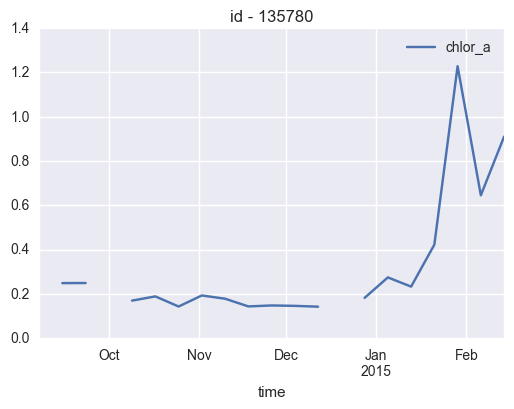

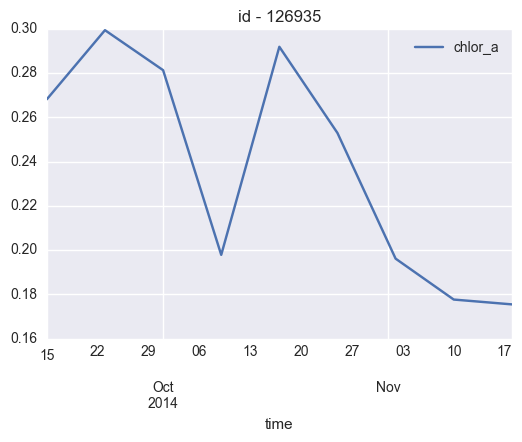

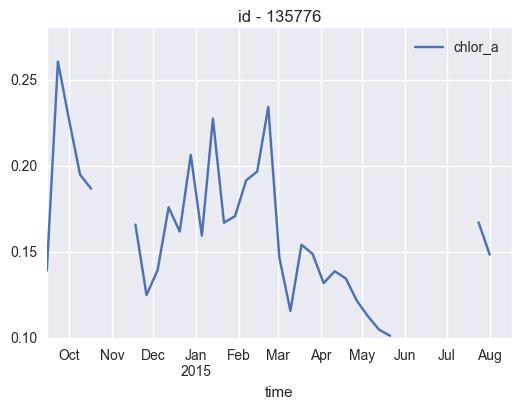

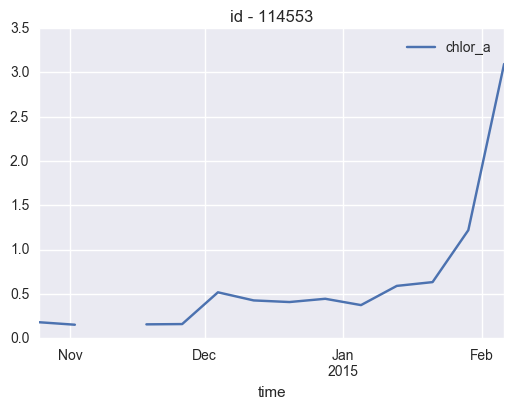

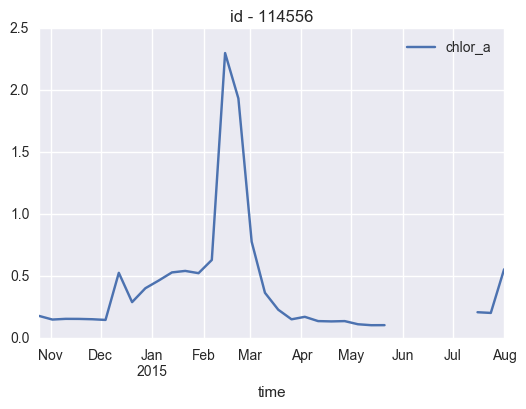

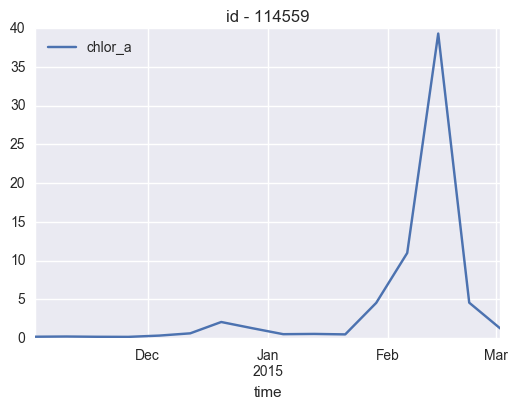

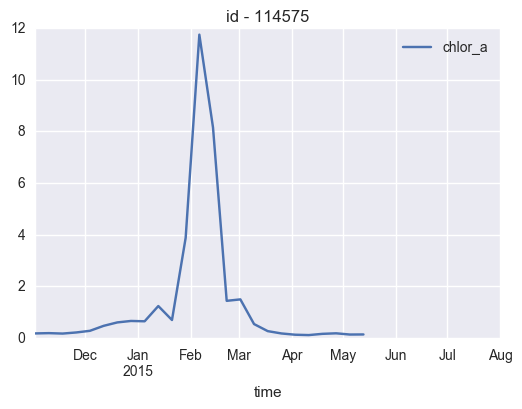

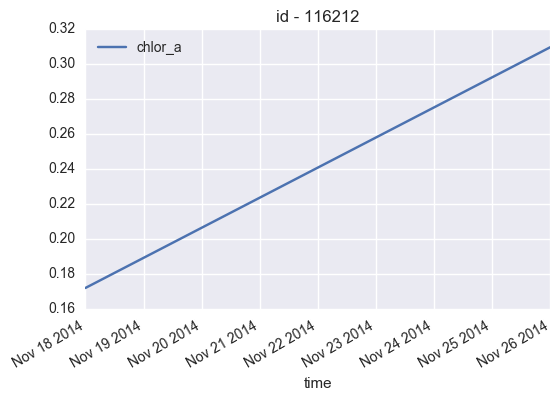

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735603.0, right=735603.0
  'left=%s, right=%s') % (left, right))


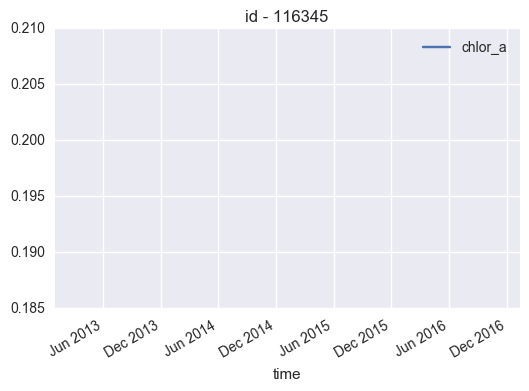

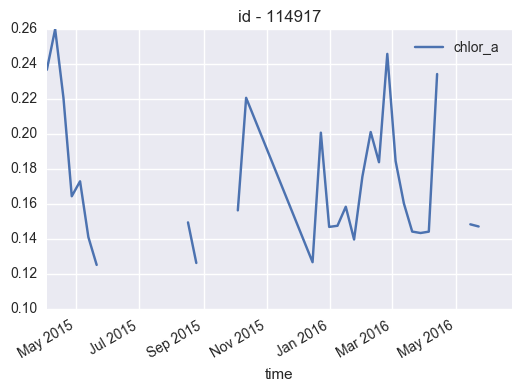

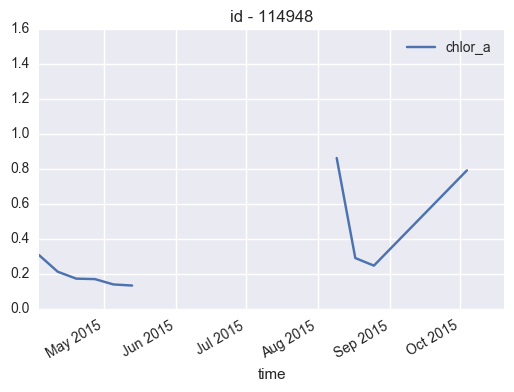

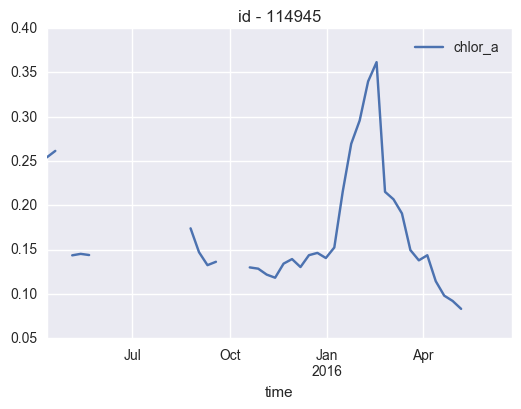

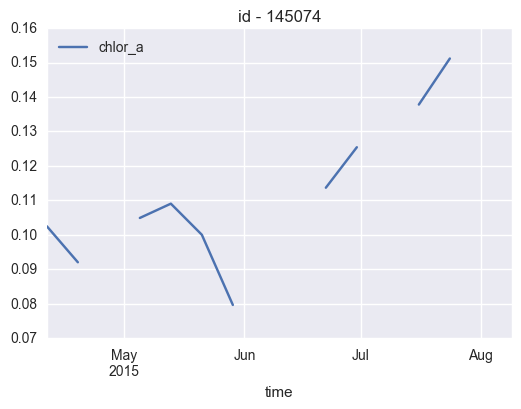

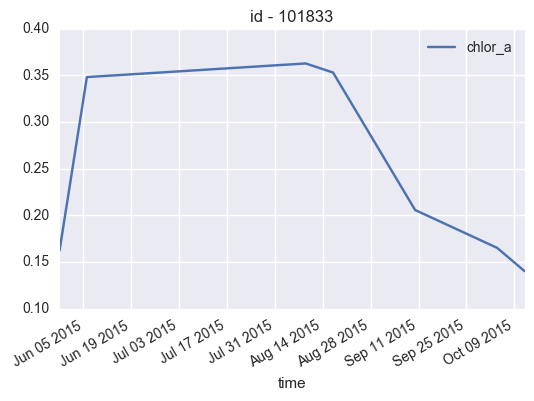

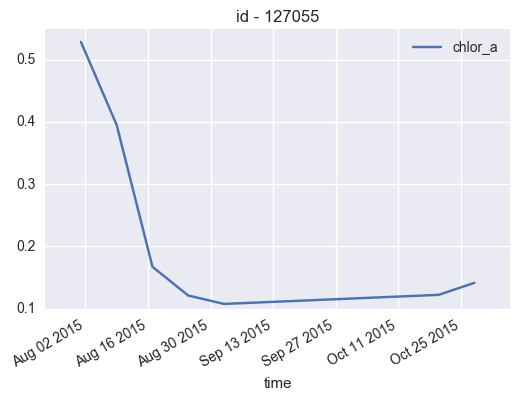

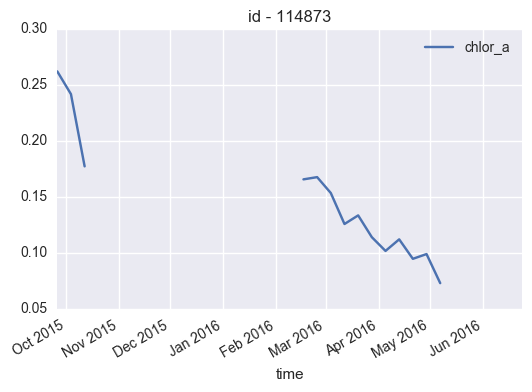

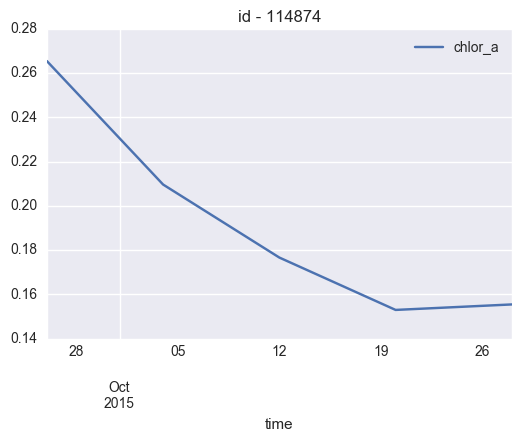

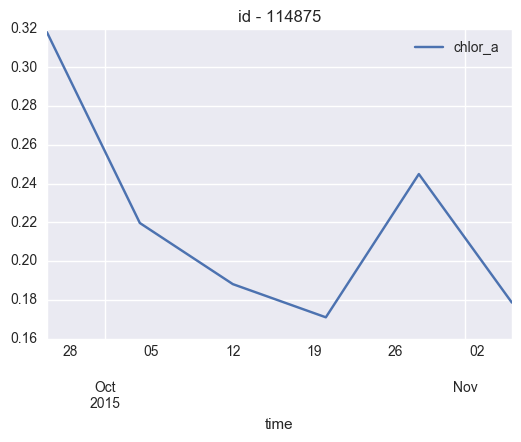

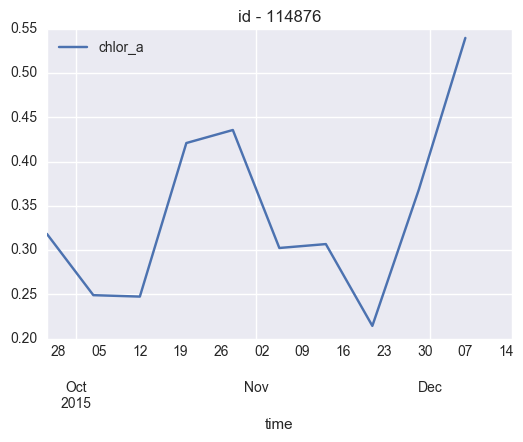

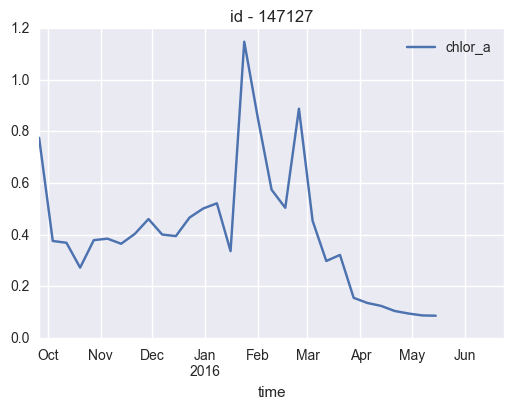

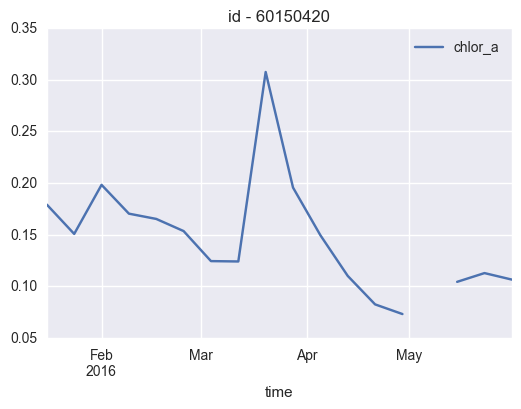

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736027.0, right=736027.0
  'left=%s, right=%s') % (left, right))


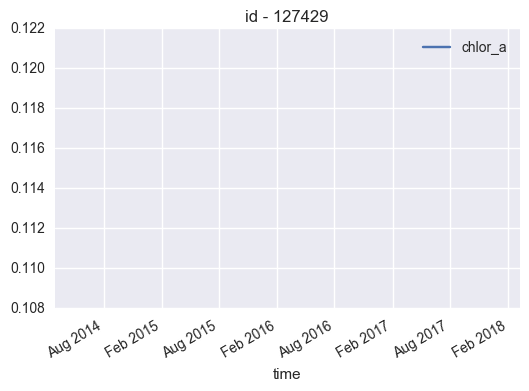

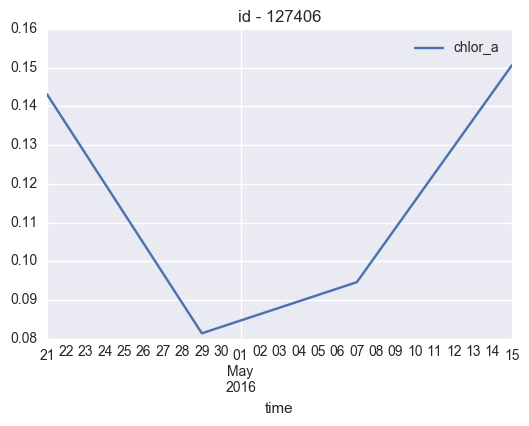

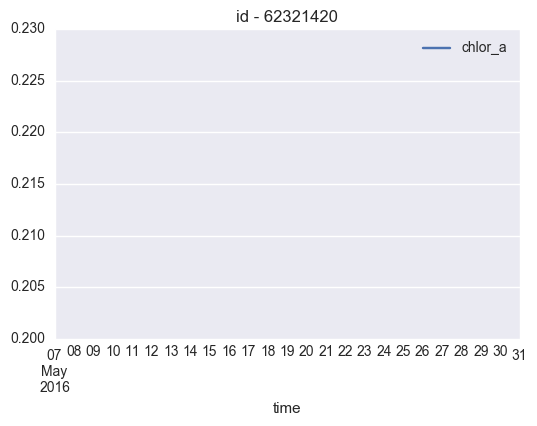

In [199]:
### chl-a concentration plots for each float ###
print("\n ****** chl-a concentration plots for each float ****** \n")
tmp_df_result4 = result_out4.to_dataframe()

plt.figure(figsize=(8,6))
for i in id_set:
    tmp_df_result4[tmp_df_result4.id == i].plot(x='time', y ='chlor_a', title=('id - %d' % i) )
    plt.show();
plt.close("all")